## Import Libraries

BERT for classification: 

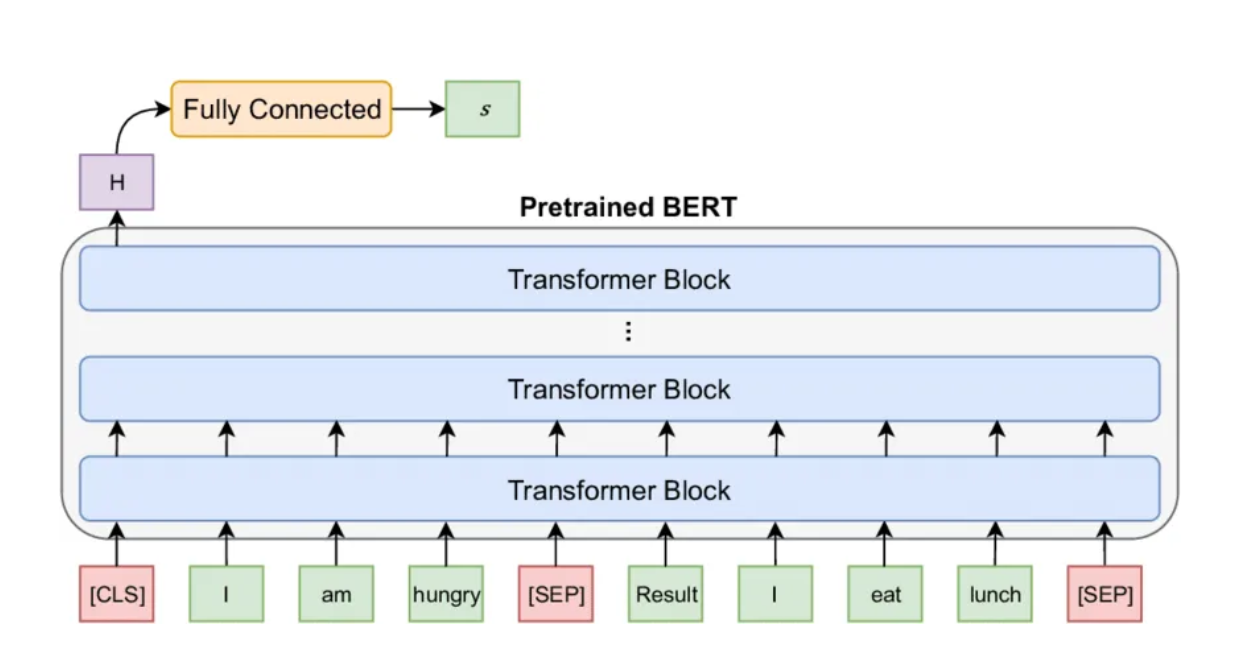
- https://medium.com/@pyroswolf200/fine-tuning-bert-on-imdb-review-dataset-309e90b6dac0

The IMDb Movie Reviews dataset is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. In this article we will try to classify film review sentences as good or bad.

#### Import Libraries

In [4]:
#ShoW each Cell's Execution Time
# !pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2024-07-24 12:56:36 +03:00)


In [5]:
import torch
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    print(f" DEVICE: {DEVICE}. GPU: {torch.cuda.get_device_name(0)} is available.")    
else:
    DEVICE = 'cpu'
    print(f" DEVICE: {DEVICE}. No GPU available. Training will run on CPU."  )    

 DEVICE: cuda:0. GPU: NVIDIA GeForce RTX 4050 Laptop GPU is available.
time: 1.14 s (started: 2024-07-24 12:56:37 +03:00)


In [6]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, RandomSampler
from transformers import  BertTokenizer, BertModel, get_linear_schedule_with_warmup
from datasets import load_dataset
from torch.utils.data import Subset

import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import re
import os 
from functools import partial



c:\Users\user\anaconda3\envs\torch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


time: 1.58 s (started: 2024-07-24 12:56:38 +03:00)


In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")

time: 0 ns (started: 2024-07-24 12:56:39 +03:00)


In [8]:
import sys

#for local vscode
sys.path.append('./src') #link to GTL libraries
import src.guided_transfer_learning as gtl
# 
# #for kaggle: 
# import sys
# sys.path.append('/kaggle/input/gtl-devtech/Guided Transfer Learning-DevTech/guided_transfer_learning_library/src') #link to GTL libraries
# import guided_transfer_learning as gtl

time: 15 ms (started: 2024-07-24 12:56:39 +03:00)


#### Functions:

In [267]:
def plot_multiple_results(results_list, title="Train and Validation Results (Accuracy and Loss)",legend_fontsize=9, nb_epochs_toplot=None):
    fig, axs = plt.subplots(1, 2, figsize=(40, 10))

    styles = [
        {'linestyle': (0,(1,1)), 'marker': 'o', 'color': '#2ca02c'},
        {'linestyle': 'dashdot', 'marker': 'x', 'color': '#1f77b4'},
        {'linestyle': (0,(5,1)), 'marker': 's', 'color': '#d62728'},
        {'linestyle': (5,(10,3)), 'marker': 'd', 'color': '#ff7f0e'}
    ]
    
    for i, results in enumerate(results_list):
        train_loss, train_acc = results['train_results']
        val_loss, val_acc = results['validation_results']


        if nb_epochs_toplot is None:
            max_epochs = max(max(len(train_acc) for results in results_list),
                        max(len(val_acc) for results in results_list),
                        max(len(train_loss) for results in results_list),
                        max(len(val_loss) for results in results_list))
        else:
            max_epochs = nb_epochs_toplot


        train_loss , train_acc , val_loss, val_acc = train_loss[:max_epochs], train_acc[:max_epochs], val_loss[:max_epochs+1], val_acc[:max_epochs+1], 
        
        style = styles[i % len(styles)]

        # Plot the training and validation accuracy
        axs[0].plot(range(1,len(train_acc) + 1), train_acc, marker=style['marker'], markersize=3, color=style['color'], label=f'Training Accuracy Selection {i+1}')
        axs[0].plot(val_acc, linestyle=style['linestyle'], marker=style['marker'],  markersize=3, color=style['color'], label=f'Validation Accuracy Selection {i+1}')

        # Plot the training and validation loss
        axs[1].plot(range(1,len(train_loss) + 1), train_loss, marker=style['marker'], markersize=3,color=style['color'], label=f'Training Loss Selection {i+1}')
        axs[1].plot(val_loss, linestyle=style['linestyle'], marker=style['marker'], markersize=3,color=style['color'], label=f'Validation Loss Selection {i+1}')

        # Set x-axis ticks to integers
        

    for ax in axs:
        ax.set_xticks(range(0, max_epochs + 1, 2))

    # Set labels and titles
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].legend(fontsize=legend_fontsize)

    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].legend(fontsize=legend_fontsize)

    # Add a title to the figure
    fig.suptitle(title)

    # Show the plot
    plt.show()


time: 0 ns (started: 2024-07-25 18:31:11 +03:00)


In [9]:
# Iterate over all parameters in the model
def check_trainable_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} is || TRAINABLE || ")
        else:
            print(f"{name} is || NOT TRAINABLE || ")

def count_trainable_layers(model):
    trainable_layers = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_layers += 1
    return trainable_layers

def count_parameters(model): 
    print("Number of parameters:", sum(p.numel() for p in model.parameters()))

def unfreeze_BERT_layers(bert, nb_layer_to_unfreeze):    
    if (0 < nb_layer_to_unfreeze <= len(bert.encoder.layer)):
        # Unfreeze the last 'nb_layer_to_unfreeze' layers
        for layer in bert.encoder.layer[-nb_layer_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True
        # Freeze the remaining layers
        for layer in bert.encoder.layer[:len(bert.encoder.layer) - nb_layer_to_unfreeze]:
            for param in layer.parameters():
                param.requires_grad = False
    else:
        print(" Number of unfreeze layers is larger than number of layers or less than 1.")
     

        
# Define the plotting function
def plot_loss(numbers): 
    plt.figure(figsize=(8, 5)) 
    plt.plot(range(1, len(numbers) + 1), numbers, marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss (Epochs)')
    plt.grid(True)
    plt.show()

def plot_acc_loss(results):
    # Create a figure and axis objects for the loss and accuracy plots
    fig, axs = plt.subplots(1,2, figsize=(16, 4))

    # Plot the loss values
    axs[0].plot(results[0], label='Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')

    # Plot the accuracy values
    axs[1].plot(results[1], label='Accuracy', color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training Accuracy')

    # Show the plots
    plt.show()
# Iterate over all parameters in the model
def check_trainable_layers(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name} is || TRAINABLE || ")
        else:
            print(f"{name} is || NOT TRAINABLE || ")

def count_trainable_layers(model):
    trainable_layers = 0
    for param in model.parameters():
        if param.requires_grad:
            trainable_layers += 1
    return trainable_layers

def count_parameters(model): 
    print("Number of parameters:", sum(p.numel() for p in model.parameters()))

def unfreeze_BERT_layers(bert, nb_layer_to_unfreeze):    
    if (0 < nb_layer_to_unfreeze <= len(bert.encoder.layer)):
        # Unfreeze the last 'nb_layer_to_unfreeze' layers
        for layer in bert.encoder.layer[-nb_layer_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True
        # Freeze the remaining layers
        for layer in bert.encoder.layer[:len(bert.encoder.layer) - nb_layer_to_unfreeze]:
            for param in layer.parameters():
                param.requires_grad = False
    else:
        print(" Number of unfreeze layers is larger than number of layers or less than 1.")
            
# Define the plotting function
def plot_loss(numbers): 
    plt.figure(figsize=(8, 5)) 
    plt.plot(range(1, len(numbers) + 1), numbers, marker='o', linestyle='-')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss (Epochs)')
    plt.grid(True)
    plt.show()

def plot_acc_loss(results):
    # Create a figure and axis objects for the loss and accuracy plots
    fig, axs = plt.subplots(1,2, figsize=(16, 4))

    # Plot the loss values
    axs[0].plot(results[0], label='Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training Loss')

    # Plot the accuracy values
    axs[1].plot(results[1], label='Accuracy', color='orange')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Training Accuracy')

    # Show the plots
    plt.show()

def plot_results(results, title="Train and Validation Results (Accuracy and Loss)"):
    # Unpack the results
    train_loss, train_acc = results['train_results']
    val_loss, val_acc = results['validation_results']

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    # Plot the training and validation accuracy
    axs[0].plot(range(1,len(train_acc)+1),train_acc, label='Training Accuracy')
    axs[0].plot(val_acc, label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].legend()

    # Plot the training and validation loss
    axs[1].plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    axs[1].plot(val_loss, label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Training and Validation Loss')
    axs[1].legend()

    # Add a title to the figure
    fig.suptitle(title)

    # Show the plot
    plt.show()



def add_selection_range(dataset_indexes_selection, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class):
    # Iterate over each class in the list of random classes
    for class_ in random_classes_B:
        class_indexes = []  # Initialize a list to store indexes of items belonging to the current class        
        # Iterate over the dataset to find items that match the current class
        for i, item in enumerate(goemotions_train_dataset_B):
            if item['labels'] == [class_] and i not in previous_selections:
                class_indexes.append(i)  # Add the index to the class_indexes list            
            # If the number of items for the current class reaches the limit, stop the search for this class
            if len(class_indexes) == limit_per_class:
                break        
        # Extend the main selection list with the indexes found for the current class
        dataset_indexes_selection.extend(class_indexes)    
    # Extend the previous selections list with the new selections
    previous_selections.extend(dataset_indexes_selection) 

time: 15 ms (started: 2024-07-24 12:56:39 +03:00)


In [56]:
# Define the training function
def train_model(model, optimizer, criterion, epochs, train_loader, validation_loader, with_early_stopping=True,train_loader_sampler=None, validation_loader_sampler=None, train_verbose=True,eval_verbose=True, with_GTL=False, guidance_matrix=None, patience=3):
    
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    skip = 2000 if epochs > 10000 else 300 if epochs > 1000 else 30 if epochs > 100 else 5 if epochs > 10 else 1
    model.train() # Set the model to training mode
    train_loss_vals = []; train_acc_vals = []; val_loss_vals = []; val_acc_vals = [];

    # scheduler adjusts the learning rate for each batch during training
    num_training_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    #####################################################################################################################
    #####################################################################################################################
    # Claclualte the loss and accuracy for Epoch -1 ( before training)
    epoch_loss = 0.0; epoch_loss_sum = 0.0; epoch_acc = 0; epoch_acc_sum = 0.0; 
    print(f"# Epoch: 0  (Before start training) ")    
    val_loss, val_acc = evaluate_model(model, validation_loader, criterion, validation_loader_sampler, verbose=eval_verbose)
    val_loss_vals.append(val_loss)
    val_acc_vals.append(val_acc)
    print("============================================================================================================================================================")

    #####################################################################################################################
    ##################################################################################################################### 

    #For each epoch
    for epoch in range(epochs):
        epoch_loss = 0.0;epoch_loss_sum = 0.0; epoch_acc = 0; epoch_acc_sum = 0.0;
        if train_verbose and ((epoch + 1) % skip == 0 or epoch == 0 or epoch == epochs - 1):
            print(f"# Epoch: {epoch+1} (Learning rate: {optimizer.param_groups[0]['lr']}) ", end='')

        #Batch training       
        # for batch in tqdm(train_loader):
        for batch in train_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            model.zero_grad() # Ensure all gradients are zero
            loss.backward() # Computes dloss/dx for every parameter x which has requires_grad=True and saves it in x.grad

            if with_GTL and guidance_matrix is None:
                print('Guidance matrix is not provided')
                return None
            if with_GTL and guidance_matrix is not None:# Multiply the gradient of each parameter in the model with the corresponding value in the guidance matrix.
                gtl.apply_guidance(model, guidance_matrix) 

            optimizer.step()  # Optimizer.step updates the value of x using the gradient x.grad
            scheduler.step() # Adjusts the learning rate according to the scheduler's strategy

            predictions = torch.argmax(outputs, dim=1) 
            epoch_loss_sum += loss.item() 
            epoch_acc_sum += (predictions == labels).sum().item() 

        #Calculate accuracy and loss  
        epoch_loss = epoch_loss_sum / len(train_loader)
        epoch_acc = epoch_acc_sum / len(train_loader_sampler) if train_loader_sampler else epoch_acc_sum/len(train_loader.dataset)  
        train_loss_vals.append(epoch_loss) 
        train_acc_vals.append(epoch_acc)  
        
        val_loss, val_acc = evaluate_model(model, validation_loader, criterion, validation_loader_sampler, verbose=False)
        val_loss_vals.append(val_loss)
        val_acc_vals.append(val_acc)
        
        # Early stopping
        if with_early_stopping:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement == patience:
                    print(f'Early stopping after {epochs_without_improvement+1} epochs without improvement.')
                    print(f'- Training loss: {epoch_loss:.2f} || Training acc: {epoch_acc:.2f} || Validation loss: {val_loss:.2f} ||  Validation acc: {val_acc:.2f}\n ')
                    break        
        if train_verbose and ((epoch + 1) % skip == 0 or epoch == 0 or epoch == epochs - 1):
            print(f' Training loss: {epoch_loss:.2f} || Training acc: {epoch_acc:.2f} || Validation loss: {val_loss:.2f} || Validation acc: {val_acc:.2f}')
        time.sleep(5)
    return {'train_results':[train_loss_vals, train_acc_vals], 'validation_results': [val_loss_vals,val_acc_vals],}

# Define the evaluation function
# Define the evaluation function
def evaluate_model(model, loader, criterion, loader_sampler=None, verbose=True, dataset_category="Validation"):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0;total_acc = 0 ;
    if verbose:
        print(f"# Evaluating on {dataset_category} Dateset: ", end= '')
    with torch.no_grad():
        # for batch in tqdm(loader):
        for batch in loader:
            input_ids = batch['input_ids'].to(device=DEVICE) 
            attention_mask = batch['attention_mask'].to(device=DEVICE) 
            labels = batch['labels'].to(device=DEVICE) 
            # Forward pass
            outputs = model(input_ids, attention_mask) 
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1) 
            total_acc += (predictions == labels).sum().item() 
    avg_loss = total_loss / len(loader)
    accuracy = total_acc / len(loader_sampler) if loader_sampler else total_acc/len(loader.dataset)
    if verbose:
        print(f'# {dataset_category} loss: {avg_loss:.2f} || {dataset_category}  acc: {accuracy:.2f}') 
    return avg_loss, accuracy

time: 16 ms (started: 2024-07-24 15:08:09 +03:00)


In [11]:
# Define custom model architecture
class ClassificationBERT(nn.Module):
    """
    will create a classification model built on BERT with all BERT layers frozen 
    """
    def __init__(self, bert,num_labels,dropout=0.1):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert.config.hidden_size, num_labels) 
        
        # #freeze embedding first layers
        # self.bert.embeddings.word_embeddings.weight.requires_grad = False
        # self.bert.embeddings.position_embeddings.weight.requires_grad = False
        # self.bert.embeddings.token_type_embeddings.weight.requires_grad = False
        # self.bert.embeddings.LayerNorm.weight.requires_grad = False
        # self.bert.embeddings.LayerNorm.bias.requires_grad = False

        # #all BERT layers frozen by default
        # for layer in self.bert.encoder.layer[:]:
        #     for param in layer.parameters():
        #         param.requires_grad = False

        # Freeze BERT embedding layers (word embeddings, position embeddings, layer norm layers)
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        
        # Freeze BERT encoder layers
        for layer in self.bert.encoder.layer:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        logits = self.classifier(output)
        return logits

time: 0 ns (started: 2024-07-24 12:56:39 +03:00)


In [12]:
# Initialize model, criterion, and optimizer
num_labels = 10
bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
ClassificationBERT_model = ClassificationBERT(bert, num_labels) 
ClassificationBERT_model.to(DEVICE) 

ClassificationBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

time: 1.58 s (started: 2024-07-24 12:56:39 +03:00)


#### Goemotions Dataset:

- download dataset

In [13]:
#load the dataset from hugging face datasets
goemotions_dataset = load_dataset('go_emotions') 

time: 14.5 s (started: 2024-07-24 12:56:41 +03:00)


In [15]:
# explore dataset: Dataset Dictonary of 3 datasets
goemotions_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

time: 0 ns (started: 2024-07-24 12:34:19 +03:00)


In [16]:
#dataset labels: 
goemotions_label_to_id = {
    'admiration': 0,
    'amusement': 1,
    'anger': 2,
    'annoyance': 3,
    'approval': 4,
    'caring': 5,
    'confusion': 6,
    'curiosity': 7,
    'desire': 8,
    'disappointment': 9,
    'disapproval': 10,
    'disgust': 11,
    'embarrassment': 12,
    'excitement': 13,
    'fear': 14,
    'gratitude': 15,
    'grief': 16,
    'joy': 17,
    'love': 18,
    'nervousness': 19,
    'optimism': 20,
    'pride': 21,
    'realization': 22,
    'relief': 23,
    'remorse': 24,
    'sadness': 25,
    'surprise': 26,
    'neutral': 27
}

time: 0 ns (started: 2024-07-24 12:34:19 +03:00)


- Only take only data points that have one label:

In [17]:
goemotions_train_dataset = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1)
goemotions_val_dataset = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) ==1 ) 
goemotions_test_dataset = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1) 

time: 31 ms (started: 2024-07-24 12:34:19 +03:00)


In [18]:
print(len(goemotions_dataset['train'])); print(len(goemotions_train_dataset ) );
print('_____________________________________')
print(len( goemotions_dataset['validation'])); print(len(goemotions_val_dataset) ) ;
print('_____________________________________')
print(len( goemotions_dataset['test'])); print(len(goemotions_test_dataset) ) ;
print('_____________________________________')

43410
36308
_____________________________________
5426
4548
_____________________________________
5427
4590
_____________________________________
time: 0 ns (started: 2024-07-24 12:34:19 +03:00)


- Random Data ponts from Goemotions dataset:

In [19]:
for i in random.sample(range(0,43000), 8):
    print(goemotions_dataset['train'].__getitem__(i))

{'text': 'Here’s to taking care of ourselves and reaching out to each other and getting the support we need!', 'labels': [5], 'id': 'eedmo35'}
{'text': "Important part of this, surprising it's not there. ", 'labels': [26], 'id': 'ef9h4sz'}
{'text': 'if it\'s "unavailable" it\'s deffo not from the cold lol :D', 'labels': [1], 'id': 'efexduv'}
{'text': 'Second this. I have an anxiety disorder that has resulted in me never working a job, but my career is making YouTube videos self employed atm. ', 'labels': [4], 'id': 'ef8jddo'}
{'text': 'Thats great! Just curious, what game? ', 'labels': [0, 7], 'id': 'ee5hkwt'}
{'text': 'Last week was her week. She killed everything about that episode', 'labels': [0, 27], 'id': 'edx8m6b'}
{'text': 'Honestly at this point they need to do that or adjust [NAME] 3d model. The command grabs literally go thru opponents constantly, it looks weird as hell', 'labels': [3], 'id': 'ed6ahs2'}
{'text': 'As [NAME] says,"Just put your emotions over there and eventuall

- Define a preprocessing function to tokenize the text and encode it as input ids and attention masks  


In [20]:
def goemotions_preprocess_function(examples):
    # inputs = tokenizer(examples['text'], truncation=True, padding='max_length', return_tensors='pt')
    inputs = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=64, add_special_tokens=True, return_attention_mask=True, return_tensors='pt')
    new_labels =  [example[0] for example in examples['labels']]  
    return {'input_ids': inputs['input_ids'].squeeze(), 'attention_mask': inputs['attention_mask'].squeeze(), 'labels': torch.tensor(new_labels)}

time: 0 ns (started: 2024-07-24 12:57:40 +03:00)


- Define a preprocessing function to tokenize the text and encode it as input ids and attention masks + change labels of the class ( if classes larger than nb of neurons in final layer, change classes to be in range [0, nb_neurons_final_layer])

In [21]:
def goemotions_preprocess_wnewlabeling_function(examples, additional_arg):
    # inputs = tokenizer(examples['text'], truncation=True, padding='max_length', return_tensors='pt')
    inputs = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=64, add_special_tokens=True, return_attention_mask=True, return_tensors='pt')

    #additional arg is the ordered list of labels of the subset
    labels = [ additional_arg.index(label[0]) for label in examples['labels']]
    return {'input_ids': inputs['input_ids'].squeeze(), 'attention_mask': inputs['attention_mask'].squeeze(), 'labels': torch.tensor(labels)} 

time: 0 ns (started: 2024-07-24 12:57:41 +03:00)


- Convert datasets to torch Dataset


In [22]:
class CustomDatasetClass(Dataset):
    def __init__(self, dataset):
        self.input_ids = dataset['input_ids']
        self.attention_mask = dataset['attention_mask']
        self.labels = dataset['labels']

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels':torch.tensor(self.labels[idx], dtype=torch.long)
            }
    def __len__(self):
        return len(self.input_ids) 

time: 0 ns (started: 2024-07-24 12:57:41 +03:00)


- Preprocess the train and test datasets

In [23]:
goemotions_train_dataset = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1)
goemotions_val_dataset = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) ==1 ) 
goemotions_test_dataset = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1)

goemotions_train_dataset = goemotions_train_dataset.map(goemotions_preprocess_function, batched=True) 
goemotions_val_dataset = goemotions_val_dataset.map(goemotions_preprocess_function, batched=True) 
goemotions_test_dataset = goemotions_test_dataset.map(goemotions_preprocess_function, batched=True) 

goemotions_train_dataset = CustomDatasetClass(goemotions_train_dataset)
goemotions_val_dataset = CustomDatasetClass(goemotions_val_dataset)
goemotions_test_dataset = CustomDatasetClass(goemotions_test_dataset) 

time: 2.23 s (started: 2024-07-24 12:57:43 +03:00)


### Testing the Convergence of the model (28 classes):
If the model does not converge, the calculation of the Guidance matrix will not make sense.


- Train only classifier with all layers frozen

In [112]:
# To add: Exploratory Data Analysis of goemotions_train_dataset

time: 16 ms (started: 2024-07-08 16:33:00 +03:00)


In [21]:
num_labels = 28  # number of labels in the datasetclass_indices = list(range(28))
criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation
# criterion = nn.BCEWithLogitsLoss()
batch_size = 128  # batch size for data loader

time: 0 ns (started: 2024-07-13 08:04:51 +03:00)


In [22]:
train_num_samples = 30000 # samples to train, taken randomly from training set
val_num_samples = 4000 # samples to test, taken randomly from test set 
test_num_samples =  4000

train_random_sampler = RandomSampler(goemotions_train_dataset, num_samples=train_num_samples) 
val_random_sampler = RandomSampler(goemotions_val_dataset, num_samples=val_num_samples)
test_random_sampler = RandomSampler(goemotions_test_dataset, num_samples=test_num_samples)

goemotions_train_loader = DataLoader(goemotions_train_dataset, batch_size=batch_size, sampler=train_random_sampler)
goemotions_val_loader = DataLoader(goemotions_val_dataset, batch_size=batch_size, sampler=val_random_sampler)
goemotions_test_loader = DataLoader(goemotions_test_dataset,  batch_size=batch_size,sampler=test_random_sampler)

time: 0 ns (started: 2024-07-13 08:04:53 +03:00)


- Train Classifier with BERT frozen (Unfreeze One layer):

In [23]:
epochs_train_classifier = 4 
lr_train_classifier = 1e-4 

bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels,dropout=0.5).to(DEVICE) 
# Freeze all, train classifier only
print("- Starting training model with BERT frozen.\n")

criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation

goemotions_train_losses_classifier = train_model(ClassificationBERT_, 
                                                 optimizer=AdamW(ClassificationBERT_.parameters(),lr=lr_train_classifier),
                                                 criterion= nn.CrossEntropyLoss(),
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loader=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,  
                                                 patience=2,                                               
                                                 verbose=True)

print("- Classifier training with BERT frozen is finished.\n")

- BERT downloaded.
- Starting training model with BERT freezed.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:14<00:00,  3.15it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.41it/s]


- Training loss: 2.57 - Training acc: 0.35 - Validation loss: 2.34 - Validation acc: 0.39
 - lr: 7.500000000000001e-05
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.29it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 2.24 - Training acc: 0.40 - Validation loss: 2.13 - Validation acc: 0.42
 - lr: 5e-05
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.27it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


- Training loss: 2.10 - Training acc: 0.43 - Validation loss: 2.07 - Validation acc: 0.43
 - lr: 2.5e-05
Epoch: 4 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 2.04 - Training acc: 0.43 - Validation loss: 2.02 - Validation acc: 0.43
 - lr: 0.0
- Classifier training with BERT frozen is finished.

time: 6min 15s (started: 2024-07-13 08:04:56 +03:00)


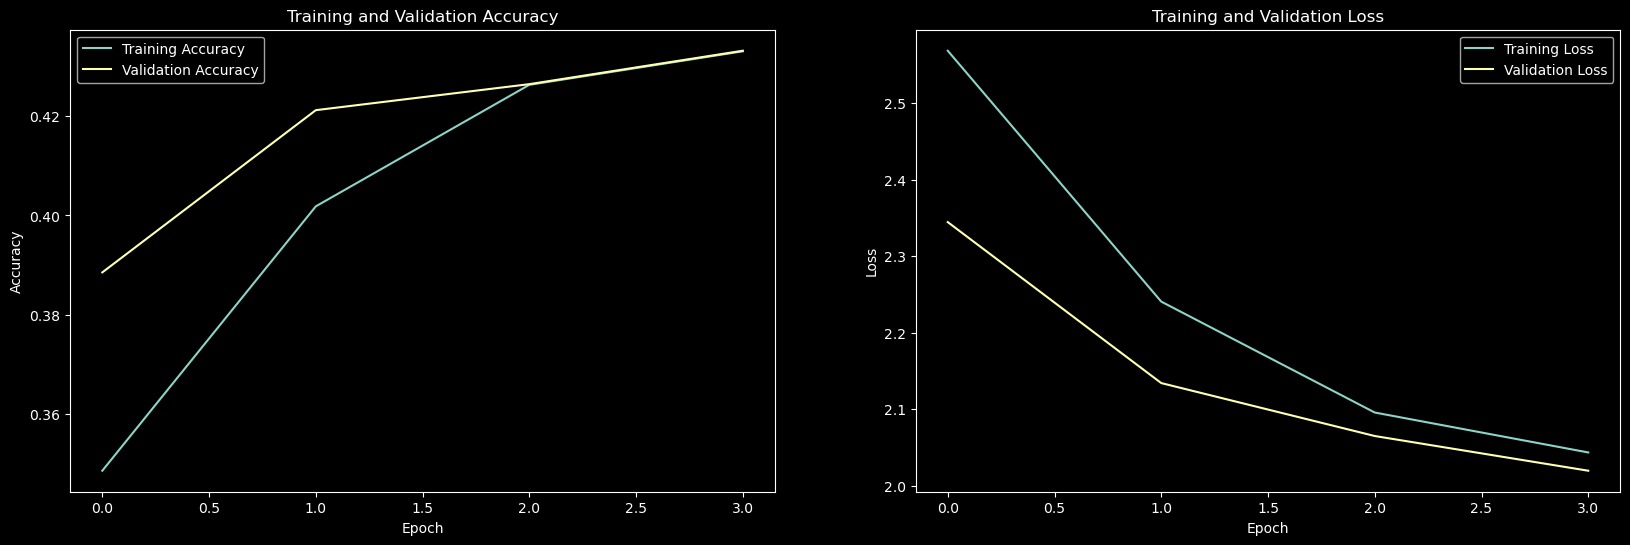

time: 204 ms (started: 2024-07-13 08:16:07 +03:00)


In [24]:
plot_results(goemotions_train_losses_classifier)

- Unfreeze some layers and Fine-tune

In [25]:
nb_of_layers_to_unfreeze = 1  # number of layers to unfreeze in the BERT model
lr_fine_tuning = 1e-5 
epochs_fine_tuning = 20 

# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n")
goemotions_train_losses_fine_tune = train_model(ClassificationBERT_,
                                                AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                                criterion,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loader=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=2)
print("- BERT Fine-tuning finished.\n") 

- Starting training model with 1 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:21<00:00,  2.87it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


- Training loss: 2.00 - Training acc: 0.44 - Validation loss: 1.84 - Validation acc: 0.47
 - lr: 9.5e-06
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.94it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 1.77 - Training acc: 0.49 - Validation loss: 1.71 - Validation acc: 0.51
 - lr: 9e-06
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:19<00:00,  2.94it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch: 4 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.91it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


- Training loss: 1.54 - Training acc: 0.55 - Validation loss: 1.54 - Validation acc: 0.55
 - lr: 8.000000000000001e-06
Epoch: 5 
Training: 

100%|██████████| 235/235 [01:19<00:00,  2.95it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


Epoch: 6 
Training: 

100%|██████████| 235/235 [01:21<00:00,  2.89it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.48it/s]


- Training loss: 1.43 - Training acc: 0.58 - Validation loss: 1.46 - Validation acc: 0.57
 - lr: 7e-06
Epoch: 7 
Training: 

100%|██████████| 235/235 [01:19<00:00,  2.94it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.49it/s]


Epoch: 8 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.93it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


- Training loss: 1.36 - Training acc: 0.60 - Validation loss: 1.41 - Validation acc: 0.58
 - lr: 6e-06
Epoch: 9 
Training: 

100%|██████████| 235/235 [01:20<00:00,  2.91it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch: 10 
Training: 

100%|██████████| 235/235 [01:21<00:00,  2.87it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


- Training loss: 1.31 - Training acc: 0.61 - Validation loss: 1.39 - Validation acc: 0.58
 - lr: 5e-06
Epoch: 11 
Training: 

100%|██████████| 235/235 [01:22<00:00,  2.86it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]

Early stopping after 3 epochs without improvement.
- Training loss: 1.29 - Training acc: 0.62 - Validation loss: 1.39 - Validation acc: 0.58
 - lr: 4.5e-06
- BERT Fine-tuning finished.

time: 18min 30s (started: 2024-07-13 08:16:15 +03:00)


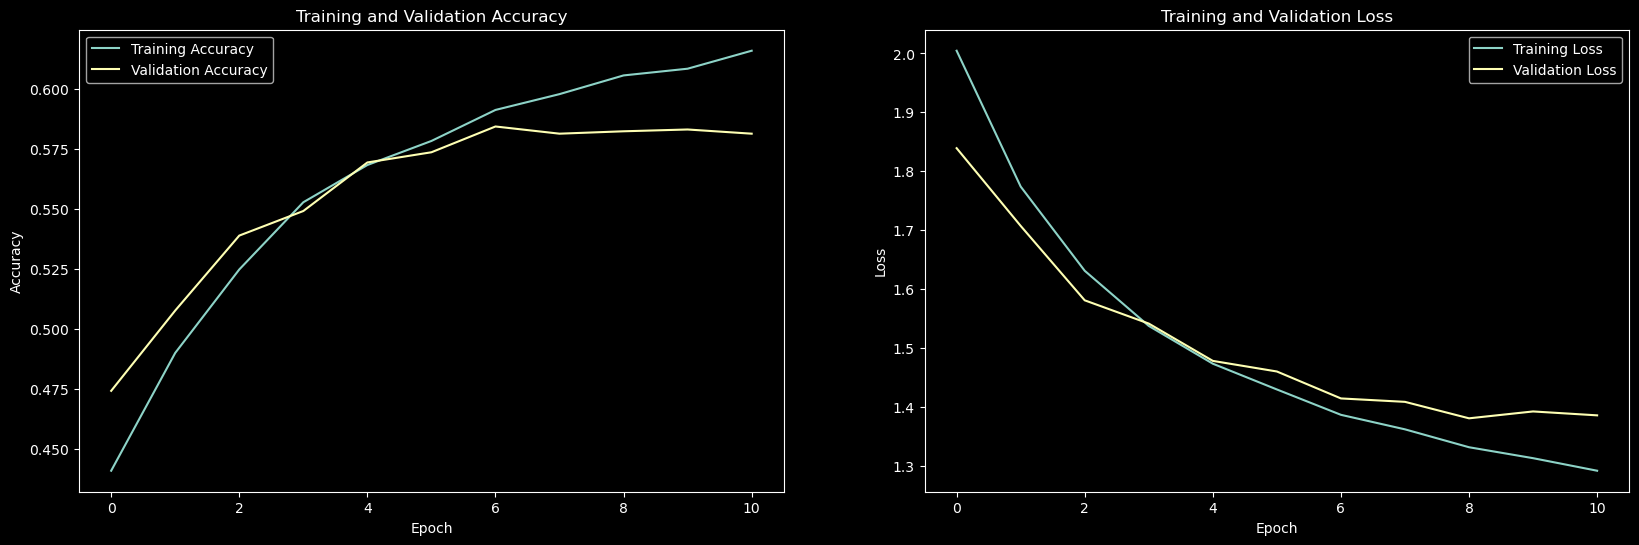

time: 157 ms (started: 2024-07-13 08:34:45 +03:00)


In [26]:
plot_results(goemotions_train_losses_fine_tune) 

In [28]:
test_resutls = evaluate_model(ClassificationBERT_,
                              goemotions_test_loader, 
                              criterion=criterion, 
                              loader_sampler=test_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.29it/s]

Test loss: 1.39 Test acc: 0.60
time: 9.74 s (started: 2024-07-13 08:41:03 +03:00)


- The dataset of texts we have for classification using BERT is inherently limited in its ability to achieve an accuracy of more than 60%. This is due to the nature of the data and the complexity of the problem being addressed (28 classes).

- Train Classifier with BERT frozen (Unfreeze two layers):

In [29]:
epochs_train_classifier = 4 
lr_train_classifier = 1e-4 

bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels,dropout=0.5).to(DEVICE) 
# Freeze all, train classifier only
print("- Starting training model with BERT frozen.\n")

criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation

goemotions_train_losses_classifier = train_model(ClassificationBERT_, 
                                                 optimizer=AdamW(ClassificationBERT_.parameters(),lr=lr_train_classifier),
                                                 criterion= nn.CrossEntropyLoss(),
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loader=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,  
                                                 patience=2,                                               
                                                 verbose=True)

print("- Classifier training with BERT frozen is finished.\n")

- BERT downloaded.
- Starting training model with BERT freezed.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:12<00:00,  3.25it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.50it/s]


- Training loss: 2.55 - Training acc: 0.35 - Validation loss: 2.33 - Validation acc: 0.39
 - lr: 7.500000000000001e-05
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:10<00:00,  3.33it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


- Training loss: 2.23 - Training acc: 0.40 - Validation loss: 2.15 - Validation acc: 0.42
 - lr: 5e-05
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 2.09 - Training acc: 0.43 - Validation loss: 2.05 - Validation acc: 0.43
 - lr: 2.5e-05
Epoch: 4 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.47it/s]


- Training loss: 2.04 - Training acc: 0.43 - Validation loss: 2.03 - Validation acc: 0.43
 - lr: 0.0
- Classifier training with BERT frozen is finished.

time: 6min 13s (started: 2024-07-13 08:46:12 +03:00)


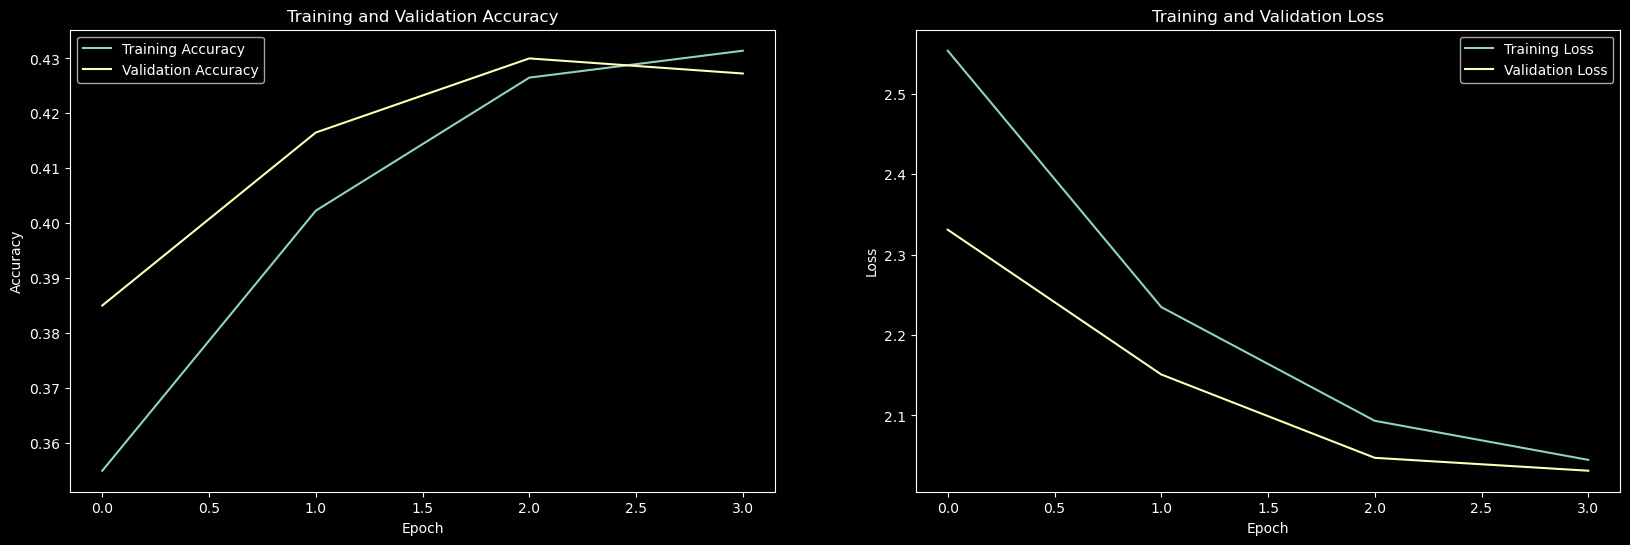

time: 282 ms (started: 2024-07-13 08:52:25 +03:00)


In [30]:
plot_results(goemotions_train_losses_classifier)

- Unfreeze some layers and Fine-tune

In [31]:
nb_of_layers_to_unfreeze = 2  # number of layers to unfreeze in the BERT model
lr_fine_tuning = 1e-5 
epochs_fine_tuning = 20 

# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n")
goemotions_train_losses_fine_tune = train_model(ClassificationBERT_,
                                                AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                                criterion,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loader=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=2)
print("- BERT Fine-tuning finished.\n") 

- Starting training model with 2 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:34<00:00,  2.49it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


- Training loss: 1.93 - Training acc: 0.46 - Validation loss: 1.70 - Validation acc: 0.51
 - lr: 9.5e-06
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:31<00:00,  2.56it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 1.61 - Training acc: 0.53 - Validation loss: 1.54 - Validation acc: 0.56
 - lr: 9e-06
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:31<00:00,  2.56it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch: 4 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.58it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


- Training loss: 1.39 - Training acc: 0.59 - Validation loss: 1.44 - Validation acc: 0.58
 - lr: 8.000000000000001e-06
Epoch: 5 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.44it/s]


Epoch: 6 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 1.28 - Training acc: 0.62 - Validation loss: 1.38 - Validation acc: 0.59
 - lr: 7e-06
Epoch: 7 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


Epoch: 8 
Training: 

100%|██████████| 235/235 [01:30<00:00,  2.59it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 1.21 - Training acc: 0.64 - Validation loss: 1.35 - Validation acc: 0.59
 - lr: 6e-06
Epoch: 9 
Training: 

100%|██████████| 235/235 [01:32<00:00,  2.54it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.26it/s]

Early stopping after 3 epochs without improvement.
- Training loss: 1.18 - Training acc: 0.65 - Validation loss: 1.34 - Validation acc: 0.60
 - lr: 5.500000000000001e-06
- BERT Fine-tuning finished.

time: 16min 44s (started: 2024-07-13 08:52:25 +03:00)


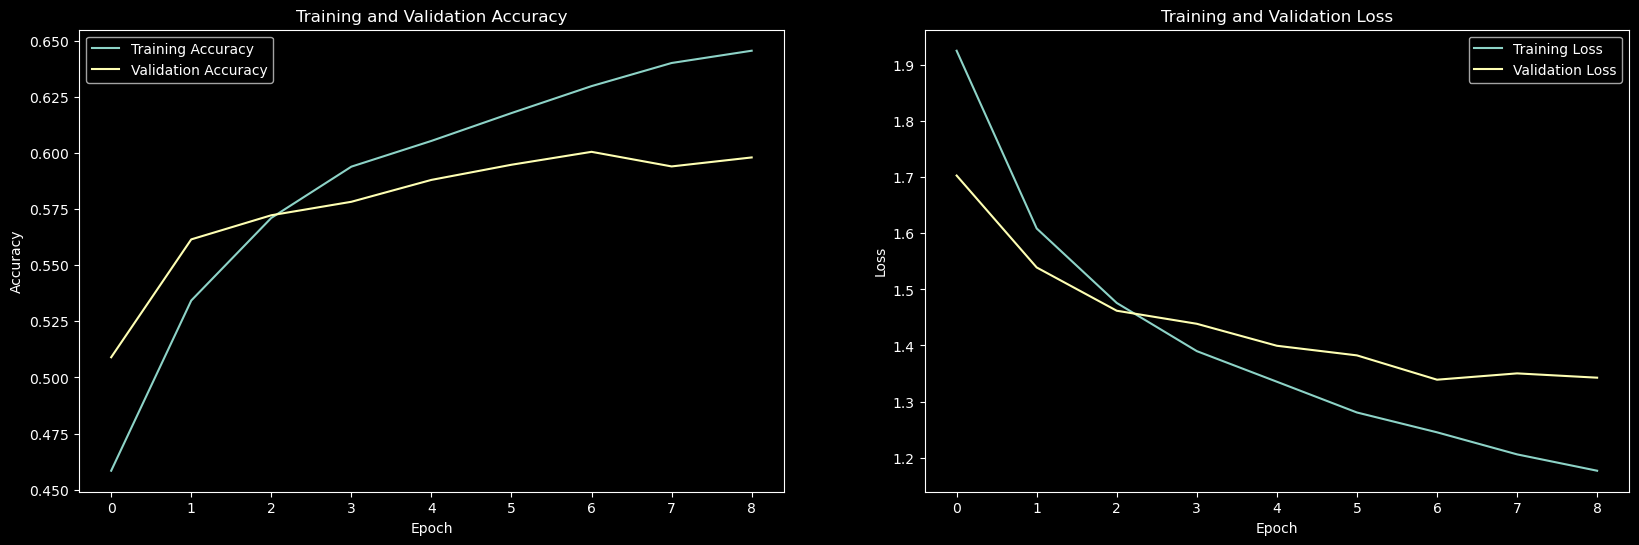

time: 156 ms (started: 2024-07-13 09:09:10 +03:00)


In [32]:
plot_results(goemotions_train_losses_fine_tune) 

In [33]:
test_resutls = evaluate_model(ClassificationBERT_,
                              goemotions_test_loader, 
                              criterion=criterion, 
                              loader_sampler=test_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 32/32 [00:10<00:00,  3.00it/s]

Test loss: 1.33 Test acc: 0.61
time: 10.7 s (started: 2024-07-13 09:09:10 +03:00)


- Train Classifier with BERT frozen (Unfreeze three layers):

In [34]:
epochs_train_classifier = 4 
lr_train_classifier = 1e-4 

bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_ = ClassificationBERT(bert, num_labels=num_labels,dropout=0.5).to(DEVICE) 
# Freeze all, train classifier only
print("- Starting training model with BERT frozen.\n")

criterion = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation

goemotions_train_losses_classifier = train_model(ClassificationBERT_, 
                                                 optimizer=AdamW(ClassificationBERT_.parameters(),lr=lr_train_classifier),
                                                 criterion= nn.CrossEntropyLoss(),
                                                 epochs=epochs_train_classifier,
                                                 train_loader=goemotions_train_loader,
                                                 validation_loader=goemotions_val_loader,
                                                 train_loader_sampler=train_random_sampler,
                                                 validation_loader_sampler=val_random_sampler,  
                                                 patience=2,                                               
                                                 verbose=True)

print("- Classifier training with BERT frozen is finished.\n")

- BERT downloaded.
- Starting training model with BERT freezed.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:13<00:00,  3.22it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.42it/s]


- Training loss: 2.58 - Training acc: 0.35 - Validation loss: 2.34 - Validation acc: 0.38
 - lr: 7.500000000000001e-05
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.45it/s]


- Training loss: 2.24 - Training acc: 0.40 - Validation loss: 2.15 - Validation acc: 0.41
 - lr: 5e-05
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.38it/s]


- Training loss: 2.10 - Training acc: 0.43 - Validation loss: 2.05 - Validation acc: 0.43
 - lr: 2.5e-05
Epoch: 4 
Training: 

100%|██████████| 235/235 [01:11<00:00,  3.28it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.46it/s]


- Training loss: 2.05 - Training acc: 0.43 - Validation loss: 2.03 - Validation acc: 0.43
 - lr: 0.0
- Classifier training with BERT frozen is finished.

time: 6min 13s (started: 2024-07-13 09:26:23 +03:00)


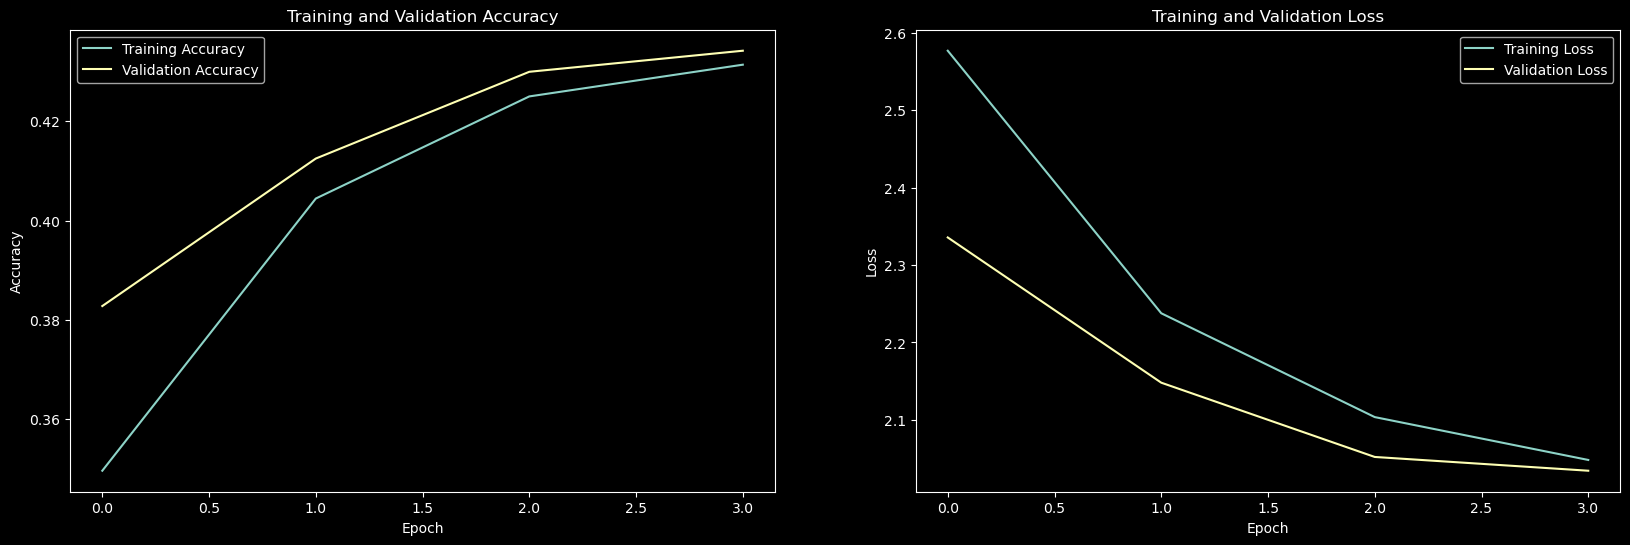

time: 250 ms (started: 2024-07-13 09:32:37 +03:00)


In [35]:
plot_results(goemotions_train_losses_classifier)

- Unfreeze some layers and Fine-tune

In [36]:
nb_of_layers_to_unfreeze = 3  # number of layers to unfreeze in the BERT model
lr_fine_tuning = 1e-5 
epochs_fine_tuning = 20 

# Unfreeze certain layers and train encoder layers
unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze)
print(f"- Starting training model with {nb_of_layers_to_unfreeze} layers unfrozen.\n")
goemotions_train_losses_fine_tune = train_model(ClassificationBERT_,
                                                AdamW(ClassificationBERT_.parameters(),lr=lr_fine_tuning),
                                                criterion,
                                                epochs=epochs_fine_tuning,
                                                train_loader=goemotions_train_loader,
                                                validation_loader=goemotions_val_loader,
                                                train_loader_sampler=train_random_sampler,
                                                validation_loader_sampler=val_random_sampler,
                                                verbose=True,
                                                patience=2)
print("- BERT Fine-tuning finished.\n") 

- Starting training model with 3 layers unfrozen.

Epoch: 1 
Training: 

100%|██████████| 235/235 [01:45<00:00,  2.23it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.32it/s]


- Training loss: 1.85 - Training acc: 0.48 - Validation loss: 1.63 - Validation acc: 0.52
 - lr: 9.5e-06
Epoch: 2 
Training: 

100%|██████████| 235/235 [01:42<00:00,  2.30it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.43it/s]


- Training loss: 1.52 - Training acc: 0.55 - Validation loss: 1.46 - Validation acc: 0.57
 - lr: 9e-06
Epoch: 3 
Training: 

100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch: 4 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.37it/s]


- Training loss: 1.32 - Training acc: 0.61 - Validation loss: 1.36 - Validation acc: 0.60
 - lr: 8.000000000000001e-06
Epoch: 5 
Training: 

100%|██████████| 235/235 [01:42<00:00,  2.29it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.30it/s]


Epoch: 6 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.35it/s]


- Training loss: 1.19 - Training acc: 0.64 - Validation loss: 1.33 - Validation acc: 0.60
 - lr: 7e-06
Epoch: 7 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch: 8 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.27it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.31it/s]


- Training loss: 1.10 - Training acc: 0.67 - Validation loss: 1.30 - Validation acc: 0.60
 - lr: 6e-06
Epoch: 9 
Training: 

100%|██████████| 235/235 [01:43<00:00,  2.26it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.34it/s]


Epoch: 10 
Training: 

100%|██████████| 235/235 [01:47<00:00,  2.19it/s]


Evaluating: 

100%|██████████| 32/32 [00:09<00:00,  3.42it/s]

Early stopping after 3 epochs without improvement.
- Training loss: 1.02 - Training acc: 0.69 - Validation loss: 1.35 - Validation acc: 0.60
 - lr: 5e-06
- BERT Fine-tuning finished.

time: 20min 42s (started: 2024-07-13 09:32:37 +03:00)


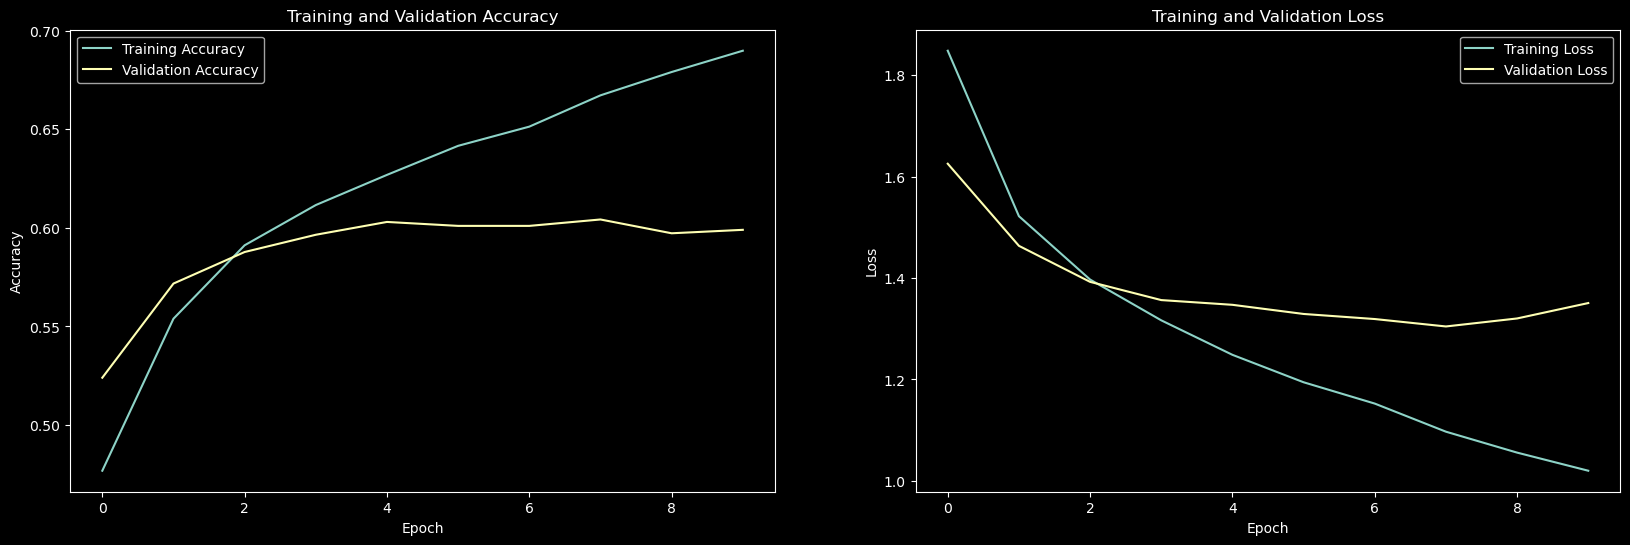

time: 219 ms (started: 2024-07-13 09:53:20 +03:00)


In [37]:
plot_results(goemotions_train_losses_fine_tune) 

In [38]:
test_resutls = evaluate_model(ClassificationBERT_,
                              goemotions_test_loader, 
                              criterion=criterion, 
                              loader_sampler=test_random_sampler, 
                              versbose=True)

Evaluating: 

100%|██████████| 32/32 [00:10<00:00,  2.96it/s]

Test loss: 1.33 Test acc: 0.61
time: 10.8 s (started: 2024-07-13 09:53:21 +03:00)


In [40]:
count_parameters(ClassificationBERT_)

Number of parameters: 109503772
time: 0 ns (started: 2024-07-13 10:18:17 +03:00)


### Scouts & Guidance matrix::

Things to be done:

1) We start from a pre-trained model, M. We unfreeze all the parameters.

2) Next, we split the data set into two separate data sets, one with 18 classes (dataset A) and the other with the remaining 10 classes (dataset B).

3) We then create 10 scouts out of dataset A only. We make sure that each scout has only 10 classes randomly picked from the 18 classes of dataset A. Each scout is trained as transfer learning starting from model M.

4) Next, we create the guiding matrix using the parameters of M and of the ten scouts.

5) After that, we use dataset B only as our downstream task. In this task, we start again with model M.

6) (a) We train the model with the 10 classes of dataset B using the guidance matrix. For this training, we use only a single example -- one-shot learning. The rest of the data are used for testing.

6) (b) We do the same as in 6a but without using the guidance matrix.

7) We compare the results obtained in 6a and 6b.


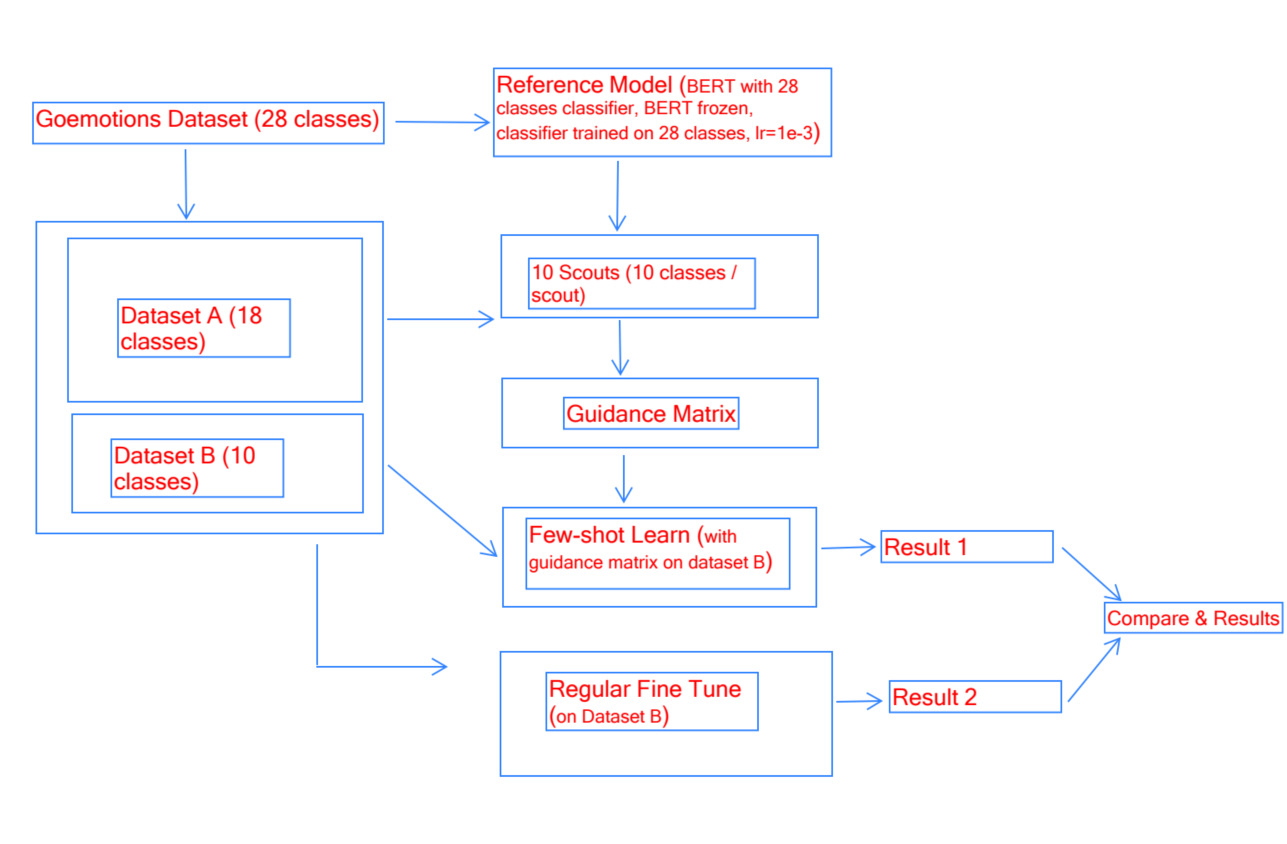

In [22]:
# take 8 labels for downstream task # train on the the remaining 20   # 5 scouts each with 8 labels. scout_indexes, 
# scout_indexes = [[0,1,2,3,4,5,6,7], [8,9,10,11,12,13,14,15] , [16,17,18,19,0,1,2,3], [etc.]] 
# 
# # lr_fine_tuning = 5e-5
# epochs_fine_tuning = 8 

time: 0 ns (started: 2024-07-15 15:56:33 +03:00)


### Create Reference Model: classifier should not be trained at all 

In [20]:
num_labels = 10  # number of labels in the datasetclass_indices = list(range(28))

bert_reference = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
print("- BERT downloaded.")
ClassificationBERT_reference = ClassificationBERT(bert, num_labels=num_labels, dropout=0.5).to(DEVICE)
nb_of_layers_to_unfreeze = 1  # number of layers to unfreeze in the BERT model
print(f"{nb_of_layers_to_unfreeze} layer(s) from BERT unfreezed")
unfreeze_BERT_layers(bert_reference, nb_of_layers_to_unfreeze)

- BERT downloaded.
1 layer(s) from BERT unfreezed


- Save reference model (once) to load each time 

In [142]:
# # Save the model's state dictionary
# torch.save(ClassificationBERT_reference.state_dict(), 'C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt')

time: 0 ns (started: 2024-07-18 10:23:58 +03:00)


- Load model

In [21]:
ClassificationBERT_reference.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))

<All keys matched successfully>

### Create scouts 

In [144]:
my_scouts = gtl.create_scouts(ClassificationBERT_reference, should_save_guidance=True, should_save_scouts=False, use_squared_differences=True)
print("Scouts created")

Scouts created
time: 328 ms (started: 2024-07-18 10:24:02 +03:00)


- Choose random classes to create Dataset A (18 classes) and Dataset B (10 classes)

In [145]:
# choose random classes for datasets A and B: A 18 classes and B 10 classes
random_classes_A = random.sample(range(0,27), 18); random_classes_A.sort();
random_classes_B = [ i for i in range(28) if i not in random_classes_A]; random_classes_A.sort();  

print('Random classes for Dataset A: ', random_classes_A)
print('Random classes for Dataset B: ', random_classes_B)

Random classes for Dataset A:  [0, 2, 4, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 25]
Random classes for Dataset B:  [1, 3, 5, 6, 8, 19, 21, 23, 26, 27]
time: 0 ns (started: 2024-07-18 10:24:10 +03:00)


In [146]:
random_classes_A =  [1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 16, 17, 19, 20, 21, 24, 26] 
random_classes_B = [0, 4, 8, 10, 13, 18, 22, 23, 25, 27] 

time: 0 ns (started: 2024-07-18 10:24:12 +03:00)


### Train Scouts:

Start training :

Scout nb 1/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 1097/1097 [00:00<00:00, 4975.44 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 67/67 [00:23<00:00,  2.86it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


# Evaluation loss: 1.84 Evaluation acc: 0.43
- Training loss: 2.12 - Training acc: 0.24 - Validation loss: 1.84 - Validation acc: 0.43

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 67/67 [00:22<00:00,  2.99it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


# Evaluation loss: 1.38 Evaluation acc: 0.53
- Training loss: 1.63 - Training acc: 0.48 - Validation loss: 1.38 - Validation acc: 0.53

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 67/67 [00:22<00:00,  3.00it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


# Evaluation loss: 1.17 Evaluation acc: 0.61
- Training loss: 1.31 - Training acc: 0.58 - Validation loss: 1.17 - Validation acc: 0.61

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 67/67 [00:22<00:00,  3.00it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


# Evaluation loss: 1.06 Evaluation acc: 0.64
- Training loss: 1.14 - Training acc: 0.64 - Validation loss: 1.06 - Validation acc: 0.64

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 67/67 [00:22<00:00,  2.99it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.56it/s]


# Evaluation loss: 1.04 Evaluation acc: 0.65
- Training loss: 1.06 - Training acc: 0.66 - Validation loss: 1.04 - Validation acc: 0.65



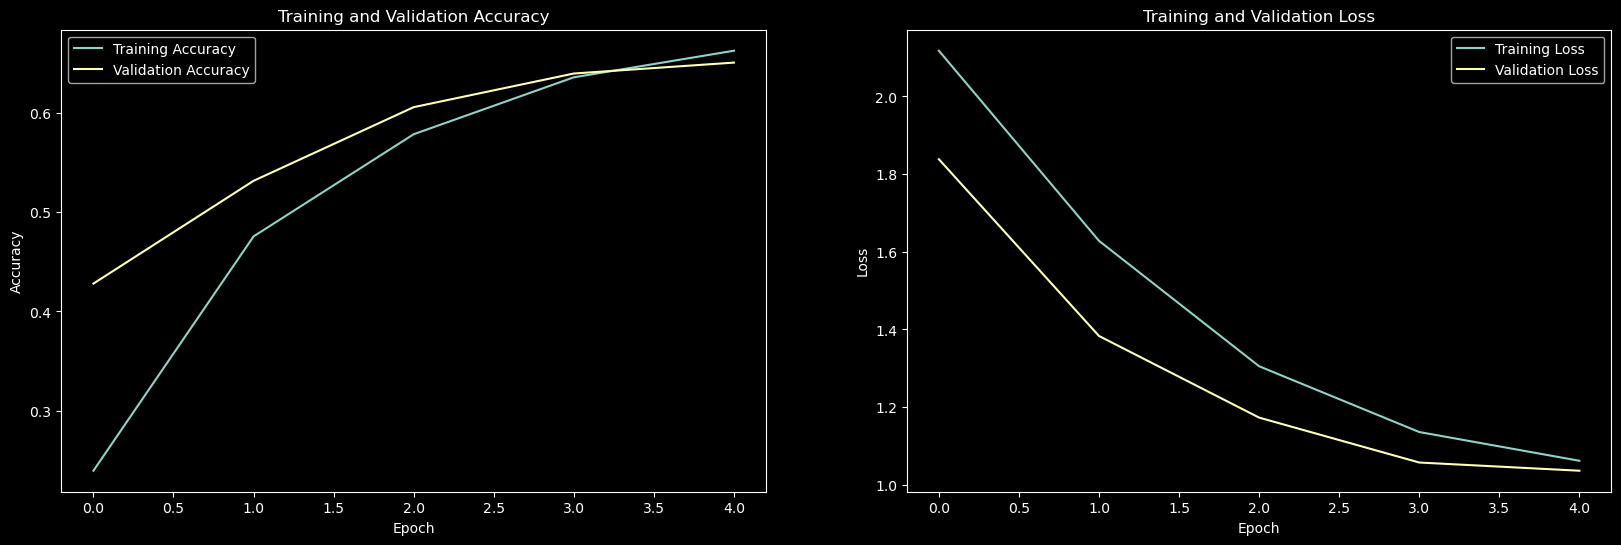

# Evaluating on Test Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


# Test loss: 1.06 Test acc: 0.64

# Scout nb 1/10 Training End.

Scout nb 2/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 1254/1254 [00:00<00:00, 2284.20 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 76/76 [00:26<00:00,  2.85it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.50it/s]


# Evaluation loss: 1.93 Evaluation acc: 0.39
- Training loss: 2.19 - Training acc: 0.22 - Validation loss: 1.93 - Validation acc: 0.39

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 76/76 [00:25<00:00,  2.97it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]


# Evaluation loss: 1.44 Evaluation acc: 0.52
- Training loss: 1.68 - Training acc: 0.44 - Validation loss: 1.44 - Validation acc: 0.52

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 76/76 [00:25<00:00,  2.96it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


# Evaluation loss: 1.20 Evaluation acc: 0.60
- Training loss: 1.31 - Training acc: 0.56 - Validation loss: 1.20 - Validation acc: 0.60

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 76/76 [00:25<00:00,  2.97it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.48it/s]


# Evaluation loss: 1.10 Evaluation acc: 0.63
- Training loss: 1.15 - Training acc: 0.63 - Validation loss: 1.10 - Validation acc: 0.63

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 76/76 [00:25<00:00,  2.96it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


# Evaluation loss: 1.07 Evaluation acc: 0.64
- Training loss: 1.08 - Training acc: 0.65 - Validation loss: 1.07 - Validation acc: 0.64



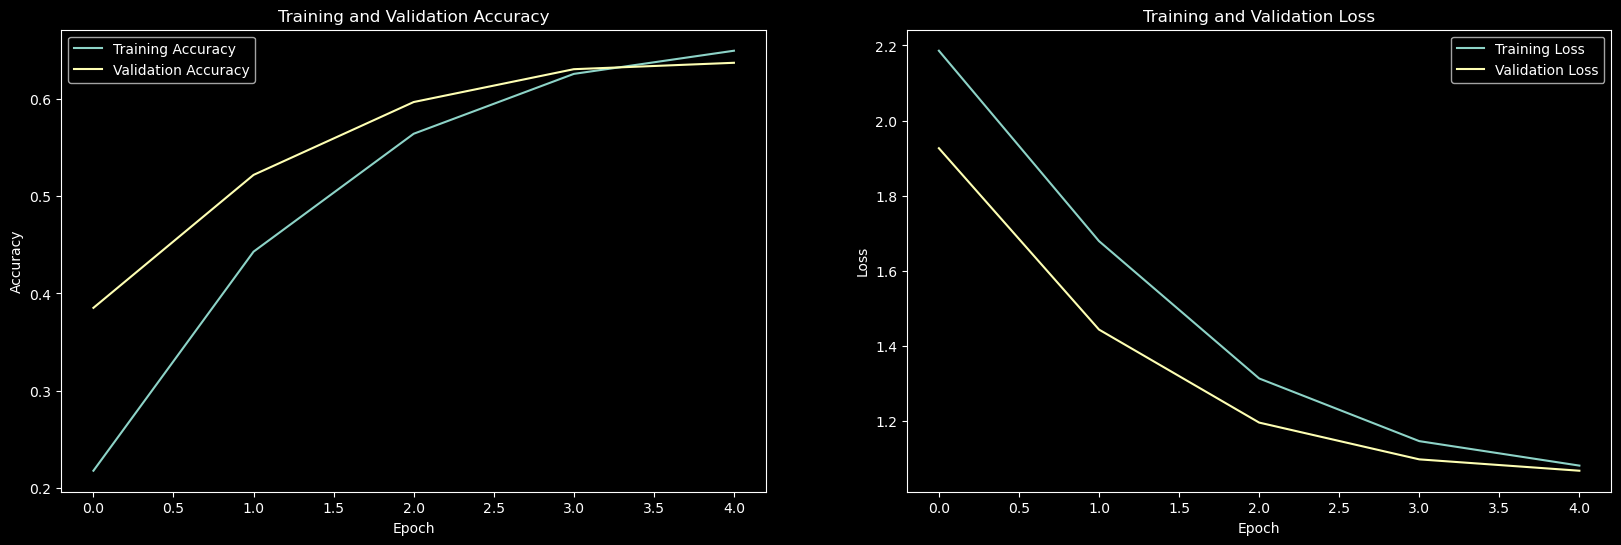

# Evaluating on Test Dateset: 

100%|██████████| 10/10 [00:03<00:00,  3.15it/s]


# Test loss: 1.08 Test acc: 0.64

# Scout nb 2/10 Training End.

Scout nb 3/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 978/978 [00:00<00:00, 5121.13 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 59/59 [00:20<00:00,  2.84it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.52it/s]


# Evaluation loss: 1.73 Evaluation acc: 0.51
- Training loss: 2.03 - Training acc: 0.28 - Validation loss: 1.73 - Validation acc: 0.51

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 59/59 [00:20<00:00,  2.95it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


# Evaluation loss: 1.22 Evaluation acc: 0.62
- Training loss: 1.48 - Training acc: 0.59 - Validation loss: 1.22 - Validation acc: 0.62

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 59/59 [00:19<00:00,  2.95it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


# Evaluation loss: 1.00 Evaluation acc: 0.69
- Training loss: 1.11 - Training acc: 0.65 - Validation loss: 1.00 - Validation acc: 0.69

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 59/59 [00:20<00:00,  2.94it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


# Evaluation loss: 0.92 Evaluation acc: 0.72
- Training loss: 0.97 - Training acc: 0.70 - Validation loss: 0.92 - Validation acc: 0.72

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 59/59 [00:20<00:00,  2.94it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.50it/s]


# Evaluation loss: 0.89 Evaluation acc: 0.73
- Training loss: 0.91 - Training acc: 0.72 - Validation loss: 0.89 - Validation acc: 0.73



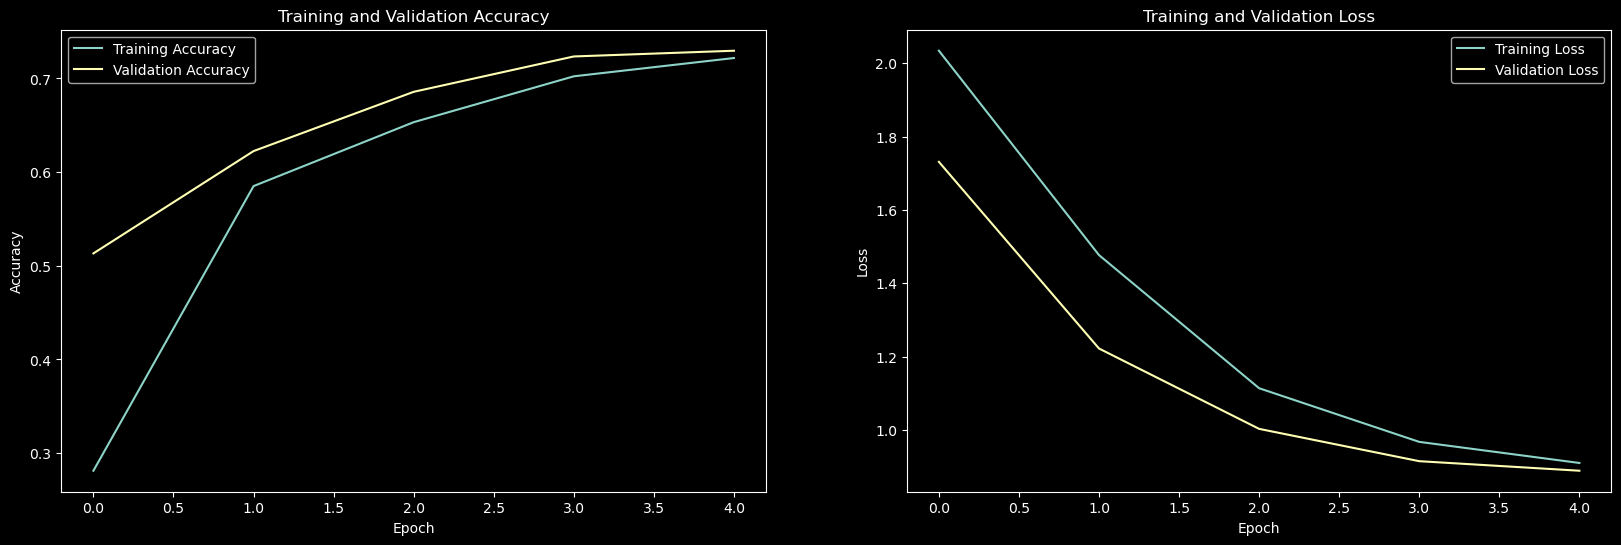

# Evaluating on Test Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


# Test loss: 0.90 Test acc: 0.71

# Scout nb 3/10 Training End.

Scout nb 4/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 1010/1010 [00:00<00:00, 4710.41 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 63/63 [00:21<00:00,  2.87it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.74it/s]


# Evaluation loss: 1.79 Evaluation acc: 0.47
- Training loss: 2.09 - Training acc: 0.25 - Validation loss: 1.79 - Validation acc: 0.47

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 63/63 [00:21<00:00,  2.96it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


# Evaluation loss: 1.29 Evaluation acc: 0.59
- Training loss: 1.51 - Training acc: 0.54 - Validation loss: 1.29 - Validation acc: 0.59

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 63/63 [00:21<00:00,  2.94it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


# Evaluation loss: 1.06 Evaluation acc: 0.64
- Training loss: 1.16 - Training acc: 0.62 - Validation loss: 1.06 - Validation acc: 0.64

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 63/63 [00:21<00:00,  2.92it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]


# Evaluation loss: 0.96 Evaluation acc: 0.67
- Training loss: 1.00 - Training acc: 0.67 - Validation loss: 0.96 - Validation acc: 0.67

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.41it/s]


# Evaluation loss: 0.95 Evaluation acc: 0.69
- Training loss: 0.94 - Training acc: 0.70 - Validation loss: 0.95 - Validation acc: 0.69



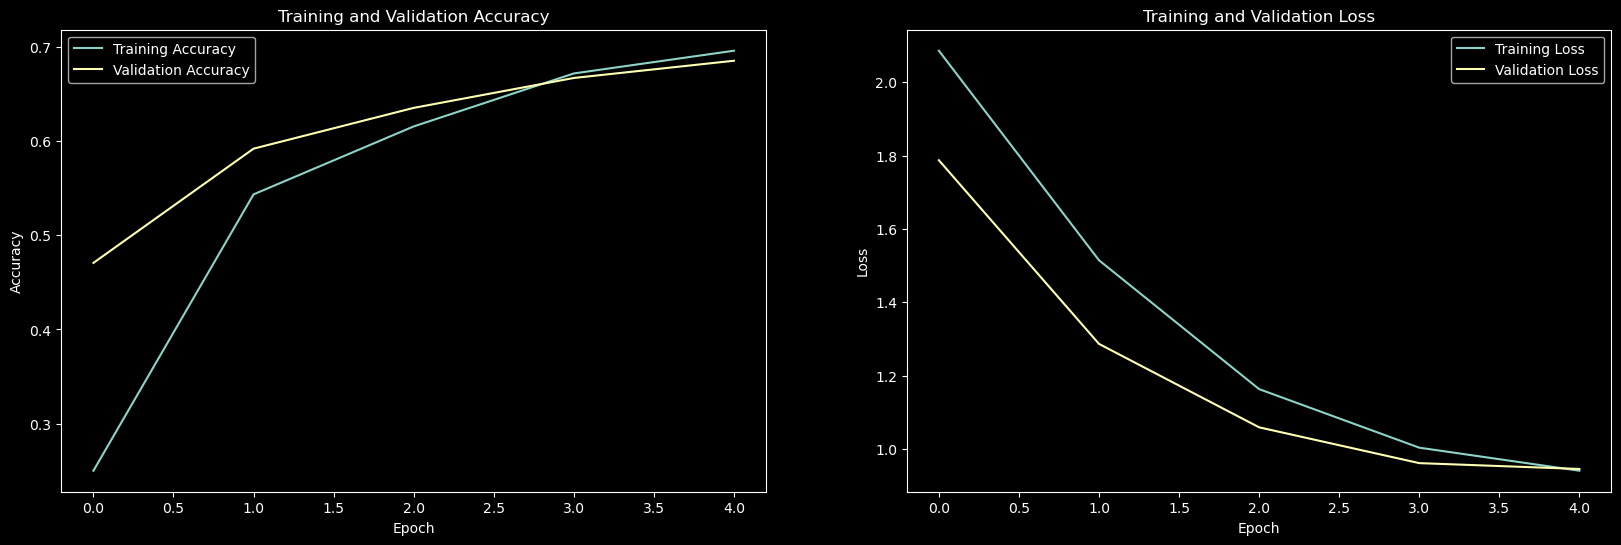

# Evaluating on Test Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


# Test loss: 0.92 Test acc: 0.71

# Scout nb 4/10 Training End.

Scout nb 5/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 1177/1177 [00:00<00:00, 4562.34 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 74/74 [00:27<00:00,  2.74it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


# Evaluation loss: 1.90 Evaluation acc: 0.39
- Training loss: 2.17 - Training acc: 0.21 - Validation loss: 1.90 - Validation acc: 0.39

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 74/74 [00:25<00:00,  2.86it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


# Evaluation loss: 1.45 Evaluation acc: 0.52
- Training loss: 1.68 - Training acc: 0.44 - Validation loss: 1.45 - Validation acc: 0.52

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 74/74 [00:26<00:00,  2.85it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


# Evaluation loss: 1.20 Evaluation acc: 0.61
- Training loss: 1.30 - Training acc: 0.59 - Validation loss: 1.20 - Validation acc: 0.61

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 74/74 [00:26<00:00,  2.83it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.37it/s]


# Evaluation loss: 1.08 Evaluation acc: 0.65
- Training loss: 1.12 - Training acc: 0.66 - Validation loss: 1.08 - Validation acc: 0.65

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 74/74 [00:26<00:00,  2.84it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


# Evaluation loss: 1.06 Evaluation acc: 0.66
- Training loss: 1.04 - Training acc: 0.68 - Validation loss: 1.06 - Validation acc: 0.66



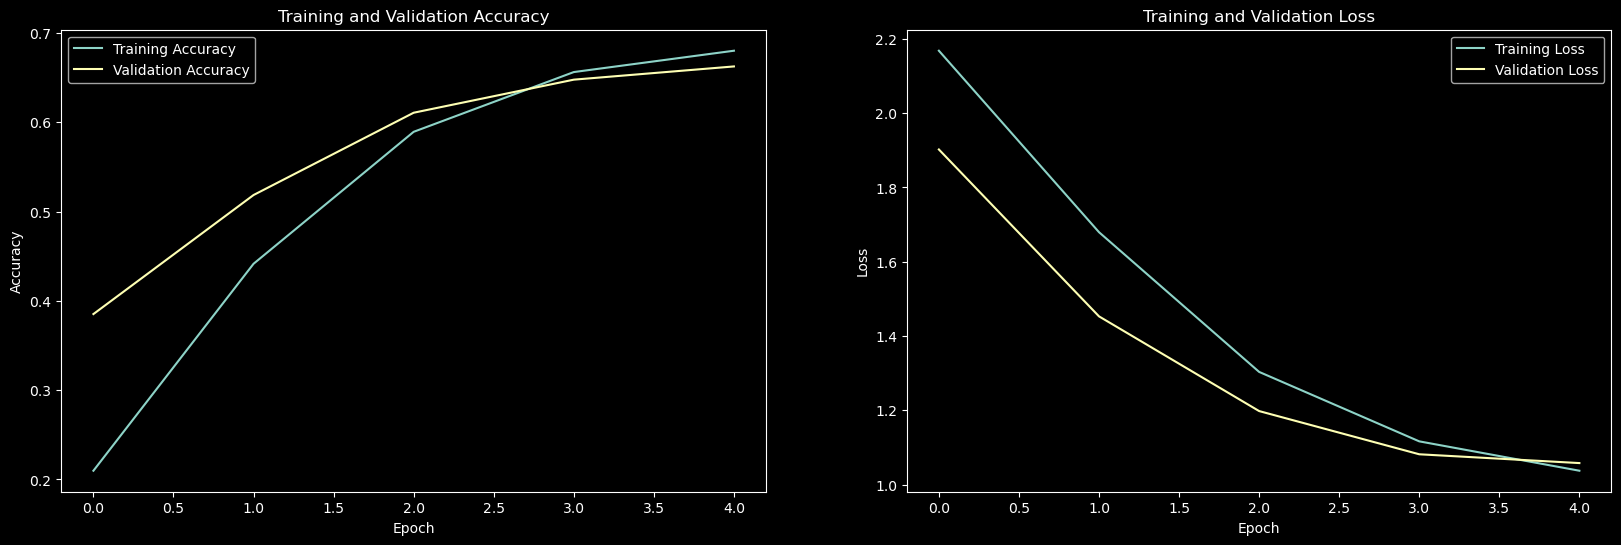

# Evaluating on Test Dateset: 

100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


# Test loss: 1.02 Test acc: 0.67

# Scout nb 5/10 Training End.

Scout nb 6/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 1042/1042 [00:00<00:00, 4877.11 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 63/63 [00:23<00:00,  2.74it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.59it/s]


# Evaluation loss: 1.76 Evaluation acc: 0.38
- Training loss: 2.10 - Training acc: 0.25 - Validation loss: 1.76 - Validation acc: 0.38

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 63/63 [00:22<00:00,  2.85it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.58it/s]


# Evaluation loss: 1.51 Evaluation acc: 0.49
- Training loss: 1.68 - Training acc: 0.42 - Validation loss: 1.51 - Validation acc: 0.49

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


# Evaluation loss: 1.24 Evaluation acc: 0.58
- Training loss: 1.38 - Training acc: 0.53 - Validation loss: 1.24 - Validation acc: 0.58

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 63/63 [00:22<00:00,  2.78it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


# Evaluation loss: 1.25 Evaluation acc: 0.62
- Training loss: 1.22 - Training acc: 0.60 - Validation loss: 1.25 - Validation acc: 0.62

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 63/63 [00:22<00:00,  2.80it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


# Evaluation loss: 1.37 Evaluation acc: 0.63
Early stopping after 3 epochs without improvement.
- Training loss: 1.16 - Training acc: 0.62 - Validation loss: 1.37 - Validation acc: 0.63
 


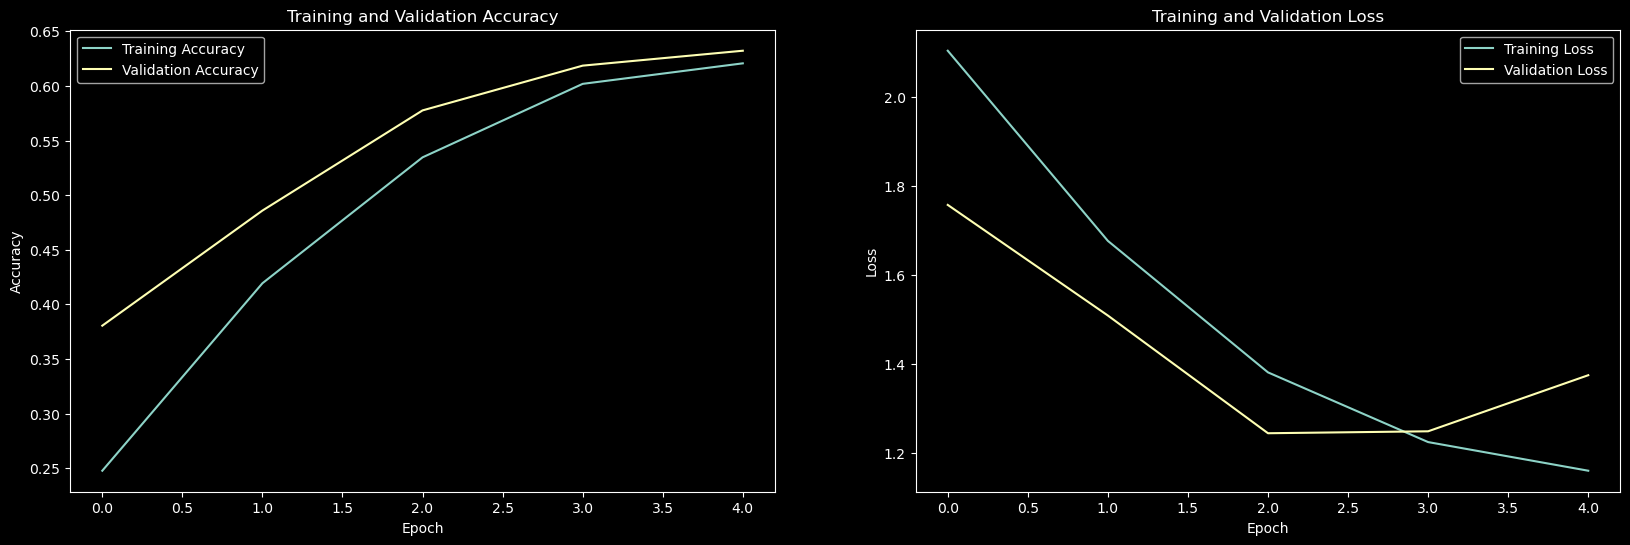

# Evaluating on Test Dateset: 

100%|██████████| 9/9 [00:02<00:00,  3.27it/s]


# Test loss: 1.20 Test acc: 0.61

# Scout nb 6/10 Training End.

Scout nb 7/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 778/778 [00:00<00:00, 4339.44 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 47/47 [00:17<00:00,  2.73it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 6/6 [00:01<00:00,  3.22it/s]


# Evaluation loss: 1.74 Evaluation acc: 0.37
- Training loss: 2.11 - Training acc: 0.24 - Validation loss: 1.74 - Validation acc: 0.37

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 47/47 [00:16<00:00,  2.85it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


# Evaluation loss: 1.40 Evaluation acc: 0.52
- Training loss: 1.62 - Training acc: 0.42 - Validation loss: 1.40 - Validation acc: 0.52

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 47/47 [00:16<00:00,  2.81it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 6/6 [00:01<00:00,  3.20it/s]


# Evaluation loss: 1.21 Evaluation acc: 0.61
- Training loss: 1.35 - Training acc: 0.55 - Validation loss: 1.21 - Validation acc: 0.61

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


# Evaluation loss: 1.12 Evaluation acc: 0.64
- Training loss: 1.21 - Training acc: 0.61 - Validation loss: 1.12 - Validation acc: 0.64

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 47/47 [00:16<00:00,  2.79it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 6/6 [00:01<00:00,  3.15it/s]


# Evaluation loss: 1.09 Evaluation acc: 0.65
- Training loss: 1.15 - Training acc: 0.63 - Validation loss: 1.09 - Validation acc: 0.65



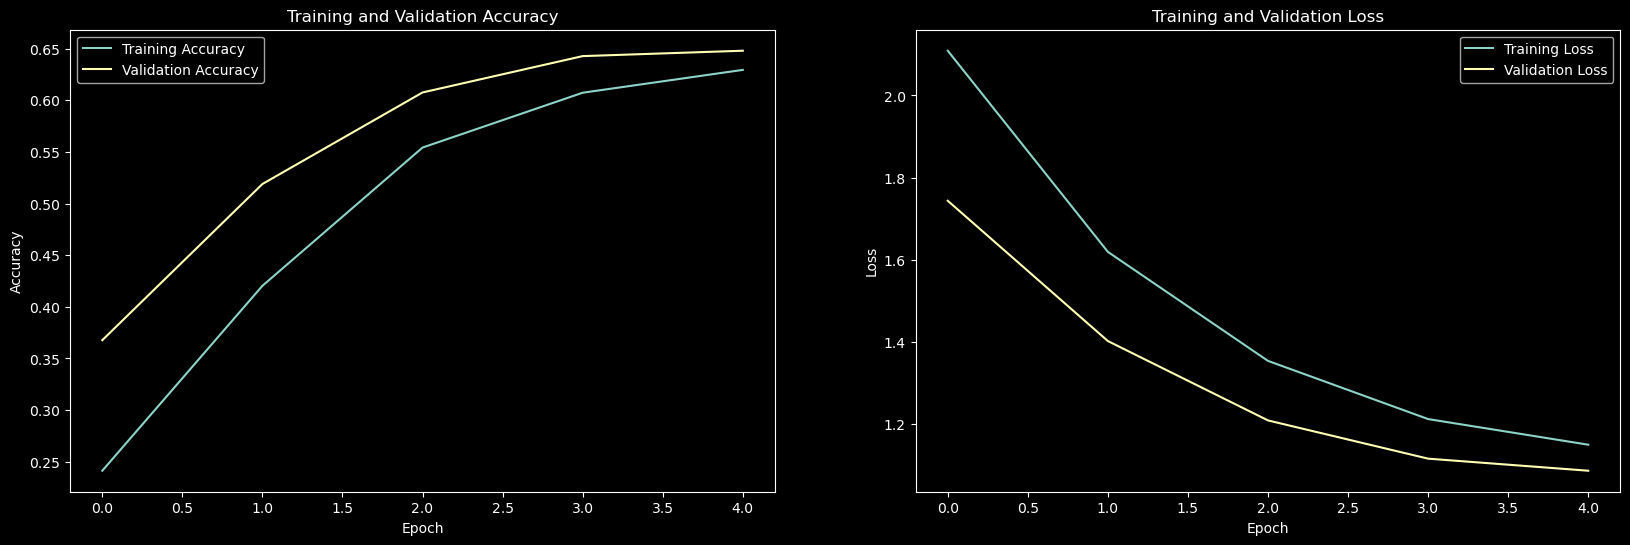

# Evaluating on Test Dateset: 

100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


# Test loss: 1.18 Test acc: 0.61

# Scout nb 7/10 Training End.

Scout nb 8/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 989/989 [00:00<00:00, 4250.59 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 63/63 [00:24<00:00,  2.61it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


# Evaluation loss: 1.98 Evaluation acc: 0.37
- Training loss: 2.14 - Training acc: 0.20 - Validation loss: 1.98 - Validation acc: 0.37

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 63/63 [00:23<00:00,  2.69it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


# Evaluation loss: 1.62 Evaluation acc: 0.45
- Training loss: 1.79 - Training acc: 0.42 - Validation loss: 1.62 - Validation acc: 0.45

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 63/63 [00:22<00:00,  2.76it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.38it/s]


# Evaluation loss: 1.41 Evaluation acc: 0.51
- Training loss: 1.48 - Training acc: 0.50 - Validation loss: 1.41 - Validation acc: 0.51

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 63/63 [00:22<00:00,  2.79it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.38it/s]


# Evaluation loss: 1.31 Evaluation acc: 0.54
- Training loss: 1.32 - Training acc: 0.55 - Validation loss: 1.31 - Validation acc: 0.54

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 63/63 [00:22<00:00,  2.76it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.37it/s]


# Evaluation loss: 1.28 Evaluation acc: 0.56
- Training loss: 1.26 - Training acc: 0.57 - Validation loss: 1.28 - Validation acc: 0.56



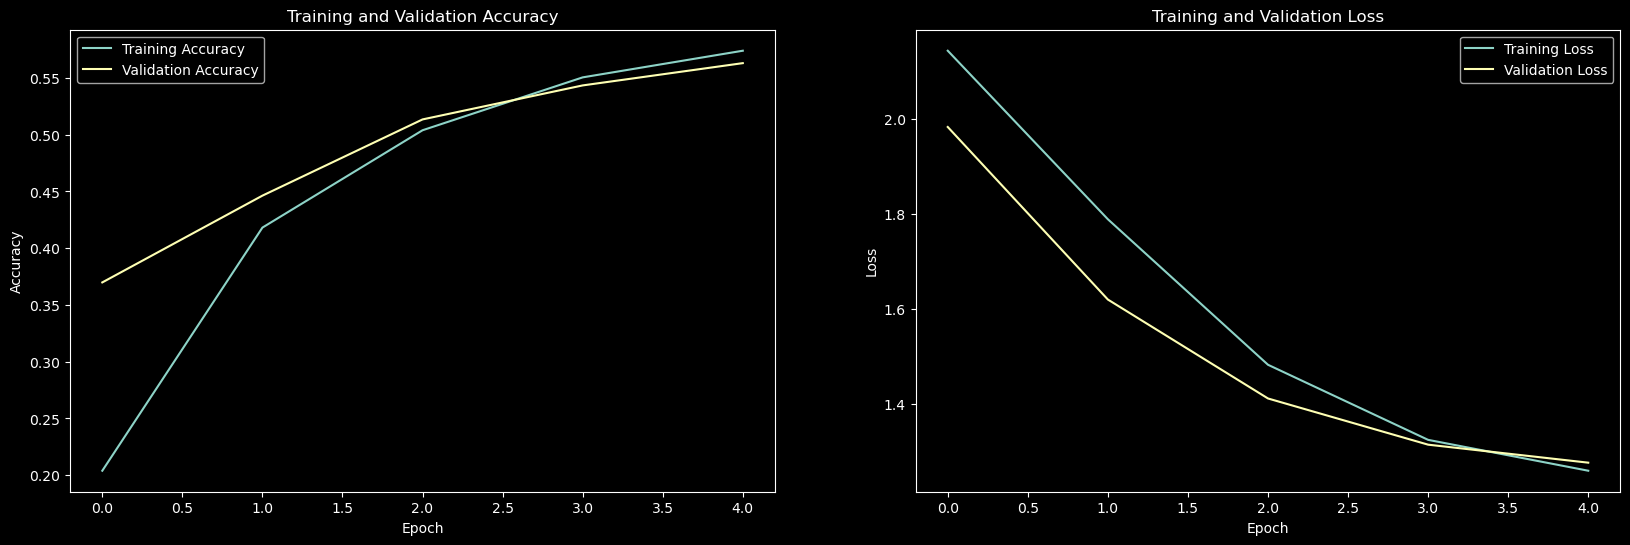

# Evaluating on Test Dateset: 

100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


# Test loss: 1.28 Test acc: 0.58

# Scout nb 8/10 Training End.

Scout nb 9/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 972/972 [00:00<00:00, 4885.20 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 59/59 [00:22<00:00,  2.64it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.59it/s]


# Evaluation loss: 1.82 Evaluation acc: 0.38
- Training loss: 2.12 - Training acc: 0.23 - Validation loss: 1.82 - Validation acc: 0.38

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.58it/s]


# Evaluation loss: 1.48 Evaluation acc: 0.50
- Training loss: 1.66 - Training acc: 0.42 - Validation loss: 1.48 - Validation acc: 0.50

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 59/59 [00:20<00:00,  2.93it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


# Evaluation loss: 1.29 Evaluation acc: 0.58
- Training loss: 1.39 - Training acc: 0.54 - Validation loss: 1.29 - Validation acc: 0.58

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 59/59 [00:20<00:00,  2.94it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.57it/s]


# Evaluation loss: 1.18 Evaluation acc: 0.60
- Training loss: 1.24 - Training acc: 0.61 - Validation loss: 1.18 - Validation acc: 0.60

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 59/59 [00:20<00:00,  2.94it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.54it/s]


# Evaluation loss: 1.17 Evaluation acc: 0.61
- Training loss: 1.17 - Training acc: 0.62 - Validation loss: 1.17 - Validation acc: 0.61



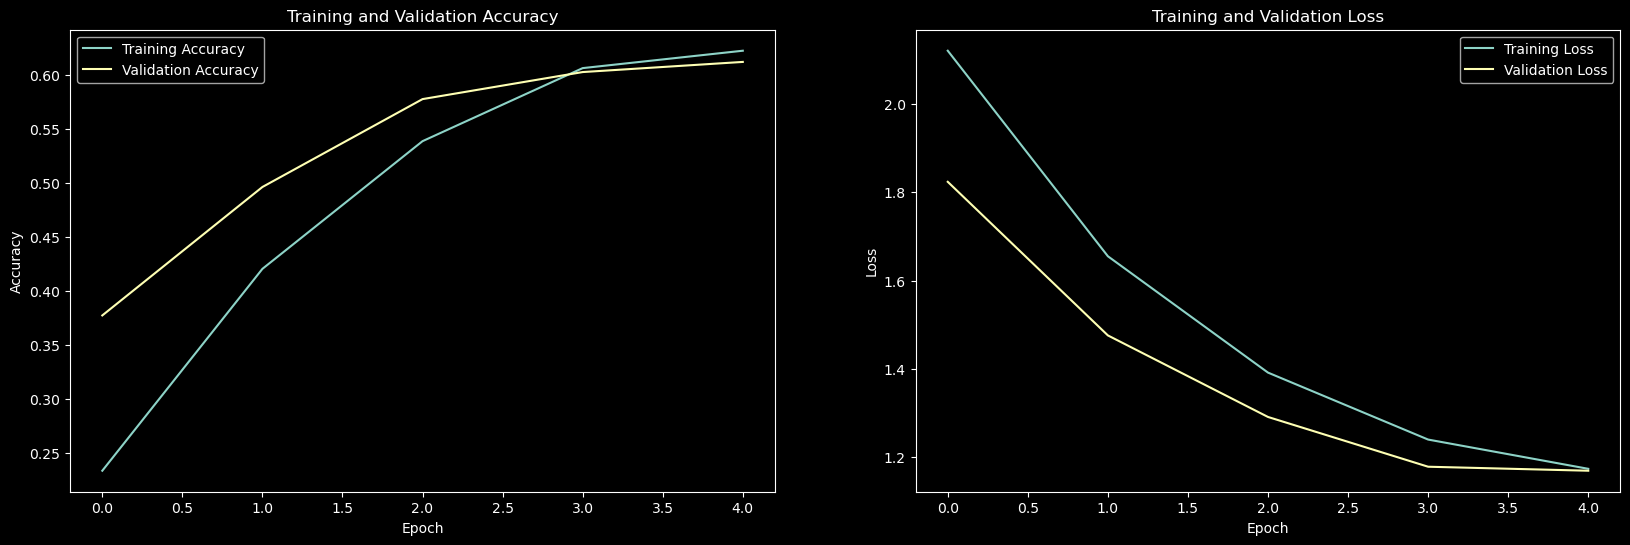

# Evaluating on Test Dateset: 

100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


# Test loss: 1.18 Test acc: 0.60

# Scout nb 9/10 Training End.

Scout nb 10/10 Training Start:
# Choosing 10 random classes from dataset A
# Filtering Dataset for selected labels:


Map: 100%|██████████| 976/976 [00:00<00:00, 2494.02 examples/s]


# BERT downloaded.
# BERT Reference Model loaded. Starting training model with 1 layer(s) unfrozen.
Epoch: 1 - Learning rate: 2e-05
Training: 

100%|██████████| 61/61 [00:23<00:00,  2.56it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


# Evaluation loss: 2.09 Evaluation acc: 0.29
- Training loss: 2.19 - Training acc: 0.19 - Validation loss: 2.09 - Validation acc: 0.29

Epoch: 2 - Learning rate: 1.6000000000000003e-05
Training: 

100%|██████████| 61/61 [00:21<00:00,  2.88it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.64it/s]


# Evaluation loss: 1.86 Evaluation acc: 0.38
- Training loss: 1.99 - Training acc: 0.31 - Validation loss: 1.86 - Validation acc: 0.38

Epoch: 3 - Learning rate: 1.2e-05
Training: 

100%|██████████| 61/61 [00:21<00:00,  2.89it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.58it/s]


# Evaluation loss: 1.64 Evaluation acc: 0.45
- Training loss: 1.73 - Training acc: 0.42 - Validation loss: 1.64 - Validation acc: 0.45

Epoch: 4 - Learning rate: 8.000000000000001e-06
Training: 

100%|██████████| 61/61 [00:21<00:00,  2.89it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


# Evaluation loss: 1.50 Evaluation acc: 0.51
- Training loss: 1.55 - Training acc: 0.48 - Validation loss: 1.50 - Validation acc: 0.51

Epoch: 5 - Learning rate: 4.000000000000001e-06
Training: 

100%|██████████| 61/61 [00:21<00:00,  2.89it/s]


# Evaluating on Evaluation Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.56it/s]


# Evaluation loss: 1.46 Evaluation acc: 0.52
- Training loss: 1.47 - Training acc: 0.51 - Validation loss: 1.46 - Validation acc: 0.52



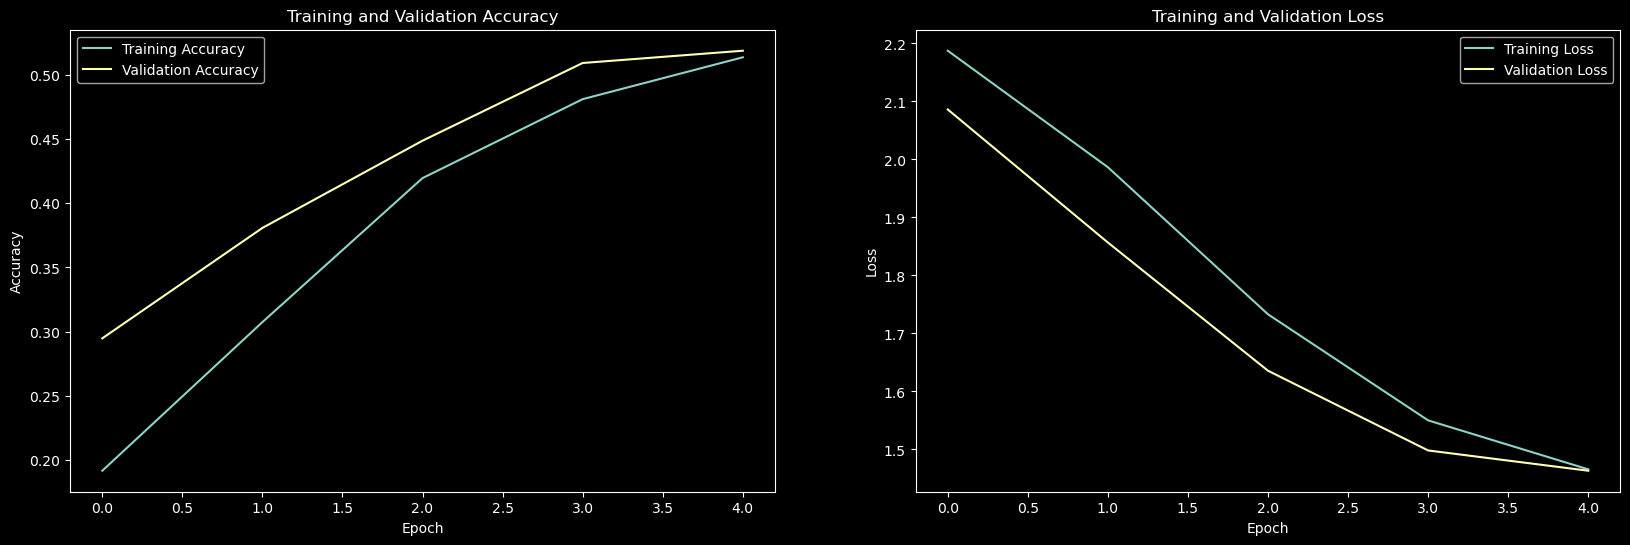

# Evaluating on Test Dateset: 

100%|██████████| 8/8 [00:02<00:00,  3.26it/s]

# Test loss: 1.51 Test acc: 0.49

# Scout nb 10/10 Training End.

All Scouts Training End.

time: 23min 22s (started: 2024-07-18 10:25:49 +03:00)


In [148]:
# num_labels = 10 #already defined in whe crating reference BERT_Classification_model
nb_scouts =  10
epochs = 5
patience  = 2 
batch_size = 128 
loss_function = nn.CrossEntropyLoss()  #combines the softmax activation function and the negative log-likelihood loss in a single operation
nb_of_layers_to_unfreeze = 1
dropout = 0.5
learning_rate = 2e-5

print("Start training :\n")
for i in range(nb_scouts): 
    print(f"=============================================================\nScout nb {i+1}/{nb_scouts} Training Start:")        
    # Take 10 random classes from the 18 classes in dataset A for the scout:
    print("# Choosing 10 random classes from dataset A")
    ten_random_classes = random.sample(random_classes_A, 10) 
    ten_random_classes.sort()
    ten_random_classes_np = np.array(ten_random_classes)
    ten_random_classes_np = ten_random_classes_np.reshape(len(ten_random_classes_np), 1)

    #create the function that preprocess the inputs for BERT and takes ten_random_classes and returns the new labels for the classes 
    goemotions_preprocess_wnewlabeling_function_A = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=ten_random_classes)

    # Choosing the data points that have only one label and the label is in the 10 random classes chosen from the 18 classes (Dataset A)
    print("# Filtering Dataset for selected labels:") 
    goemotions_train_dataset_ten_classes = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in ten_random_classes_np) 
    goemotions_val_dataset_ten_classes = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in ten_random_classes_np) 
    goemotions_test_dataset_ten_classes = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in ten_random_classes_np) 

    goemotions_train_dataset_ten_classes = goemotions_train_dataset_ten_classes.map(goemotions_preprocess_wnewlabeling_function_A, batched=True) 
    goemotions_val_dataset_ten_classes = goemotions_val_dataset_ten_classes.map(goemotions_preprocess_wnewlabeling_function_A, batched=True) 
    goemotions_test_dataset_ten_classes = goemotions_test_dataset_ten_classes.map(goemotions_preprocess_wnewlabeling_function_A, batched=True) 

    goemotions_train_dataset_ten_classes = CustomDatasetClass(goemotions_train_dataset_ten_classes) 
    goemotions_val_dataset_ten_classes = CustomDatasetClass(goemotions_val_dataset_ten_classes) 
    goemotions_test_dataset_ten_classes = CustomDatasetClass(goemotions_test_dataset_ten_classes) 

    # preparing the data loader from the ten classes dataset
    goemotions_train_loader_ten_classes = DataLoader(goemotions_train_dataset_ten_classes, batch_size=batch_size,shuffle=True) 
    goemotions_val_loader_ten_classes = DataLoader(goemotions_val_dataset_ten_classes, batch_size=batch_size, shuffle=True) 
    goemotions_test_loader_ten_classes = DataLoader(goemotions_test_dataset_ten_classes, batch_size=batch_size, shuffle=True) 

    # Create BERT  model and load weights from reference model:
    bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
    print("# BERT downloaded.")
    ClassificationBERT_scout = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
    unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
    ClassificationBERT_scout.load_state_dict(ClassificationBERT_reference.state_dict())    
    print(f"# BERT Reference Model loaded. Starting training model with {nb_of_layers_to_unfreeze} layer(s) unfrozen.") 

    # train model (not intersted in results: _)
    scout_train_results = train_model(ClassificationBERT_scout,
                                      AdamW(ClassificationBERT_scout.parameters(),lr=learning_rate),
                                      loss_function,
                                      epochs=epochs,
                                      train_loader=goemotions_train_loader_ten_classes,
                                      validation_loader=goemotions_val_loader_ten_classes,
                                      verbose=True,
                                      patience=patience)
    plot_results(scout_train_results)
    _ = evaluate_model(ClassificationBERT_scout,
                       goemotions_test_loader_ten_classes,
                       criterion=loss_function,
                       dataset_category="Test"
                       ) 
    print(f"\n# Scout nb {i+1}/{nb_scouts} Training End.\n=============================================================\n")
    my_scouts.add_scout(ClassificationBERT_scout) 

print("All Scouts Training End.\n=============================================================\n")

In [149]:
#create the guidance matrix from the scouts:

raw_guidance_matrix = my_scouts.create_raw_guidance(DEVICE)
# print(raw_guidance_matrix)
# print(gtl.get_guidance_values(raw_guidance_matrix))

time: 360 ms (started: 2024-07-18 10:49:12 +03:00)


- Save Guidance Matrix

In [248]:
gtl.save_guidance_matrix(raw_guidance_matrix)   

WindowsPath('c:/Users/user/Desktop/My_Files/Anaconda  Projects/DevTechPro/Notebooks/Guided Transfer Learning-DevTech/guided_transfer_learning_library/guidance_matrix.pt')

time: 890 ms (started: 2024-07-18 15:35:00 +03:00)


- Load Guidance Matrix

In [22]:
raw_guidance_matrix = gtl.load_guidance_matrix()

#### Plot Guidance Matrix:

- Plot Classifier from Guidance Matrix:

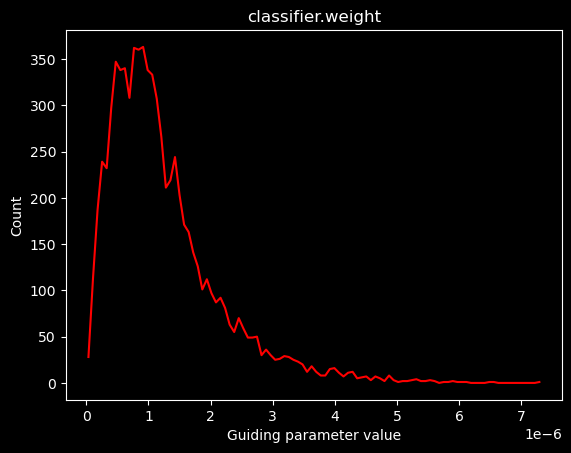

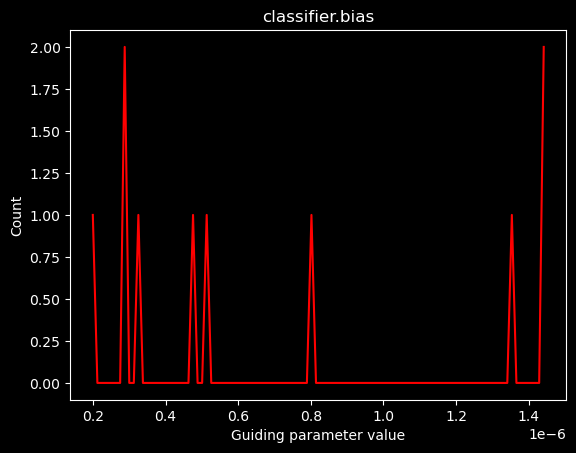

time: 1.81 s (started: 2024-07-18 15:36:13 +03:00)


In [250]:
gtl.plot_guidance_distribution(raw_guidance_matrix, name='classifier.weight')
gtl.plot_guidance_distribution(raw_guidance_matrix, name='classifier.bias') 

- Plot all BERT Layers from Guidance Matrix:

In [151]:
encoder_sub_layers_list = [
    'attention.self.query.weight',
    'attention.self.query.bias' ,
    'attention.self.key.weight',
    'attention.self.key.bias' ,
    'attention.self.value.weight',  
    'attention.self.value.bias' ,
    'attention.output.dense.weight',  
    'attention.output.dense.bias' ,
    'attention.output.LayerNorm.weight',  
    'attention.output.LayerNorm.bias'  ,
    'intermediate.dense.weight'  ,
    'intermediate.dense.bias'  ,
    'output.dense.weight'  ,
    'output.dense.bias'  ,
    'output.LayerNorm.weight',  
    'output.LayerNorm.bias',  
    ] 

time: 0 ns (started: 2024-07-18 10:49:12 +03:00)


- Plots

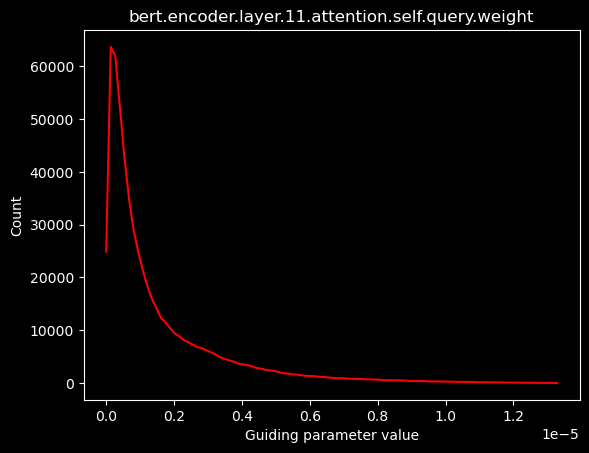

bert.encoder.layer.11.attention.self.query.weight


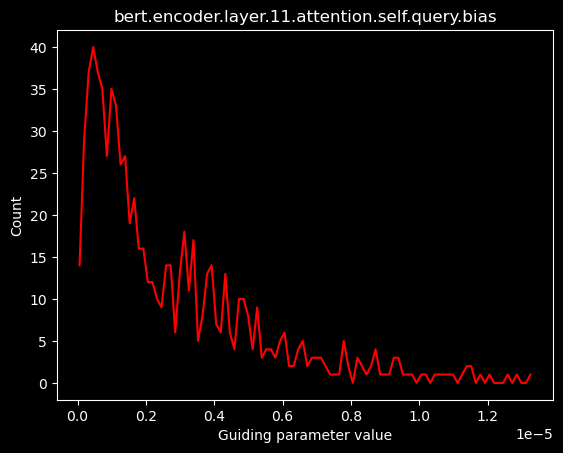

bert.encoder.layer.11.attention.self.query.bias


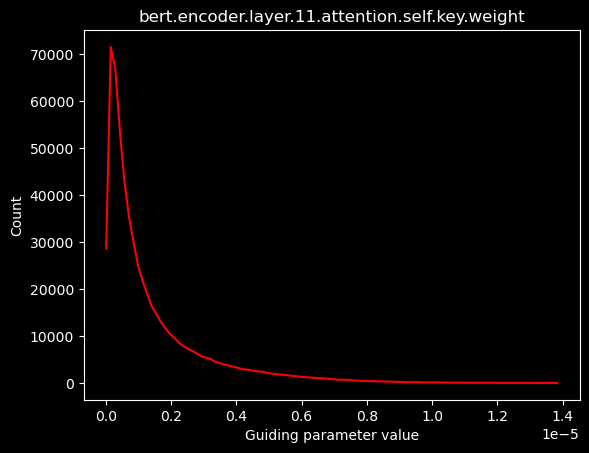

bert.encoder.layer.11.attention.self.key.weight


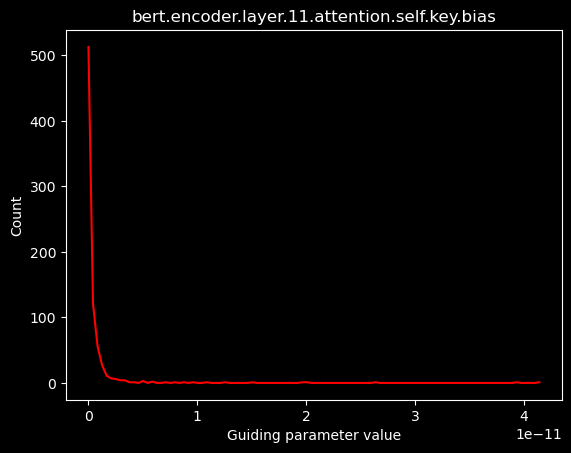

bert.encoder.layer.11.attention.self.key.bias


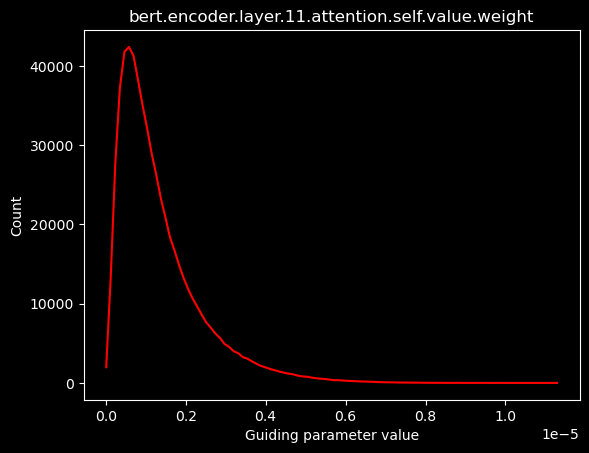

bert.encoder.layer.11.attention.self.value.weight


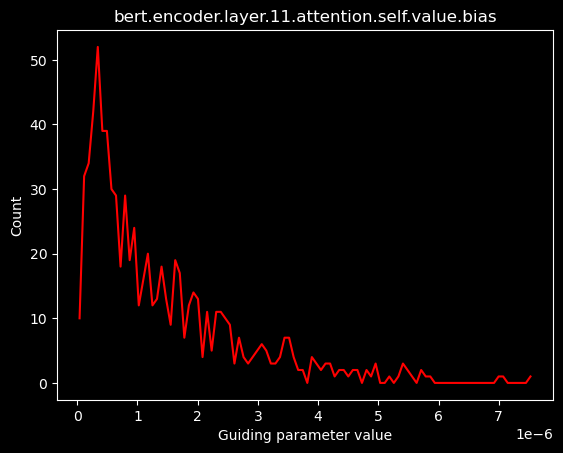

bert.encoder.layer.11.attention.self.value.bias


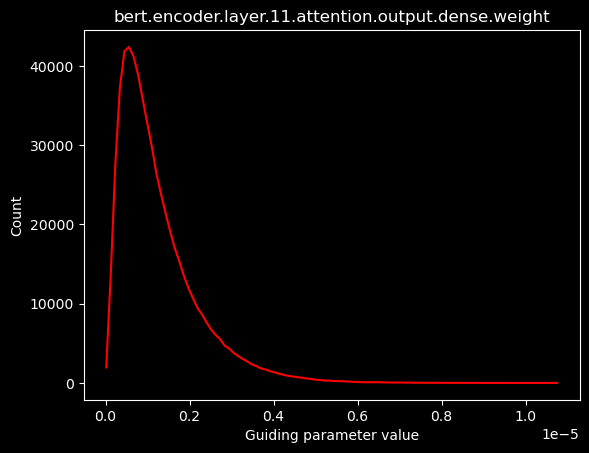

bert.encoder.layer.11.attention.output.dense.weight


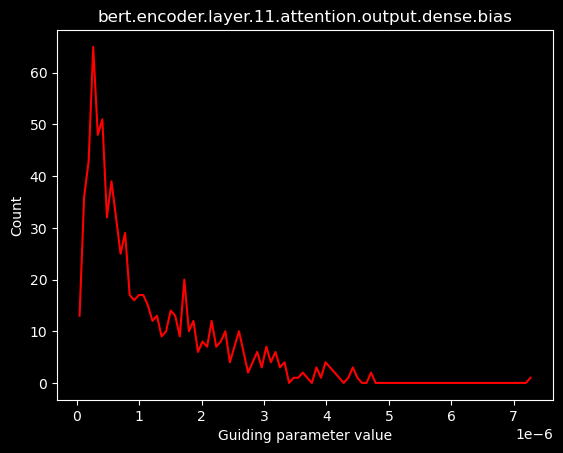

bert.encoder.layer.11.attention.output.dense.bias


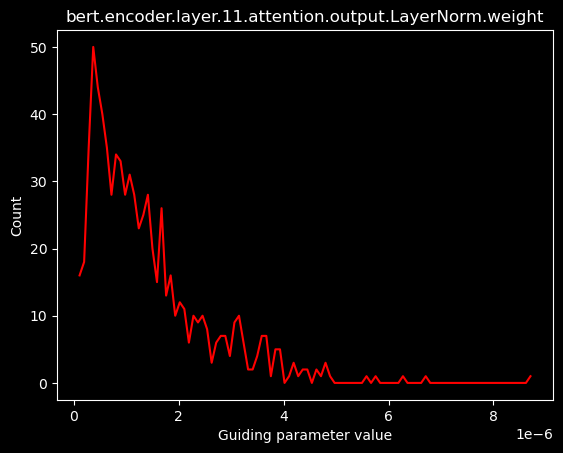

bert.encoder.layer.11.attention.output.LayerNorm.weight


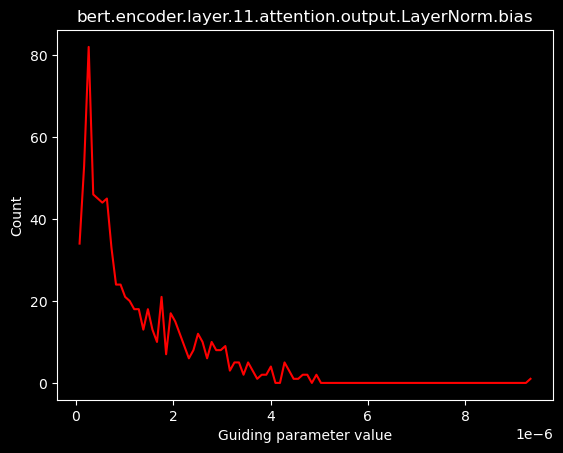

bert.encoder.layer.11.attention.output.LayerNorm.bias


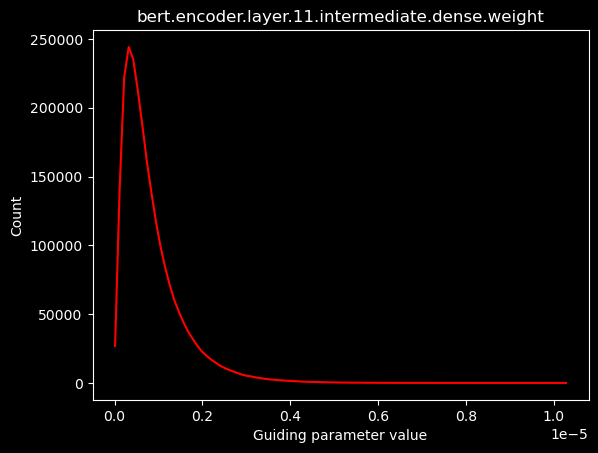

bert.encoder.layer.11.intermediate.dense.weight


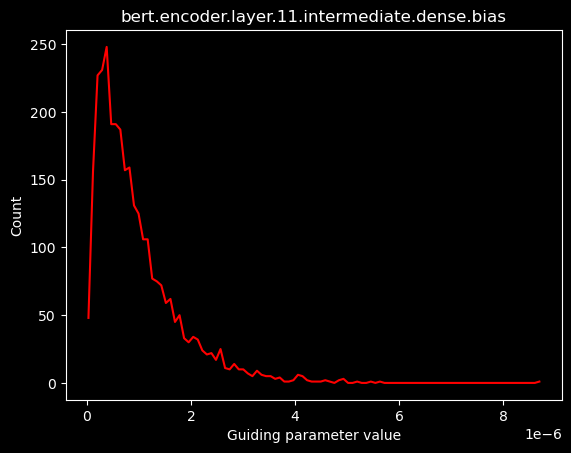

bert.encoder.layer.11.intermediate.dense.bias


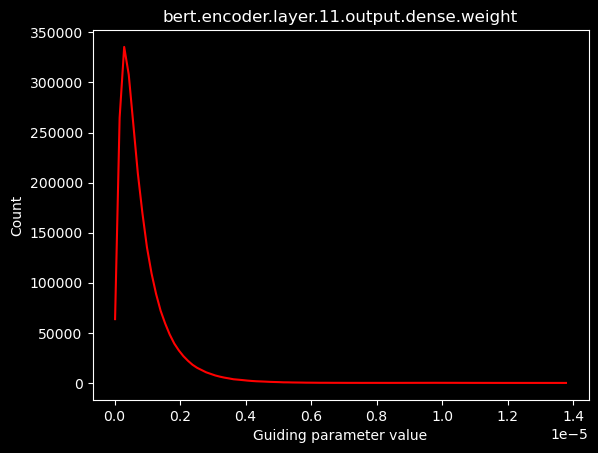

bert.encoder.layer.11.output.dense.weight


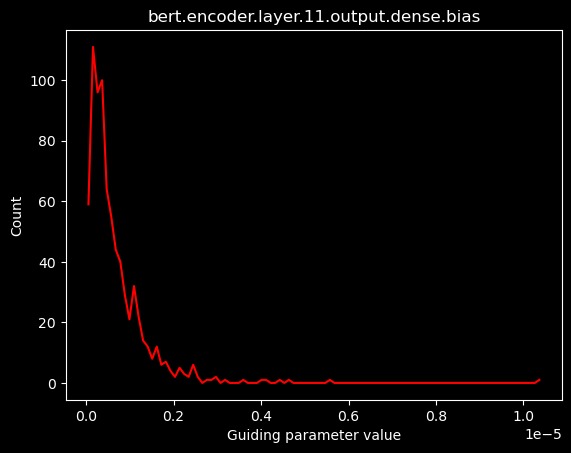

bert.encoder.layer.11.output.dense.bias


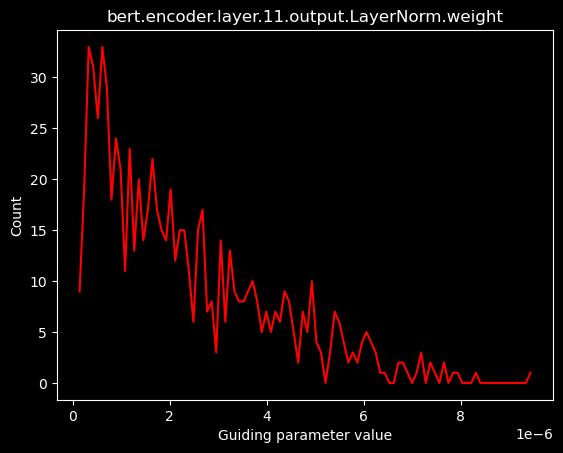

bert.encoder.layer.11.output.LayerNorm.weight


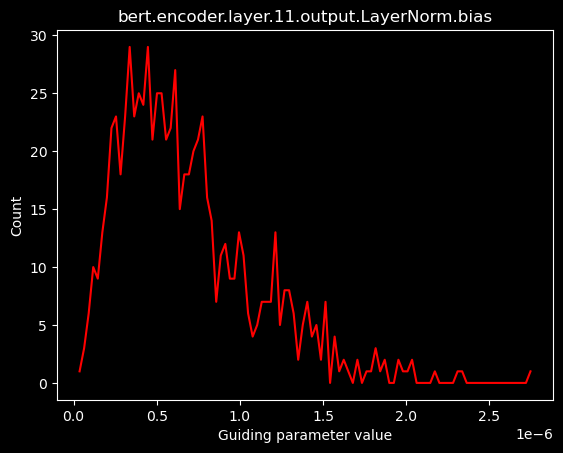

bert.encoder.layer.11.output.LayerNorm.bias
time: 1.67 s (started: 2024-07-18 15:36:28 +03:00)


In [251]:
for layer_num in range(12-nb_of_layers_to_unfreeze,12):
    for sub_layer in encoder_sub_layers_list:
        gtl.plot_guidance_distribution(raw_guidance_matrix, name=f'bert.encoder.layer.{layer_num}.{sub_layer}')
        print(f'bert.encoder.layer.{layer_num}.{sub_layer}')

# for layer_num in range(0,12):
#     for sub_layer in encoder_sub_layers_list:
#         gtl.plot_guidance_distribution(raw_guidance_matrix, name=f'bert.encoder.layer.{layer_num}.{sub_layer}')
#         # print(f'bert.encoder.layer.{layer_num}.{sub_layer}')


In [153]:
# del raw_guidance_matrix

time: 0 ns (started: 2024-07-18 10:49:14 +03:00)


### Train with & without Guidance Matrix on Dataset B


- Let us only have 1-shot and 5-shot, but increase the number of epochs. 
Then we plot the accuracy and loss as a function of epochs. 

- Take a look again at our original paper for GTL. We have some plots shown there. See whether you can make similar plots.

- Remember: 1-shot means one example per category. If you have 10 categories, then you are training with 10 examples in total.
 like 1
 
- I would start with 100 epochs.

- Also, remember that you cannot directly compare with and without GTL by using the same number of epochs. This is because the guiding matrix may slow down the training considerably (if the guiding values are predominantly <1.0) or accelerate the training (if the values are mostly>1.0).

- Instead, you have to run a lot of epochs and compare the curves (epoch vs. performance). You need to look for the maximum performance that each can reach.

- And show both, train and test loss and accuracy.

22/07/2024 
- should add evaluate before start train 

- check if the points are exactly the same for with and without  (multiple selections and plot on graph) 

- more epochs for 20-shot

- try batch 1 for everything (less important)

- scale the guidance matrix 100 , 1000, 10000, 

- seed (PyTorch and python and 3rd one ) 

#### Training with Guided Tranfer Learning (Few-Shot learn):

- Take x samples from each class:

In [15]:
#for vscode:
raw_guidance_matrix = gtl.load_guidance_matrix()


time: 172 ms (started: 2024-07-24 12:57:16 +03:00)


In [16]:
random_classes_A = [ 1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 16, 17, 19, 20, 21, 24, 26 ] 
random_classes_B = [ 0, 4, 8, 10, 13, 18, 22, 23, 25, 27 ] 

time: 0 ns (started: 2024-07-24 12:57:16 +03:00)


In [17]:
classes_B_np = np.array(random_classes_B)
classes_B_np = classes_B_np.reshape(len(classes_B_np), 1)
classes_B_np

array([[ 0],
       [ 4],
       [ 8],
       [10],
       [13],
       [18],
       [22],
       [23],
       [25],
       [27]])

time: 15 ms (started: 2024-07-24 12:57:16 +03:00)


#### 1 item per class (without early soping): 

In [257]:
fewshot_total_list = [10,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 1
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withGTL_1shot = []
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    # ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter+1} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True) 

        # for batch in goemotions_train_B_loader:
        #     print('labels: ' , batch['labels'])

        print(f"# Start Training Few-shot ({int(fewshot_total/10)} items per class) with GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_with_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=True, 
                                                                guidance_matrix=raw_guidance_matrix,
                                                                train_verbose=True,
                                                                eval_verbose=True)
        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,verbose=True,dataset_category="Testing")
        all_multiple_results_withGTL_1shot.append(train_results_few_shot_with_guidance_matrix)
        time.sleep(20)
        print(f"# Training Few-shot with GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
        print("================================================================================================") 
        
    


Selection Nb 1 is running.
# Start Training Few-shot (1 items per class) with GTL for a total of 10 examples from 10 classes.
# BERT downloaded.
# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: # Validation loss: 2.30 || Validation  acc: 0.05
# Epoch: 1 (Learning rate: 5e-05)  Training loss: 2.39 || Training acc: 0.10 || Validation loss: 2.28 || Validation acc: 0.08
# Epoch: 5 (Learning rate: 4.8e-05)  Training loss: 2.15 || Training acc: 0.40 || Validation loss: 2.28 || Validation acc: 0.08
# Epoch: 10 (Learning rate: 4.55e-05)  Training loss: 1.84 || Training acc: 0.90 || Validation loss: 2.28 || Validation acc: 0.08
# Epoch: 15 (Learning rate: 4.3e-05)  Training loss: 1.40 || Training acc: 1.00 || Validation loss: 2.29 || Validation acc: 0.09
# Epoch: 20 (Learning rate: 4.05e-05)  Training loss: 1.00 || Training acc: 1.00 || Validation loss: 2.29 || Validation acc: 0.12
# Epoch: 25 (Learning rate: 3.8e-05)  Training loss: 0.70 || Training acc: 1.00 || Valida

In [258]:
# For saving the results:
print(all_multiple_results_withGTL_1shot) 

[{'train_results': [[2.3868114233016966, 2.296274018287659, 2.247470331192017, 2.1961015701293944, 2.149017322063446, 2.099607002735138, 2.038015353679657, 1.9826839566230774, 1.9157061934471131, 1.8427884101867675, 1.762835681438446, 1.675047469139099, 1.5831997394561768, 1.4897192478179933, 1.401791399717331, 1.320498877763748, 1.2362461686134338, 1.1478967547416687, 1.0742019057273864, 1.0017223179340362, 0.9355151325464248, 0.8714165300130844, 0.8066453963518143, 0.7499603629112244, 0.6980752855539322, 0.6448829054832459, 0.6015065729618072, 0.5579907149076462, 0.5161882400512695, 0.4829513505101204, 0.44627771377563474, 0.4159869194030762, 0.39042562395334246, 0.3646352499723434, 0.33986177295446396, 0.3212104603648186, 0.3011321112513542, 0.2842453643679619, 0.269008195400238, 0.2546278744935989, 0.24130840301513673, 0.23071770668029784, 0.21969809830188752, 0.2092605412006378, 0.201159530878067, 0.19266010895371438, 0.18518726378679276, 0.1780162088572979, 0.17172973304986955, 0

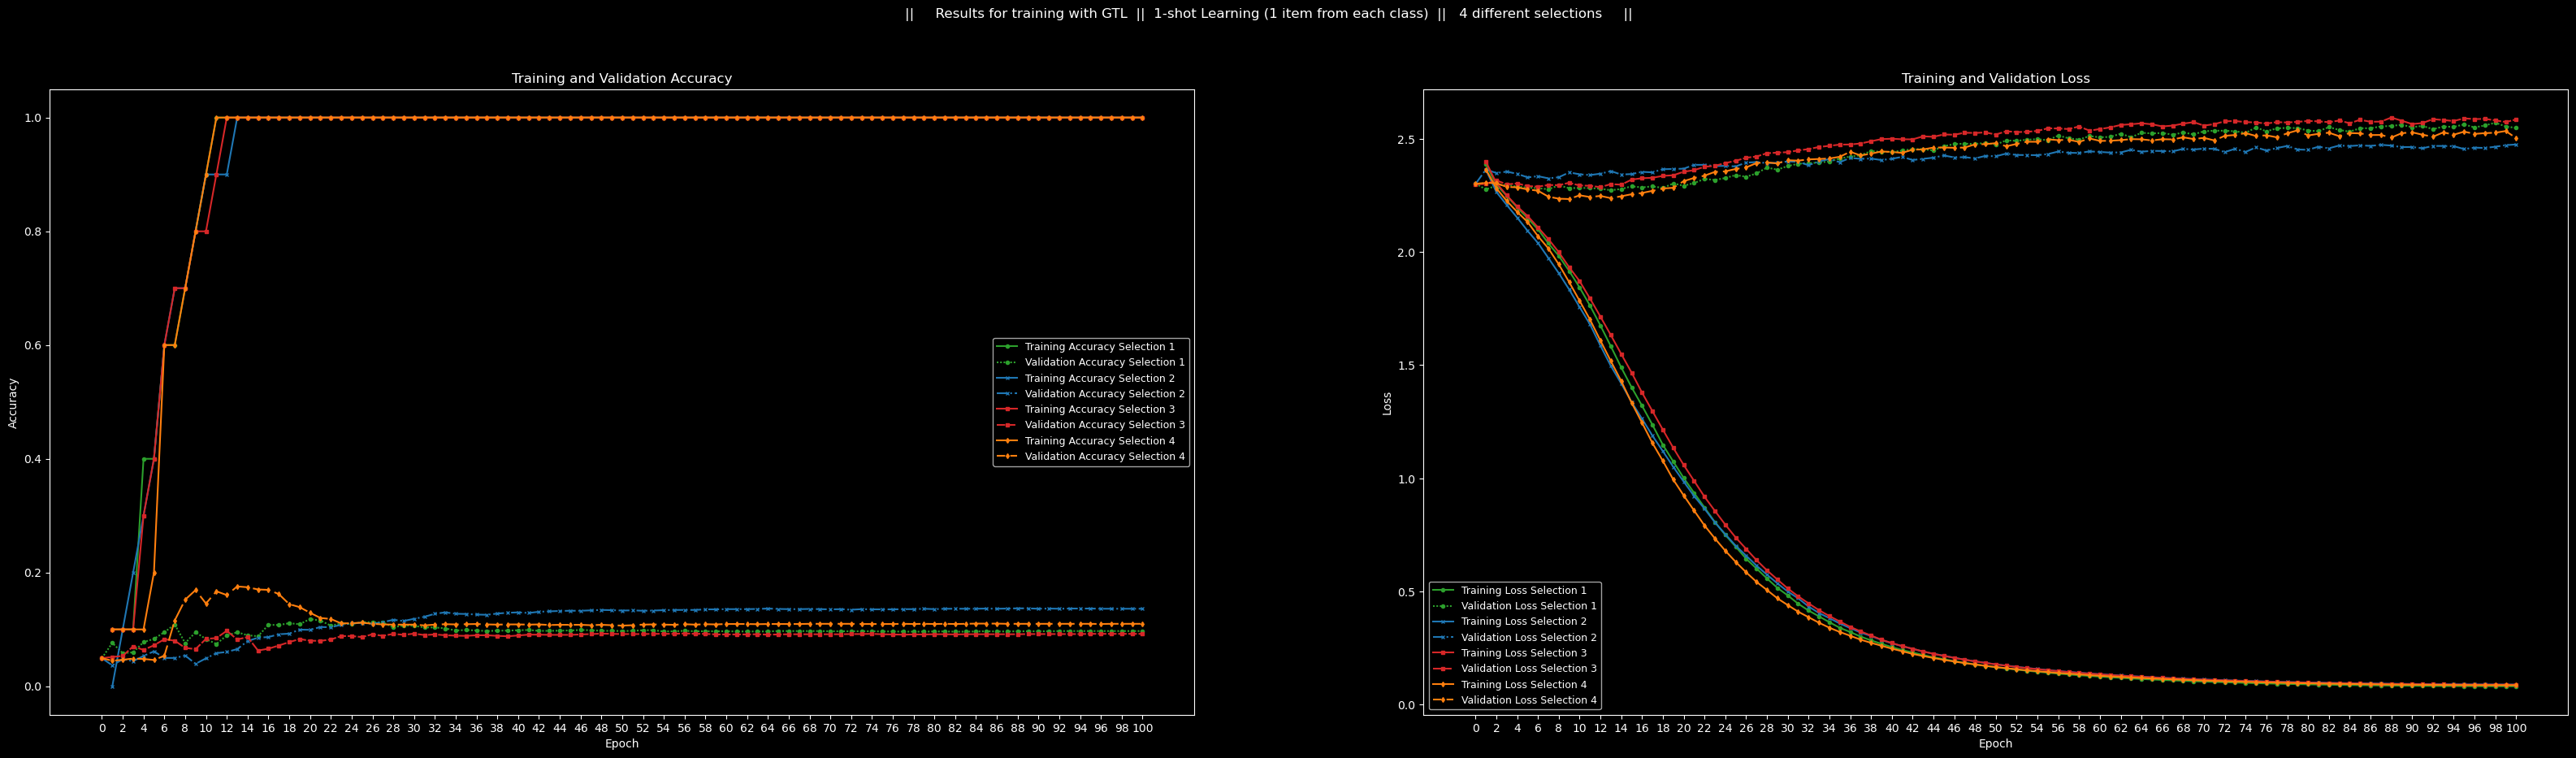

time: 422 ms (started: 2024-07-25 18:33:52 +03:00)


In [271]:
limit_per_class = 1
plot_multiple_results(all_multiple_results_withGTL_1shot, title= f"||     Results for training with GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||")  

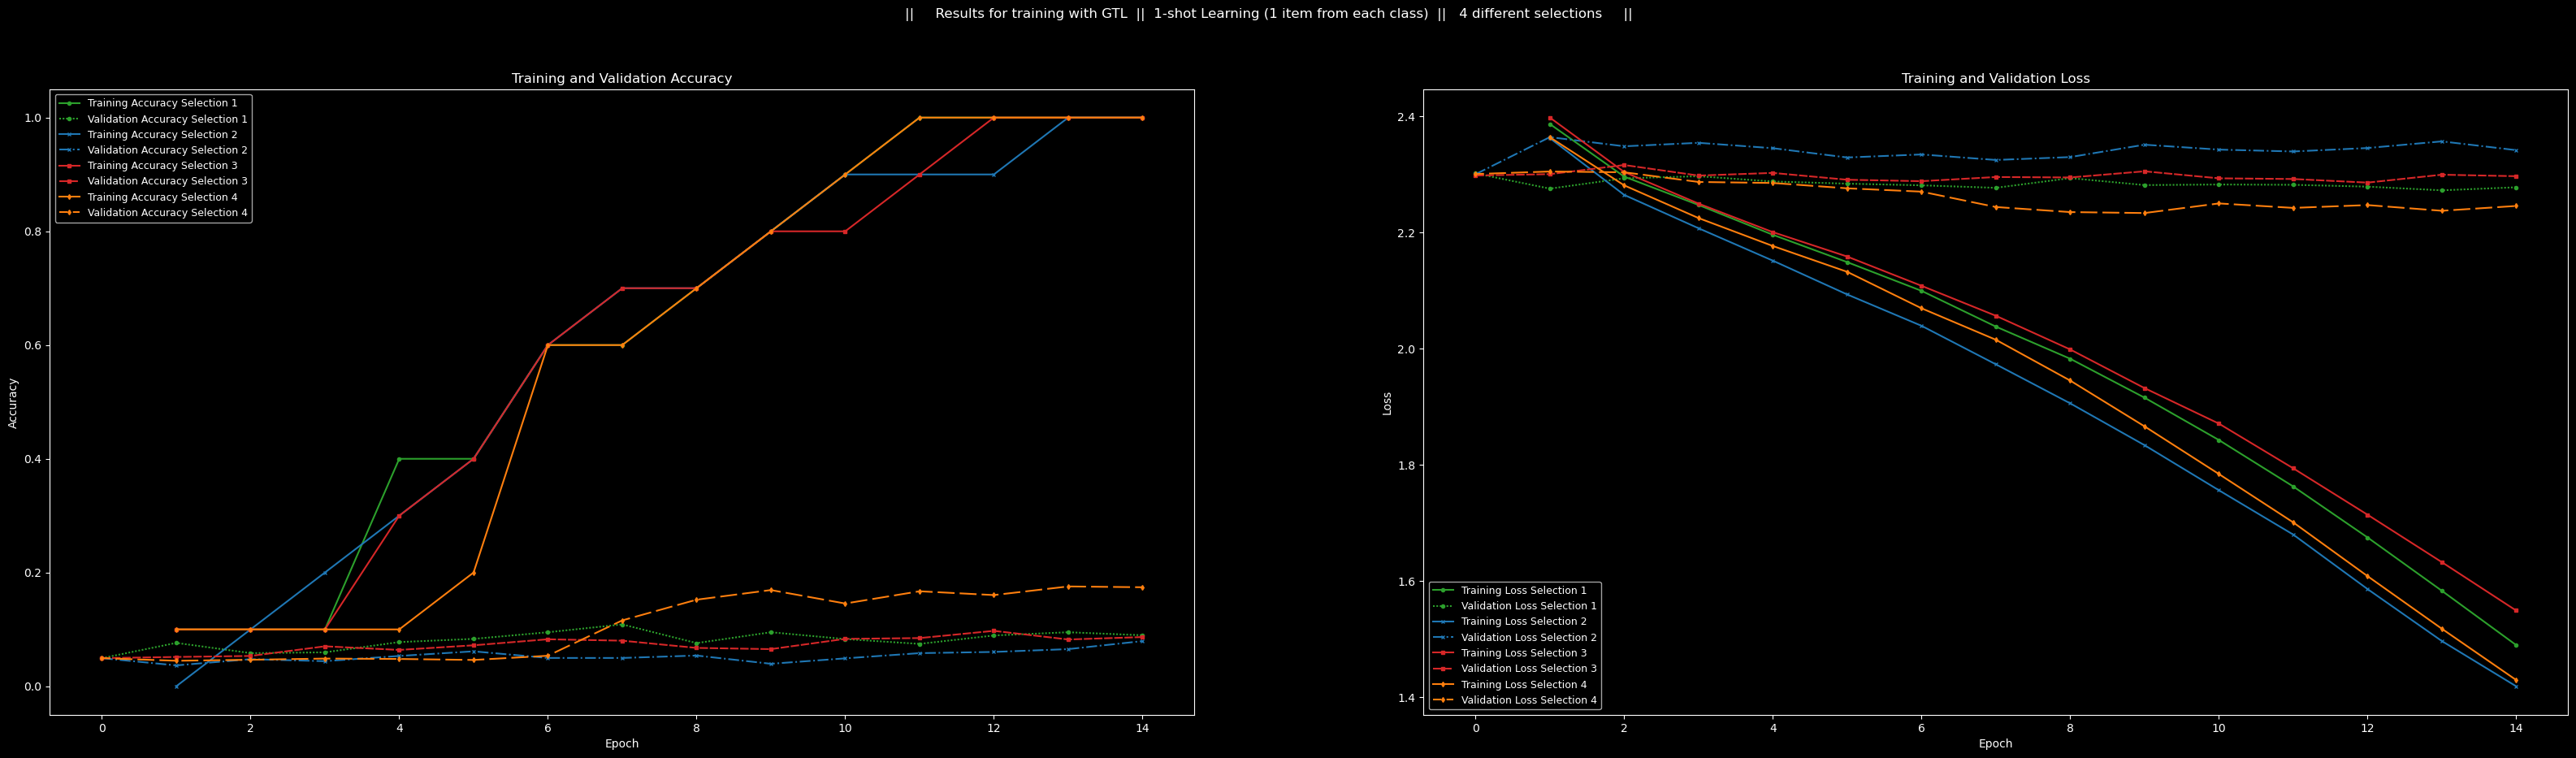

time: 297 ms (started: 2024-07-25 18:34:22 +03:00)


In [272]:
limit_per_class = 1
plot_multiple_results(all_multiple_results_withGTL_1shot, title= f"||     Results for training with GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14)  

#### 5 items per class:


In [201]:
fewshot_total_list = [50,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 5
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withGTL_5shot = [ ]
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    # ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter+1} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True)

        print(f"# Start Training Few-shot ({int(fewshot_total/10)}-shot Learning) with GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_with_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=True, 
                                                                guidance_matrix=raw_guidance_matrix,
                                                                train_verbose=True,
                                                                eval_verbose=True)
        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withGTL_5shot.append(train_results_few_shot_with_guidance_matrix)
        time.sleep(20)
        
    # plot_results(train_results_few_shot_with_guidance_matrix, title= "Results with GTL") 
    # print(all_multiple_results)
    print(f"# Training Few-shot with GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")


Selection Nb 1 is running.
# Start Training Few-shot (5 items per class) with GTL for a total of 50 examples from 10 classes.
# BERT downloaded.
# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: # Validation loss: 2.30 || Validation  acc: 0.05
# Epoch: 1 (Learning rate: 5e-05)  Training loss: 2.35 || Training acc: 0.10 || Validation loss: 2.31 || Validation acc: 0.05
# Epoch: 5 (Learning rate: 4.8e-05)  Training loss: 2.27 || Training acc: 0.18 || Validation loss: 2.29 || Validation acc: 0.11
# Epoch: 10 (Learning rate: 4.55e-05)  Training loss: 2.21 || Training acc: 0.24 || Validation loss: 2.30 || Validation acc: 0.11
# Epoch: 15 (Learning rate: 4.3e-05)  Training loss: 2.13 || Training acc: 0.48 || Validation loss: 2.30 || Validation acc: 0.12
# Epoch: 20 (Learning rate: 4.05e-05)  Training loss: 2.03 || Training acc: 0.62 || Validation loss: 2.29 || Validation acc: 0.13
# Epoch: 25 (Learning rate: 3.8e-05)  Training loss: 1.89 || Training acc: 0.80 || Valida

In [202]:
# For saving the results:
print(all_multiple_results_withGTL_5shot)

[{'train_results': [[2.349609875679016, 2.3071343183517454, 2.2938399076461793, 2.280461287498474, 2.2694644212722777, 2.2560138463974, 2.244325280189514, 2.2308847904205322, 2.2200280904769896, 2.205756664276123, 2.1930721521377565, 2.17947096824646, 2.162809896469116, 2.149391770362854, 2.1323978900909424, 2.1145722031593324, 2.094350039958954, 2.0746337175369263, 2.0518768429756165, 2.030423581600189, 2.0042252063751222, 1.975834858417511, 1.9457279562950134, 1.91585533618927, 1.8857434153556825, 1.8535080909729005, 1.8226372361183167, 1.7878661751747131, 1.7525301337242127, 1.7164428591728211, 1.6795631885528564, 1.644869315624237, 1.6079967737197876, 1.570503032207489, 1.533201277256012, 1.4947436571121215, 1.457845437526703, 1.4194635152816772, 1.3808381795883178, 1.3442561030387878, 1.305808675289154, 1.2698032021522523, 1.2329458475112915, 1.1966367304325103, 1.16113942861557, 1.127854150533676, 1.0936877131462097, 1.0623380839824677, 1.0313901841640472, 1.0000428795814513, 0.9

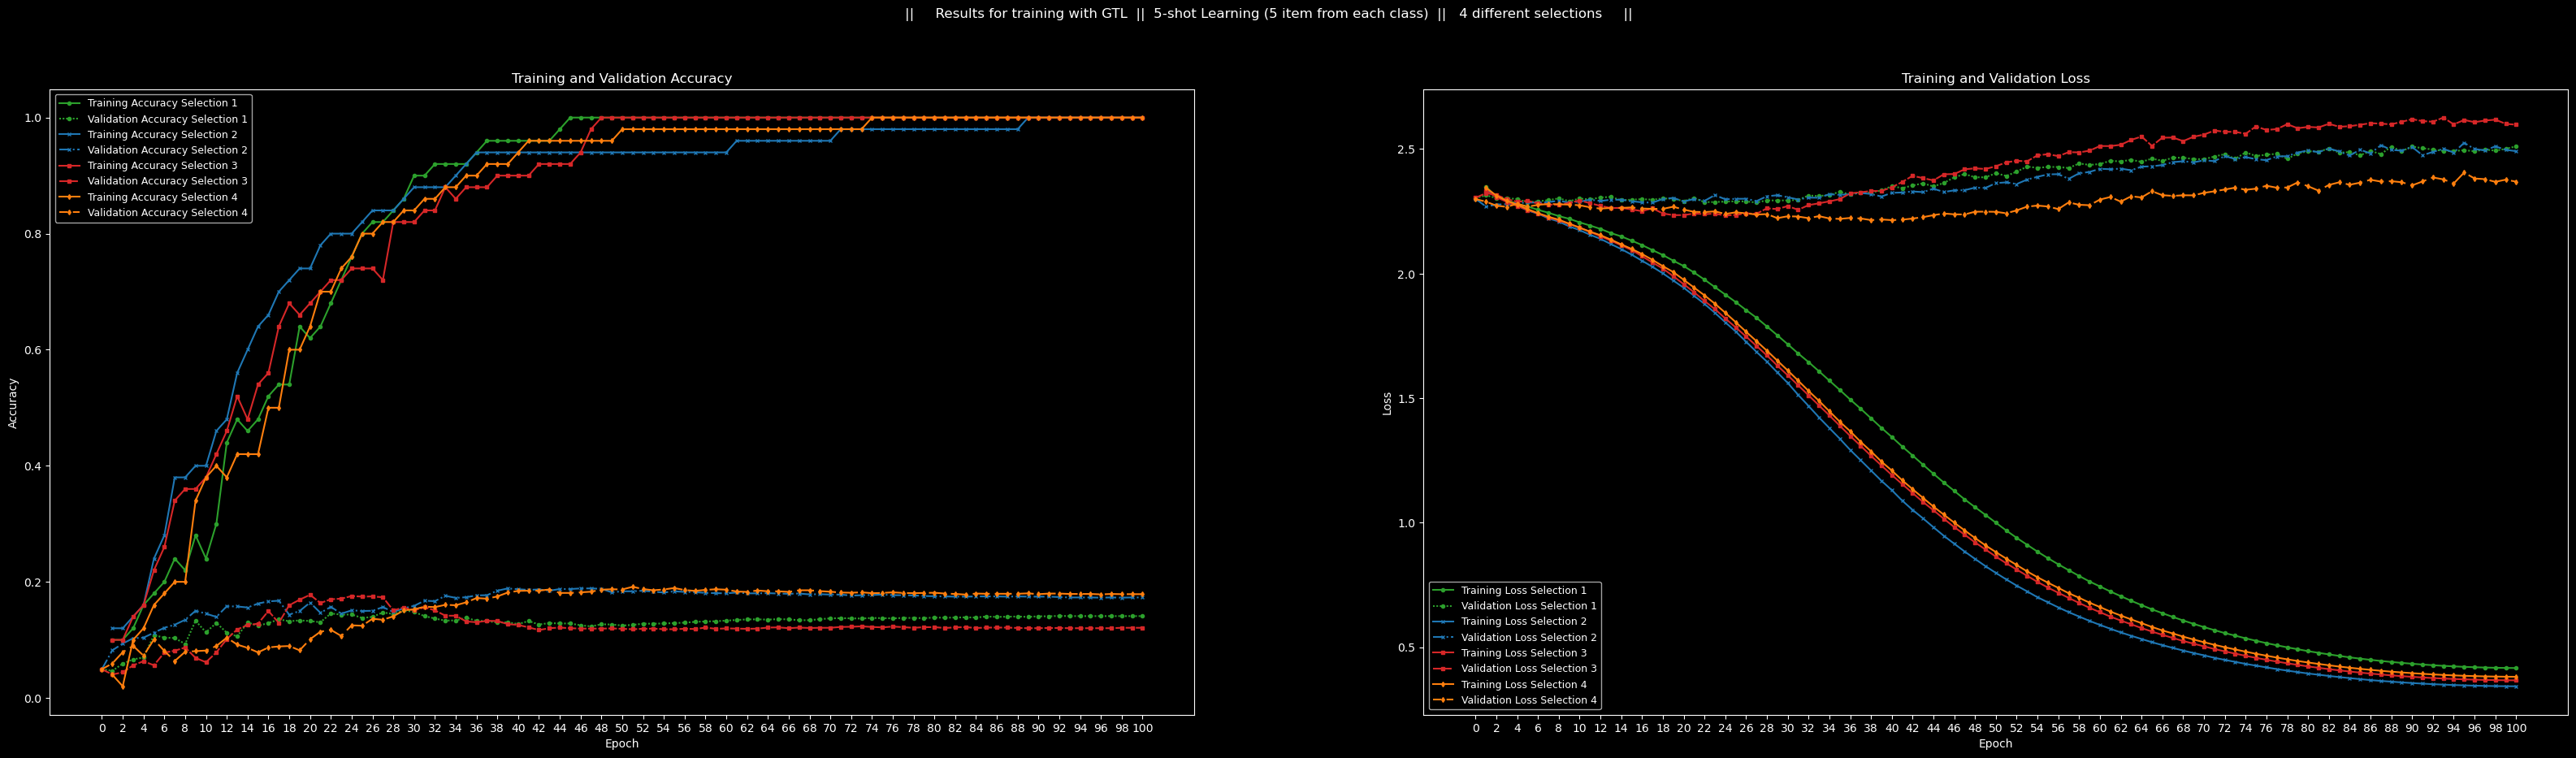

time: 406 ms (started: 2024-07-25 18:34:51 +03:00)


In [273]:
limit_per_class = 5
plot_multiple_results(all_multiple_results_withGTL_5shot, title= f"||     Results for training with GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||") 

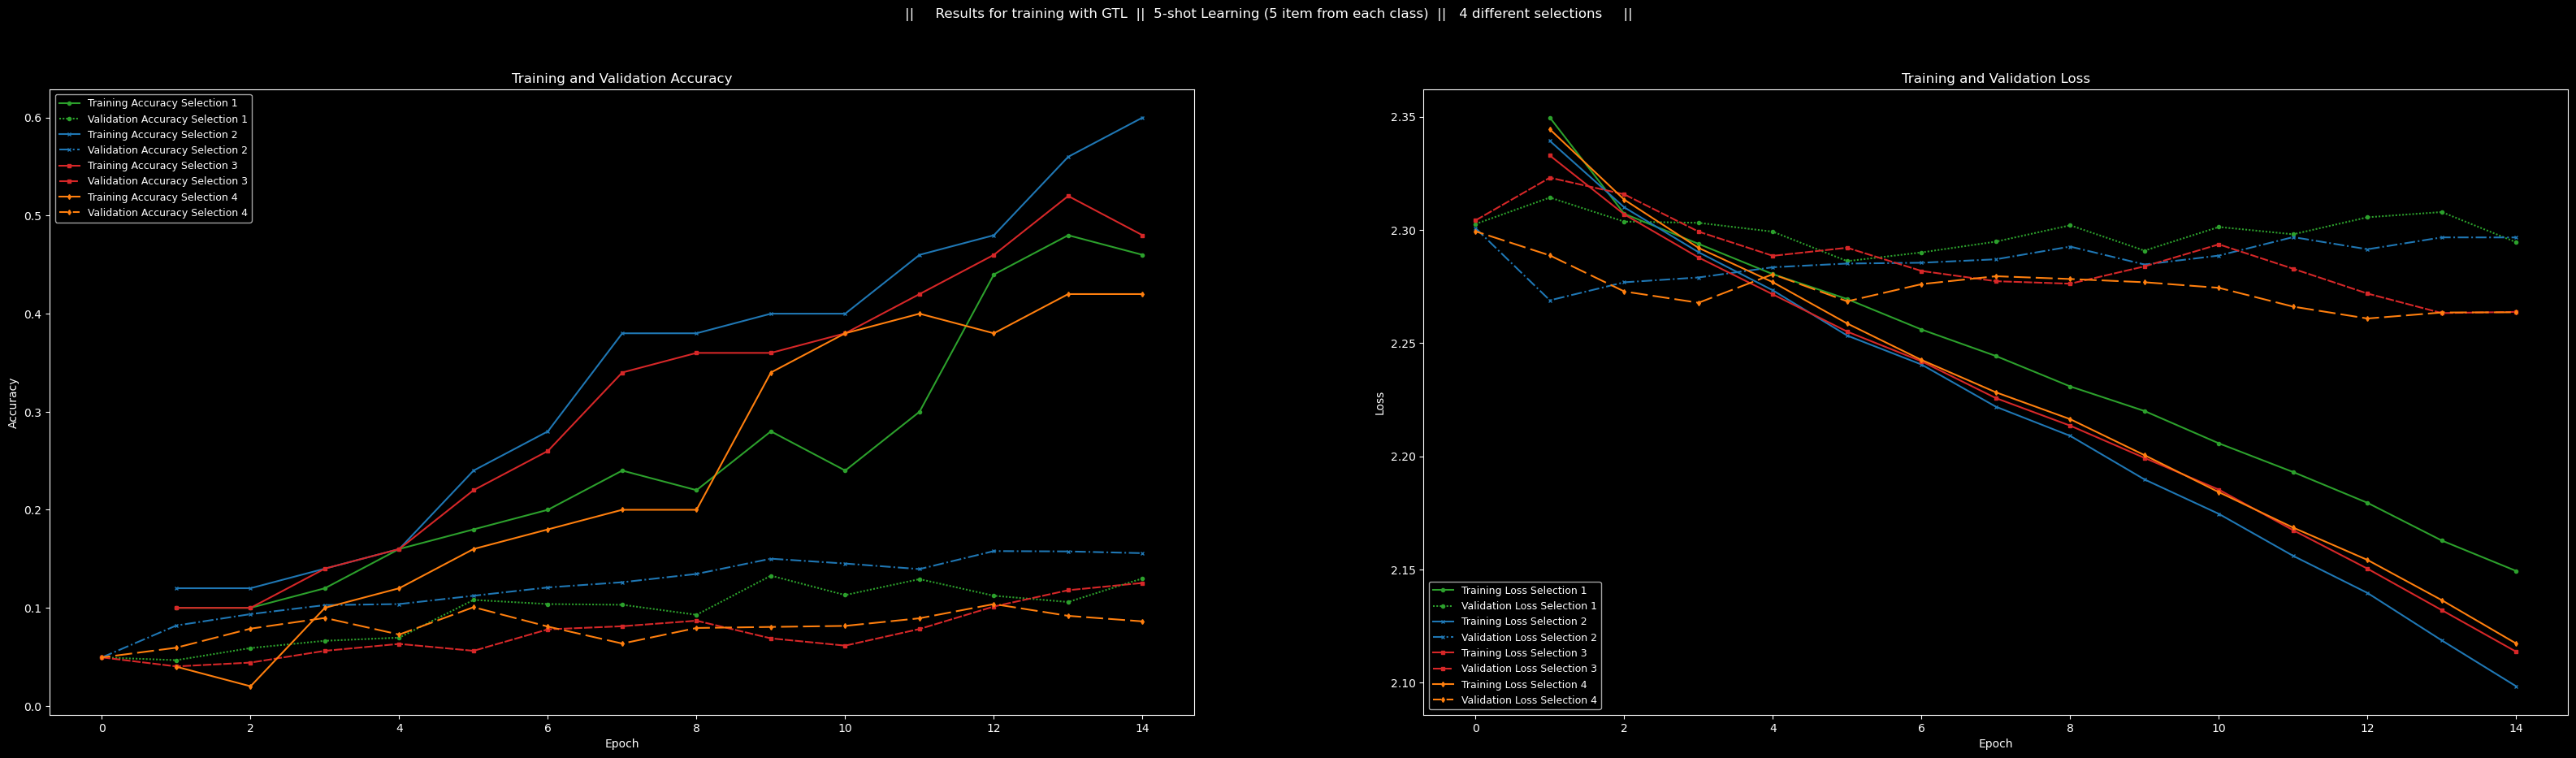

time: 297 ms (started: 2024-07-25 18:35:56 +03:00)


In [276]:
limit_per_class = 5
plot_multiple_results(all_multiple_results_withGTL_5shot, title= f"||     Results for training with GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14) 

#### 20-shot Learning:

In [249]:
fewshot_total_list = [200,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 20 
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withGTL_20shot = []
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = [] 
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter+1} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True)

        print(f"# Start Training Few-shot ({int(fewshot_total/10)}-shot Learning) with GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_with_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=True, 
                                                                guidance_matrix=raw_guidance_matrix,
                                                                train_verbose=True,
                                                                eval_verbose=True)
        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withGTL_20shot.append(train_results_few_shot_with_guidance_matrix)
        time.sleep(10)
        
    # plot_results(train_results_few_shot_with_guidance_matrix, title= "Results with GTL") 
    # print(all_multiple_results)
    print(f"# Training Few-shot with GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")


Selection Nb 1 is running.
# Start Training Few-shot (20 items per class) with GTL for a total of 200 examples from 10 classes.
# BERT downloaded.
# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: # Validation loss: 2.30 || Validation  acc: 0.05
# Epoch: 1 (Learning rate: 5e-05)  Training loss: 2.33 || Training acc: 0.09 || Validation loss: 2.26 || Validation acc: 0.09
# Epoch: 5 (Learning rate: 4.8e-05)  Training loss: 2.29 || Training acc: 0.18 || Validation loss: 2.28 || Validation acc: 0.11
# Epoch: 10 (Learning rate: 4.55e-05)  Training loss: 2.26 || Training acc: 0.21 || Validation loss: 2.29 || Validation acc: 0.11
# Epoch: 15 (Learning rate: 4.3e-05)  Training loss: 2.23 || Training acc: 0.27 || Validation loss: 2.27 || Validation acc: 0.12
# Epoch: 20 (Learning rate: 4.05e-05)  Training loss: 2.19 || Training acc: 0.31 || Validation loss: 2.27 || Validation acc: 0.12
# Epoch: 25 (Learning rate: 3.8e-05)  Training loss: 2.15 || Training acc: 0.39 || Vali

In [250]:
# For saving the results:
print(all_multiple_results_withGTL_20shot)

[{'train_results': [[2.3335157871246337, 2.317419004440308, 2.3031404972076417, 2.2945002794265745, 2.286113142967224, 2.279876184463501, 2.2735199213027952, 2.2671945810317995, 2.261731171607971, 2.2559866189956663, 2.251529908180237, 2.2449931859970094, 2.2394208669662476, 2.233338809013367, 2.2267038106918333, 2.2206476449966432, 2.2137222290039062, 2.2074043989181518, 2.199064302444458, 2.191814994812012, 2.1837560415267943, 2.175985813140869, 2.1669223070144654, 2.1570635795593263, 2.1475650310516357, 2.1374010324478148, 2.1266026973724363, 2.114743876457214, 2.1021812915802003, 2.0895033836364747, 2.076716685295105, 2.0636602640151978, 2.049514555931091, 2.035971224308014, 2.0221682667732237, 2.00707151889801, 1.992692804336548, 1.9767951726913453, 1.9618701577186584, 1.9463474869728088, 1.9306556224822997, 1.9150343060493469, 1.89872065782547, 1.8830834031105042, 1.866507351398468, 1.8499281764030457, 1.8339113235473632, 1.8178235054016114, 1.8032778263092042, 1.7861500263214112

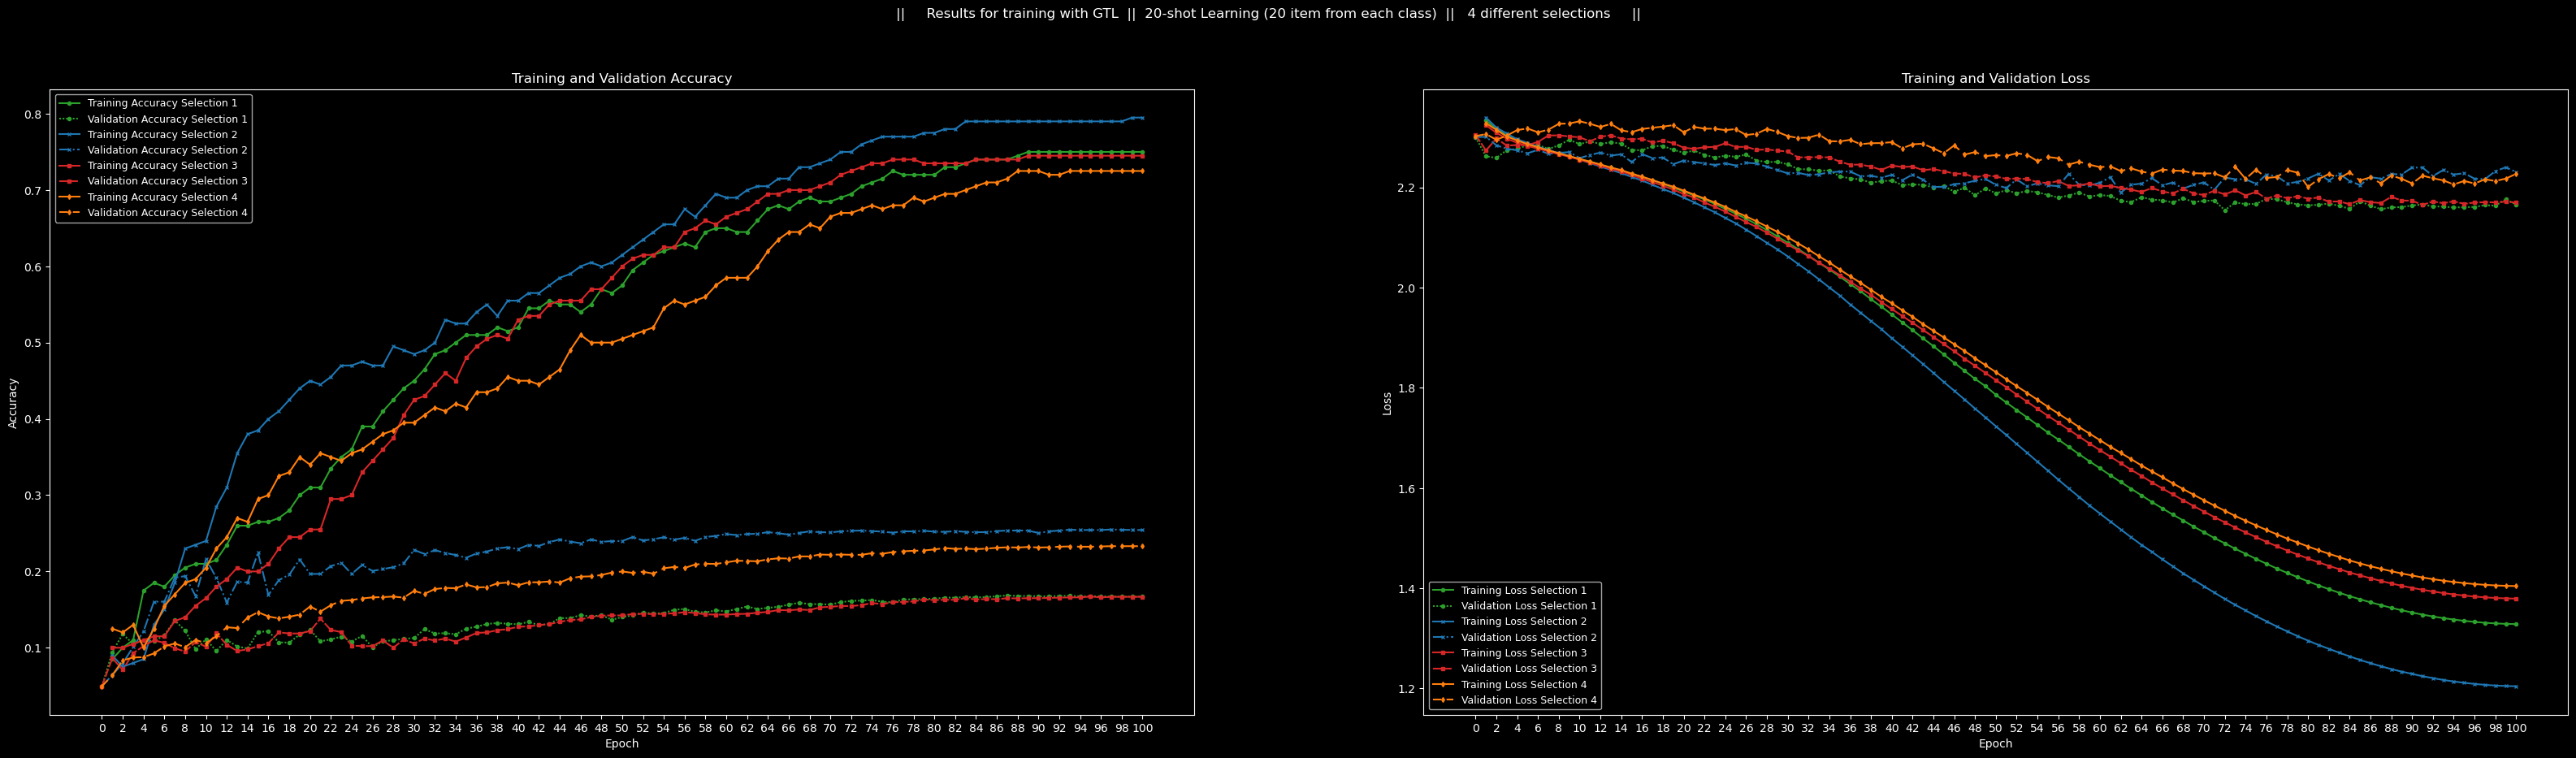

time: 422 ms (started: 2024-07-25 18:36:22 +03:00)


In [277]:
limit_per_class = 20
plot_multiple_results(all_multiple_results_withGTL_20shot, title= f"||     Results for training with GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||")  

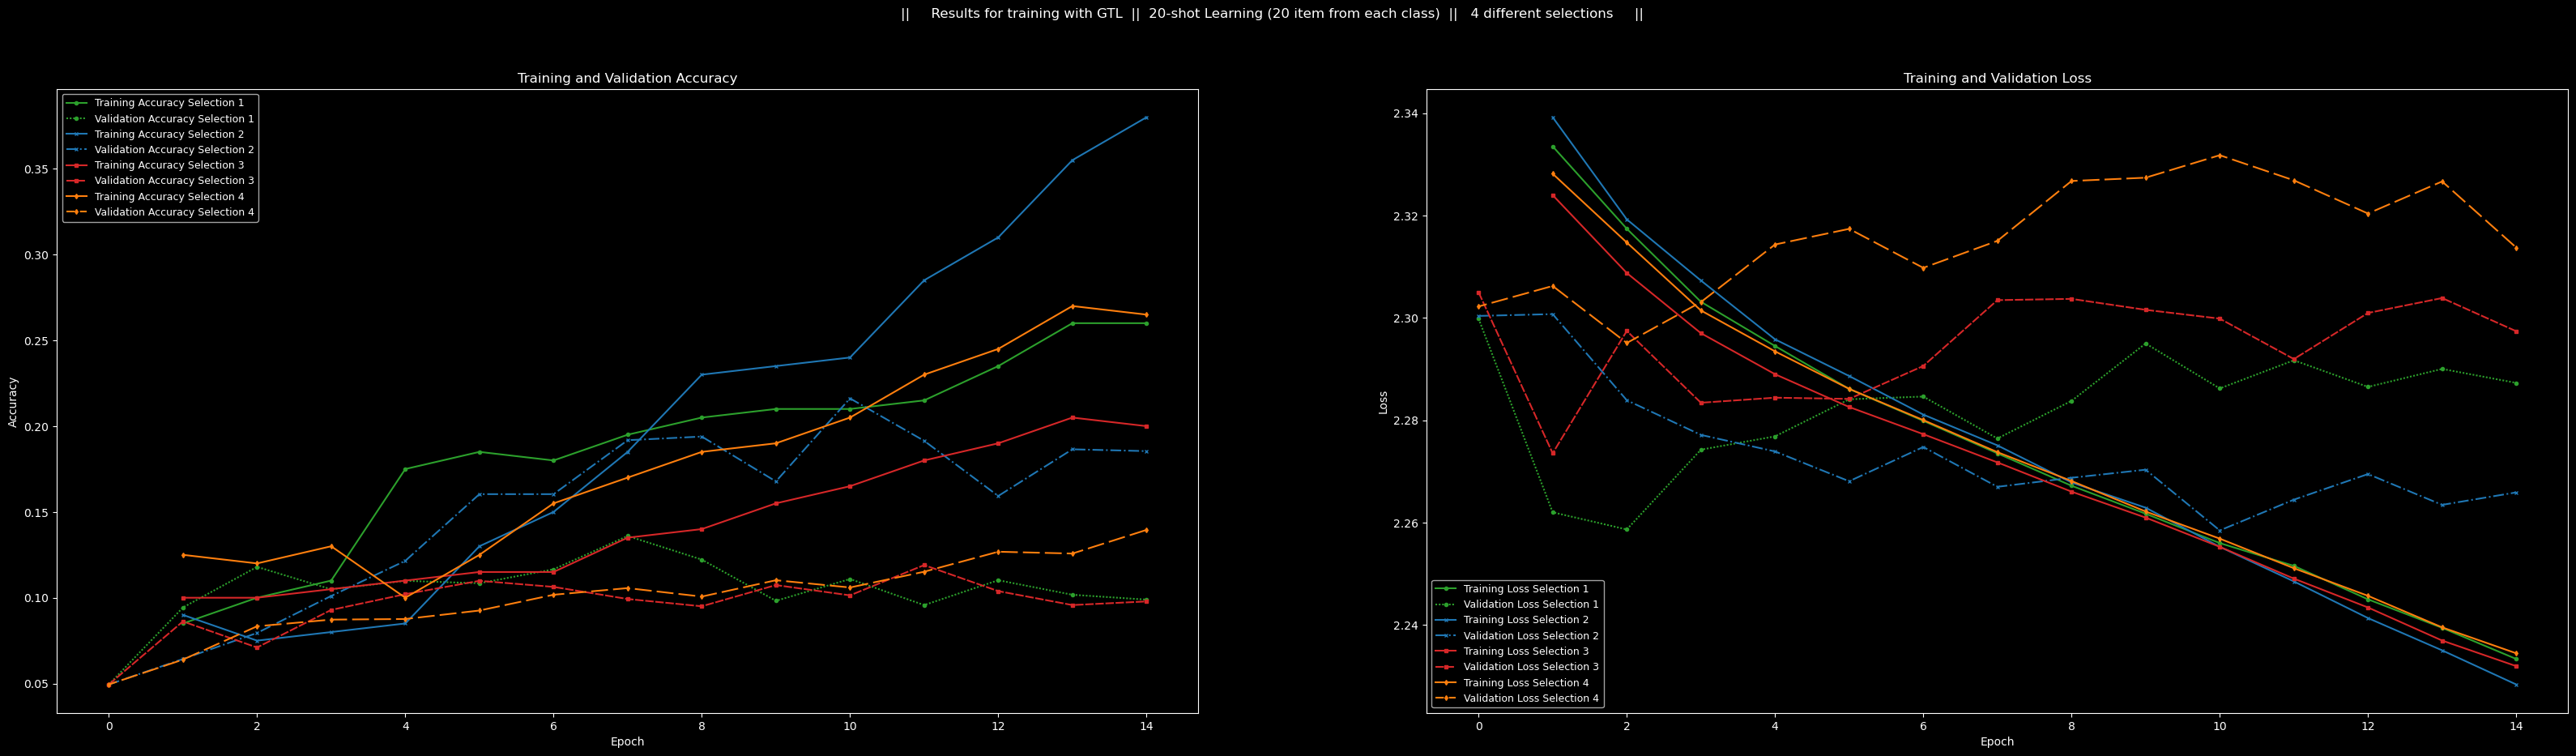

time: 532 ms (started: 2024-07-25 18:36:49 +03:00)


In [278]:
limit_per_class = 20
plot_multiple_results(all_multiple_results_withGTL_20shot, title= f"||     Results for training with GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14)  

#### Training without Guided Transfer Learning (Few-Shot learn):

#### 1 item per class:

In [253]:
fewshot_total_list = [10,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 1
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withoutGTL_1shot = [ ]
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True)
        
        print(f"# Start Training Few-shot ({int(fewshot_total/10)} items per class) without GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
        
        #train with few shot examples from dataset B 
        train_results_few_shot_without_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=False, 
                                                                train_verbose=True,
                                                                eval_verbose=True)
                                                                
        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withoutGTL_1shot.append(train_results_few_shot_without_guidance_matrix)
        time.sleep(10)
        
    print(f"# Training Few-shot without GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")


Selection Nb 0 is running.
# Start Training Few-shot (1 items per class) without GTL for a total of 10 examples from 10 classes.
# BERT downloaded.
# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: # Validation loss: 2.30 || Validation  acc: 0.05
# Epoch: 1 (Learning rate: 5e-05)  Training loss: 2.44 || Training acc: 0.00 || Validation loss: 2.40 || Validation acc: 0.04
# Epoch: 5 (Learning rate: 4.8e-05)  Training loss: 1.33 || Training acc: 1.00 || Validation loss: 2.32 || Validation acc: 0.09
# Epoch: 10 (Learning rate: 4.55e-05)  Training loss: 0.28 || Training acc: 1.00 || Validation loss: 2.40 || Validation acc: 0.09
# Epoch: 15 (Learning rate: 4.3e-05)  Training loss: 0.09 || Training acc: 1.00 || Validation loss: 2.44 || Validation acc: 0.09
# Epoch: 20 (Learning rate: 4.05e-05)  Training loss: 0.05 || Training acc: 1.00 || Validation loss: 2.46 || Validation acc: 0.09
# Epoch: 25 (Learning rate: 3.8e-05)  Training loss: 0.03 || Training acc: 1.00 || Val

In [254]:
# For saving the results:
print(all_multiple_results_withoutGTL_1shot)

[{'train_results': [[2.4379523038864135, 2.146544671058655, 1.9232873797416687, 1.624042385816574, 1.3333663463592529, 1.056111788749695, 0.7899100542068481, 0.5786353915929794, 0.4086303532123566, 0.2800712212920189, 0.2100591242313385, 0.1563559092581272, 0.12424715608358383, 0.10302007347345352, 0.08601740375161171, 0.07491853423416614, 0.06619856394827366, 0.05935019142925739, 0.053411952778697015, 0.04903588555753231, 0.04524760395288467, 0.041874525509774684, 0.0390415096655488, 0.03654308766126633, 0.03435163348913193, 0.032411791197955606, 0.030677472054958344, 0.029119238443672656, 0.027744023129343987, 0.026508969254791737, 0.025303396210074425, 0.024256871640682222, 0.023307102918624877, 0.02242546360939741, 0.021591599844396115, 0.020826245285570623, 0.020137332566082477, 0.01948336707428098, 0.018866439815610647, 0.01830153660848737, 0.017794501967728138, 0.017284018453210592, 0.016814735438674688, 0.01636921726167202, 0.0159488283097744, 0.015563954692333936, 0.0151949520

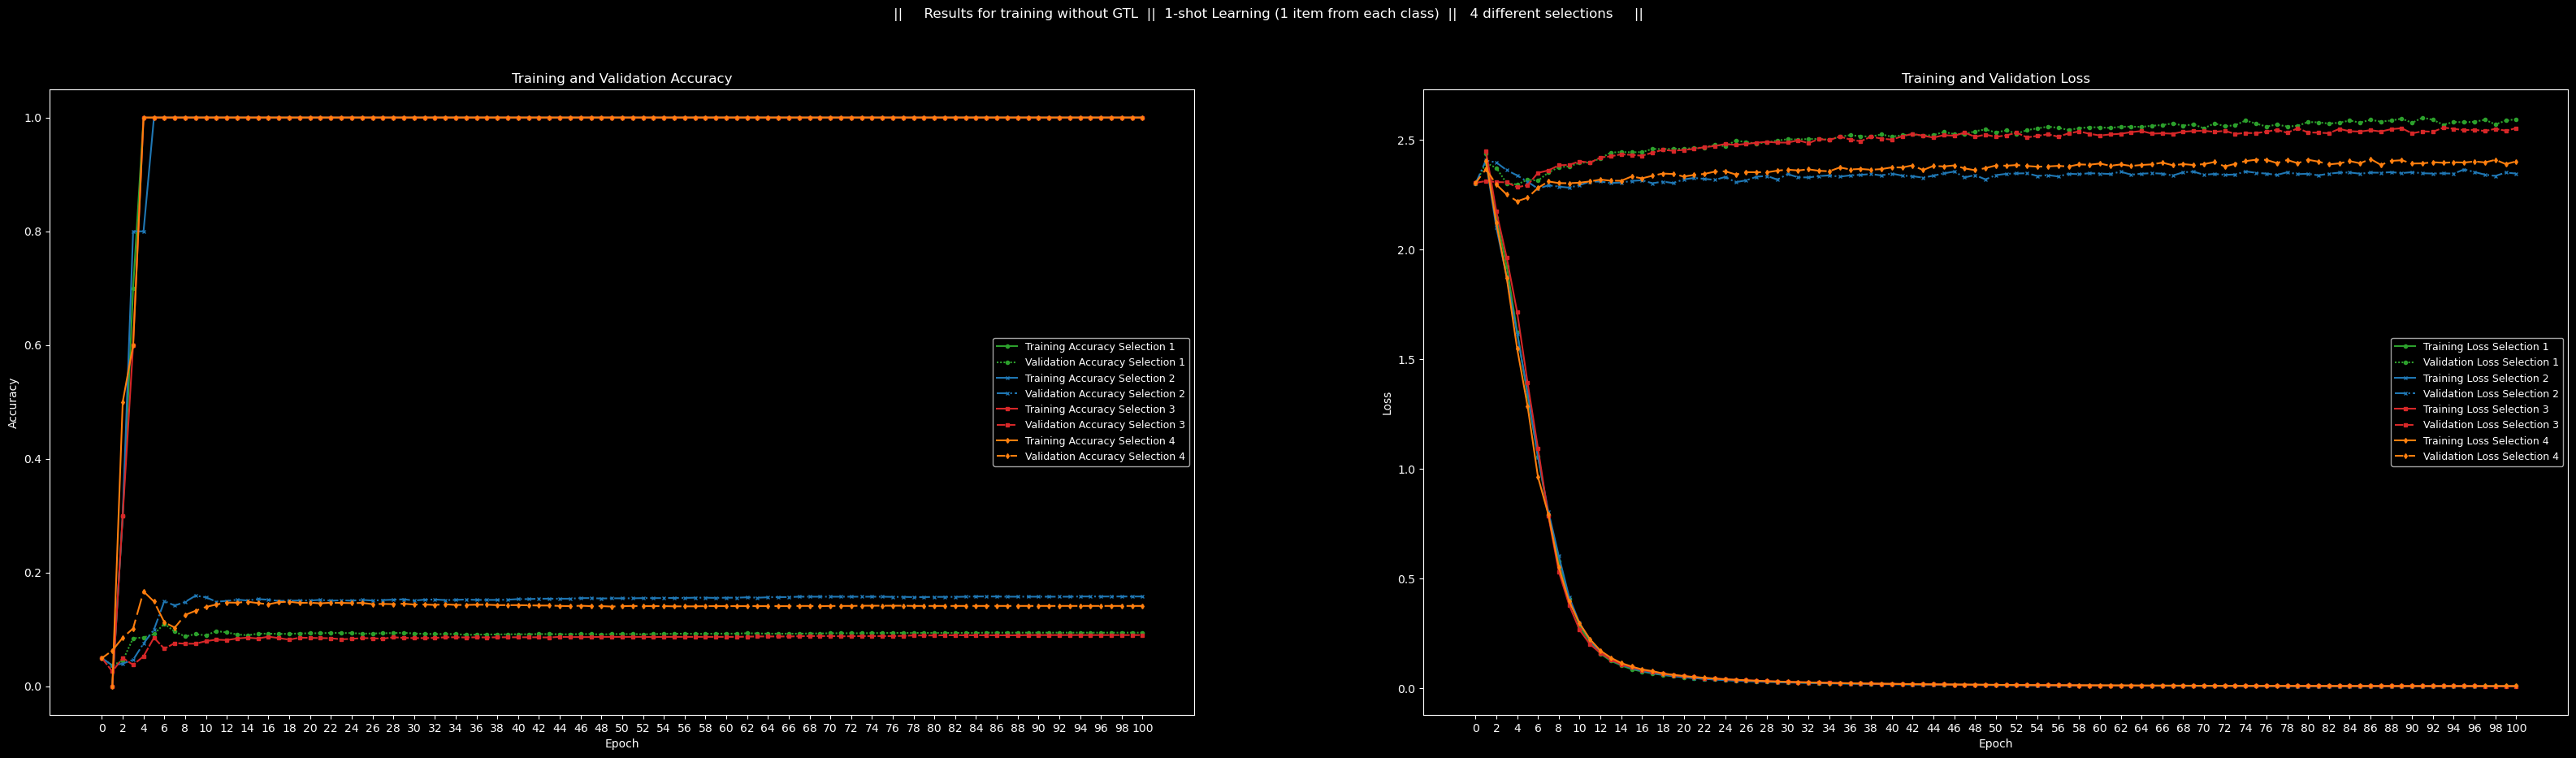

time: 406 ms (started: 2024-07-25 18:37:11 +03:00)


In [279]:
limit_per_class = 1
plot_multiple_results(all_multiple_results_withoutGTL_1shot, title= f"||     Results for training without GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||")  

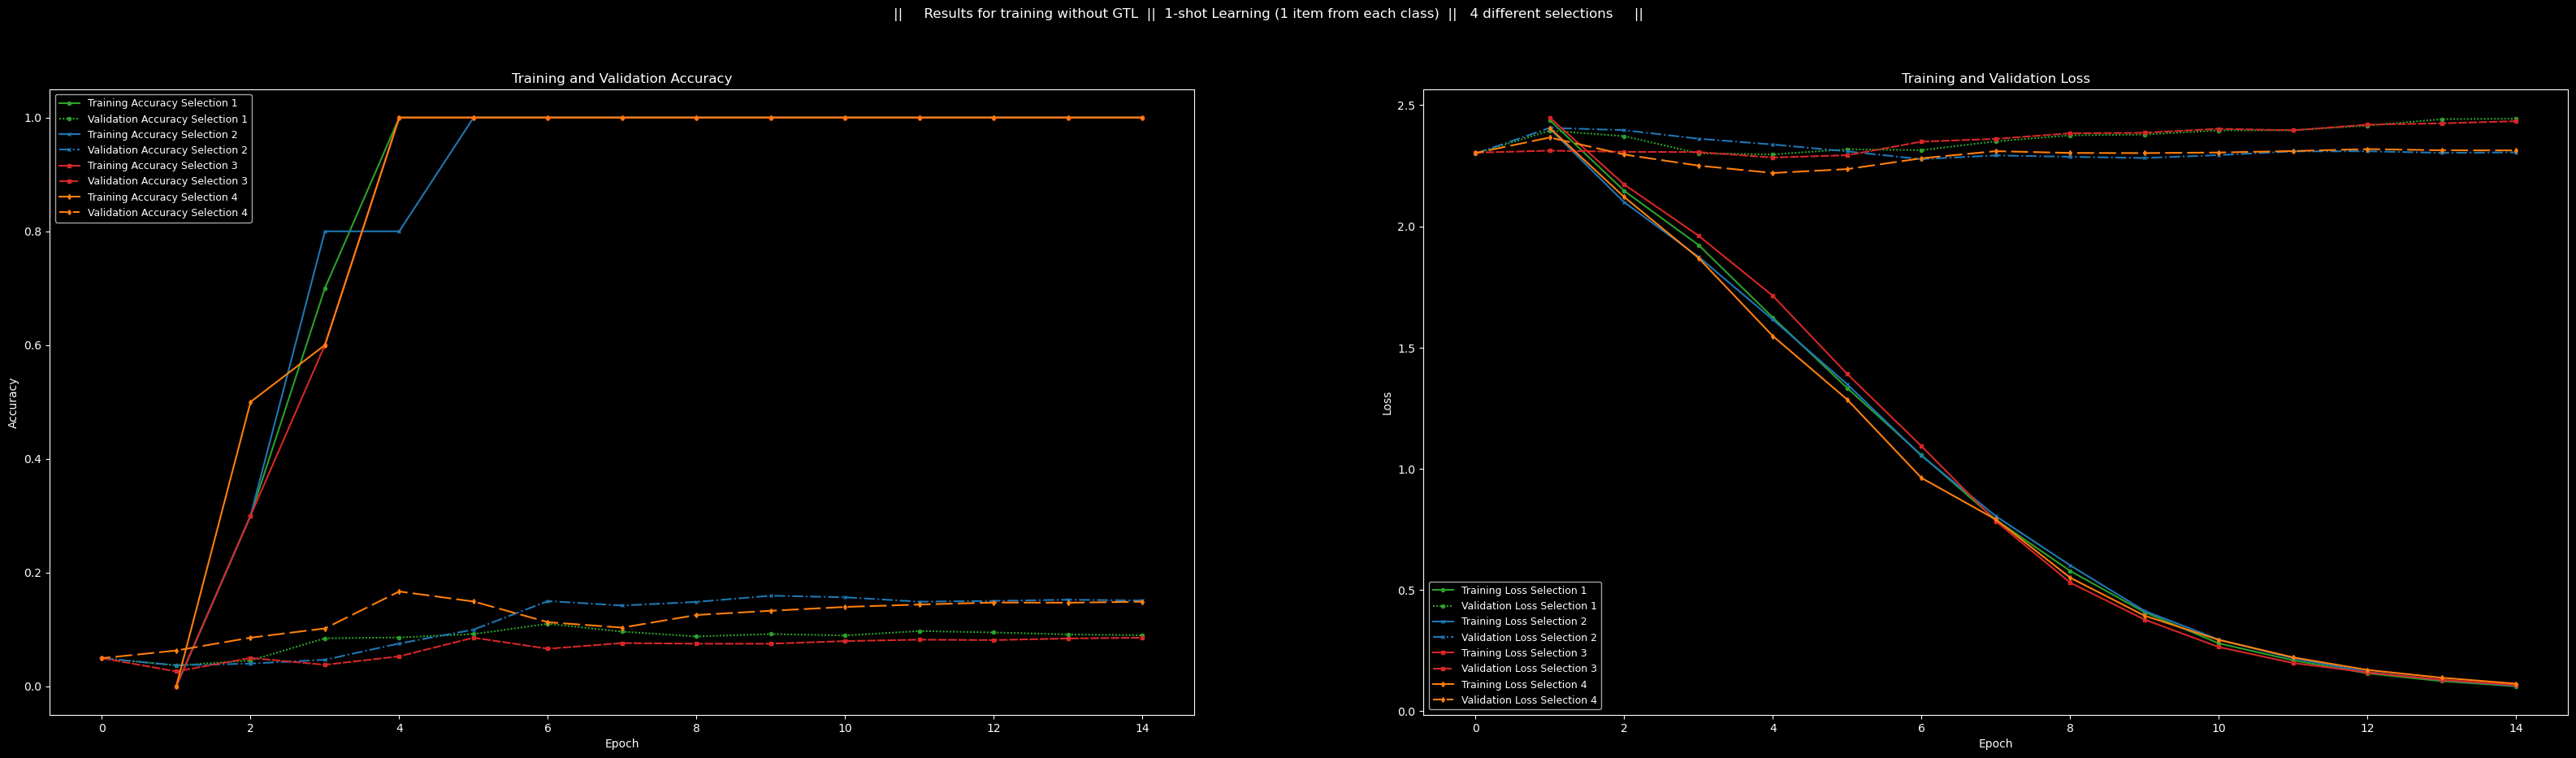

time: 297 ms (started: 2024-07-25 18:49:03 +03:00)


In [286]:
limit_per_class = 1
plot_multiple_results(all_multiple_results_withoutGTL_1shot, title= f"||     Results for training without GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14)

#### 5 items per class:

In [212]:
fewshot_total_list = [50,] 
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 5
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withoutGTL_5shot = []
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4]
    # ## ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter+1} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True) 

        print(f"# Start Training Few-shot ({int(fewshot_total/10)} items per class) without GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_without_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=False, 
                                                                train_verbose=True,
                                                                eval_verbose=True)

        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withoutGTL_5shot.append(train_results_few_shot_without_guidance_matrix)
        time.sleep(20)
        
    print(f"# Training Few-shot without GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")
    


Selection Nb 1 is running.
# Start Training Few-shot (5 items per class) without GTL for a total of 50 examples from 10 classes.
# BERT downloaded.
# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: # Validation loss: 2.30 || Validation  acc: 0.05
# Epoch: 1 (Learning rate: 5e-05)  Training loss: 2.36 || Training acc: 0.08 || Validation loss: 2.21 || Validation acc: 0.38
# Epoch: 5 (Learning rate: 4.8e-05)  Training loss: 1.77 || Training acc: 0.90 || Validation loss: 2.32 || Validation acc: 0.12
# Epoch: 10 (Learning rate: 4.55e-05)  Training loss: 0.53 || Training acc: 1.00 || Validation loss: 2.34 || Validation acc: 0.16
# Epoch: 15 (Learning rate: 4.3e-05)  Training loss: 0.12 || Training acc: 1.00 || Validation loss: 2.38 || Validation acc: 0.18
# Epoch: 20 (Learning rate: 4.05e-05)  Training loss: 0.06 || Training acc: 1.00 || Validation loss: 2.44 || Validation acc: 0.18
# Epoch: 25 (Learning rate: 3.8e-05)  Training loss: 0.04 || Training acc: 1.00 || Val

In [213]:
# For saving the results:

print(all_multiple_results_withoutGTL_5shot)

[{'train_results': [[2.3648462772369383, 2.2231811761856077, 2.1180633544921874, 1.968368136882782, 1.7666339993476867, 1.5150799989700316, 1.2554184198379517, 1.0014913082122803, 0.7391304969787598, 0.5329048037528992, 0.37799336612224577, 0.2723898380994797, 0.2020263910293579, 0.15572118312120437, 0.12251588925719262, 0.10113992616534233, 0.08500337749719619, 0.07318990007042885, 0.06374451480805873, 0.05644160024821758, 0.05055167451500893, 0.04572454616427422, 0.04160529263317585, 0.038192716985940935, 0.035285384580492976, 0.03273596279323101, 0.030442876182496546, 0.028497112169861793, 0.026748265884816647, 0.0252139700576663, 0.02381341829895973, 0.02259067390114069, 0.021426071412861347, 0.020402496308088304, 0.019485224969685078, 0.018619569018483162, 0.017858087457716464, 0.017127784062176944, 0.016465644538402557, 0.015863128006458282, 0.015289124194532632, 0.01477527366951108, 0.01427369648590684, 0.013829226046800614, 0.01340154530480504, 0.013002928998321294, 0.012631761

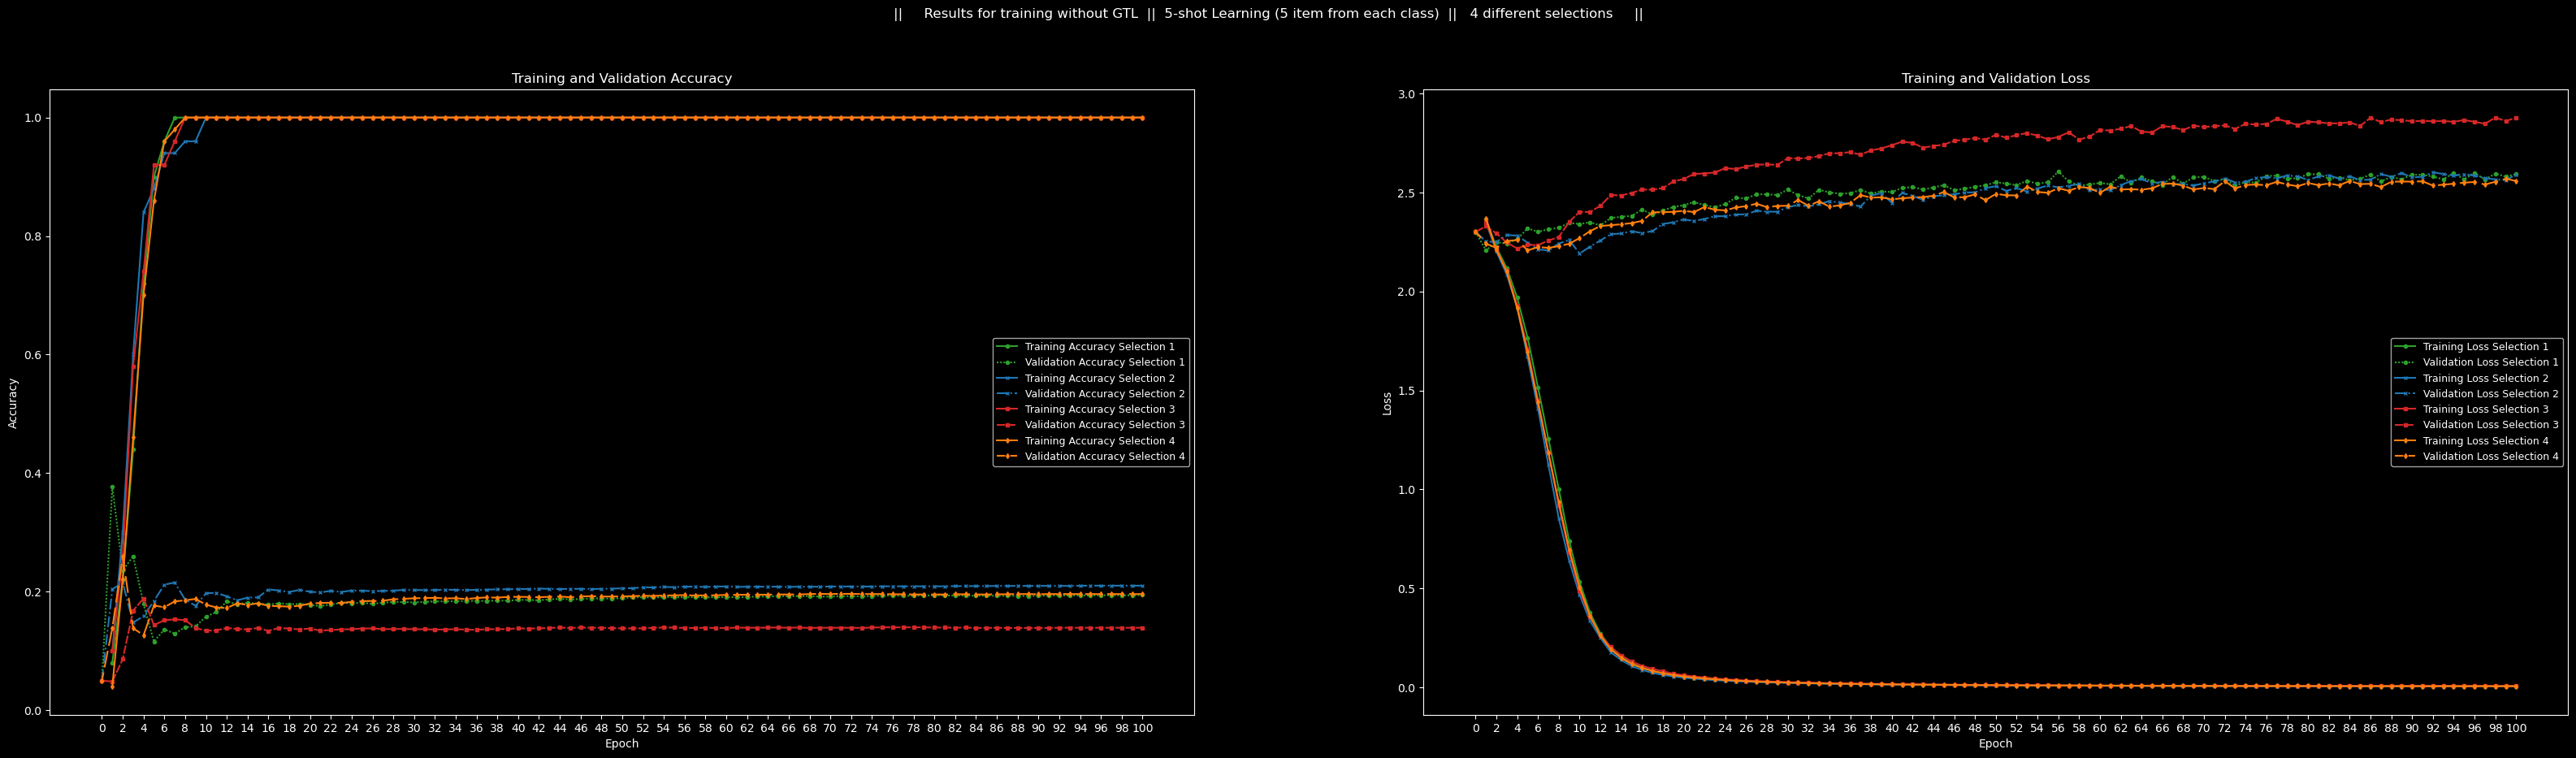

time: 672 ms (started: 2024-07-25 19:02:18 +03:00)


In [293]:
limit_per_class = 5
plot_multiple_results(all_multiple_results_withoutGTL_5shot, title= f"||     Results for training without GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||") 

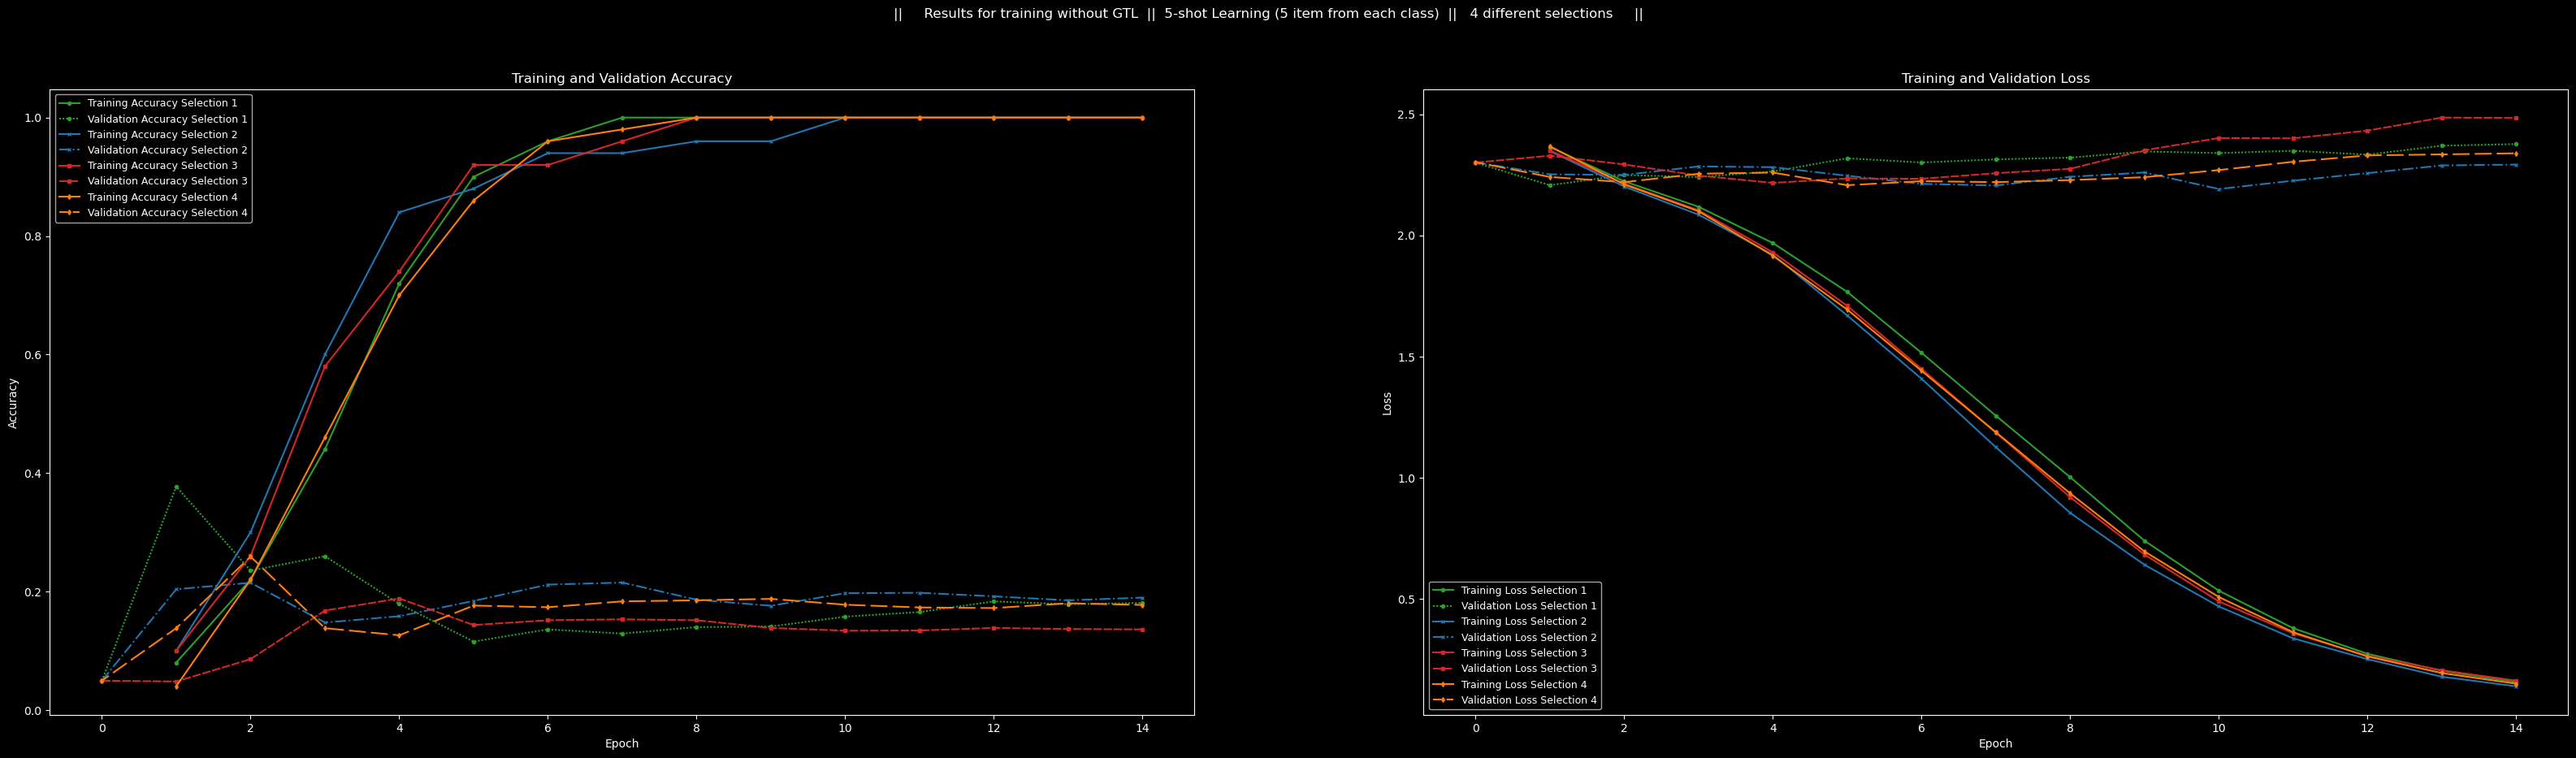

time: 281 ms (started: 2024-07-25 19:02:13 +03:00)


In [292]:
limit_per_class = 5
plot_multiple_results(all_multiple_results_withoutGTL_5shot, title= f"||     Results for training without GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14) 

#### 20-shot Learn:

In [222]:
fewshot_total_list = [200,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 20
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withoutGTL_20shot = [ ]
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter+1} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True) 

        print(f"# Start Training Few-shot ({int(fewshot_total/10)} items per class) without GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_without_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=False, 
                                                                train_verbose=True,
                                                                eval_verbose=True)
                                                                
        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withoutGTL_20shot.append(train_results_few_shot_without_guidance_matrix)
        time.sleep(10)
        
    print(f"# Training Few-shot without GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")
    


Selection Nb 1 is running.
# Start Training Few-shot (20 items per class) without GTL for a total of 200 examples from 10 classes.
# BERT downloaded.
# Epoch: 0  (Before start training) 
# Evaluating on Validation Dateset: # Validation loss: 2.30 || Validation  acc: 0.05
# Epoch: 1 (Learning rate: 5e-05)  Training loss: 2.33 || Training acc: 0.10 || Validation loss: 2.31 || Validation acc: 0.07
# Epoch: 5 (Learning rate: 4.8e-05)  Training loss: 1.85 || Training acc: 0.67 || Validation loss: 2.15 || Validation acc: 0.21
# Epoch: 10 (Learning rate: 4.55e-05)  Training loss: 0.68 || Training acc: 0.98 || Validation loss: 2.10 || Validation acc: 0.23
# Epoch: 15 (Learning rate: 4.3e-05)  Training loss: 0.16 || Training acc: 1.00 || Validation loss: 2.11 || Validation acc: 0.27
# Epoch: 20 (Learning rate: 4.05e-05)  Training loss: 0.06 || Training acc: 1.00 || Validation loss: 2.26 || Validation acc: 0.27
# Epoch: 25 (Learning rate: 3.8e-05)  Training loss: 0.04 || Training acc: 1.00 || V

In [223]:
# For saving the results:
print(all_multiple_results_withoutGTL_20shot)

[{'train_results': [[2.325023126602173, 2.238702964782715, 2.155939793586731, 2.0333783984184266, 1.8528767824172974, 1.6353808045387268, 1.3949432730674745, 1.143932282924652, 0.8957448601722717, 0.6784335434436798, 0.4989338666200638, 0.36822604537010195, 0.2679054751992226, 0.2041804701089859, 0.1553499460220337, 0.12314680516719818, 0.10078904405236244, 0.08420066386461258, 0.07203091382980346, 0.06256053857505321, 0.05514945238828659, 0.04906977526843548, 0.0441453255712986, 0.04012009724974632, 0.036609412357211116, 0.03368244376033545, 0.03117853235453367, 0.028925029560923576, 0.027038169279694556, 0.0253441758453846, 0.023823329992592335, 0.022437158040702343, 0.021244120225310324, 0.020162829756736757, 0.019135775975883007, 0.01822472345083952, 0.017409307323396205, 0.016643015667796135, 0.015937767829746007, 0.015301528852432966, 0.01469395523890853, 0.014160128496587276, 0.013638723082840443, 0.013169020134955644, 0.012726200371980667, 0.012317447271198035, 0.01192817790433

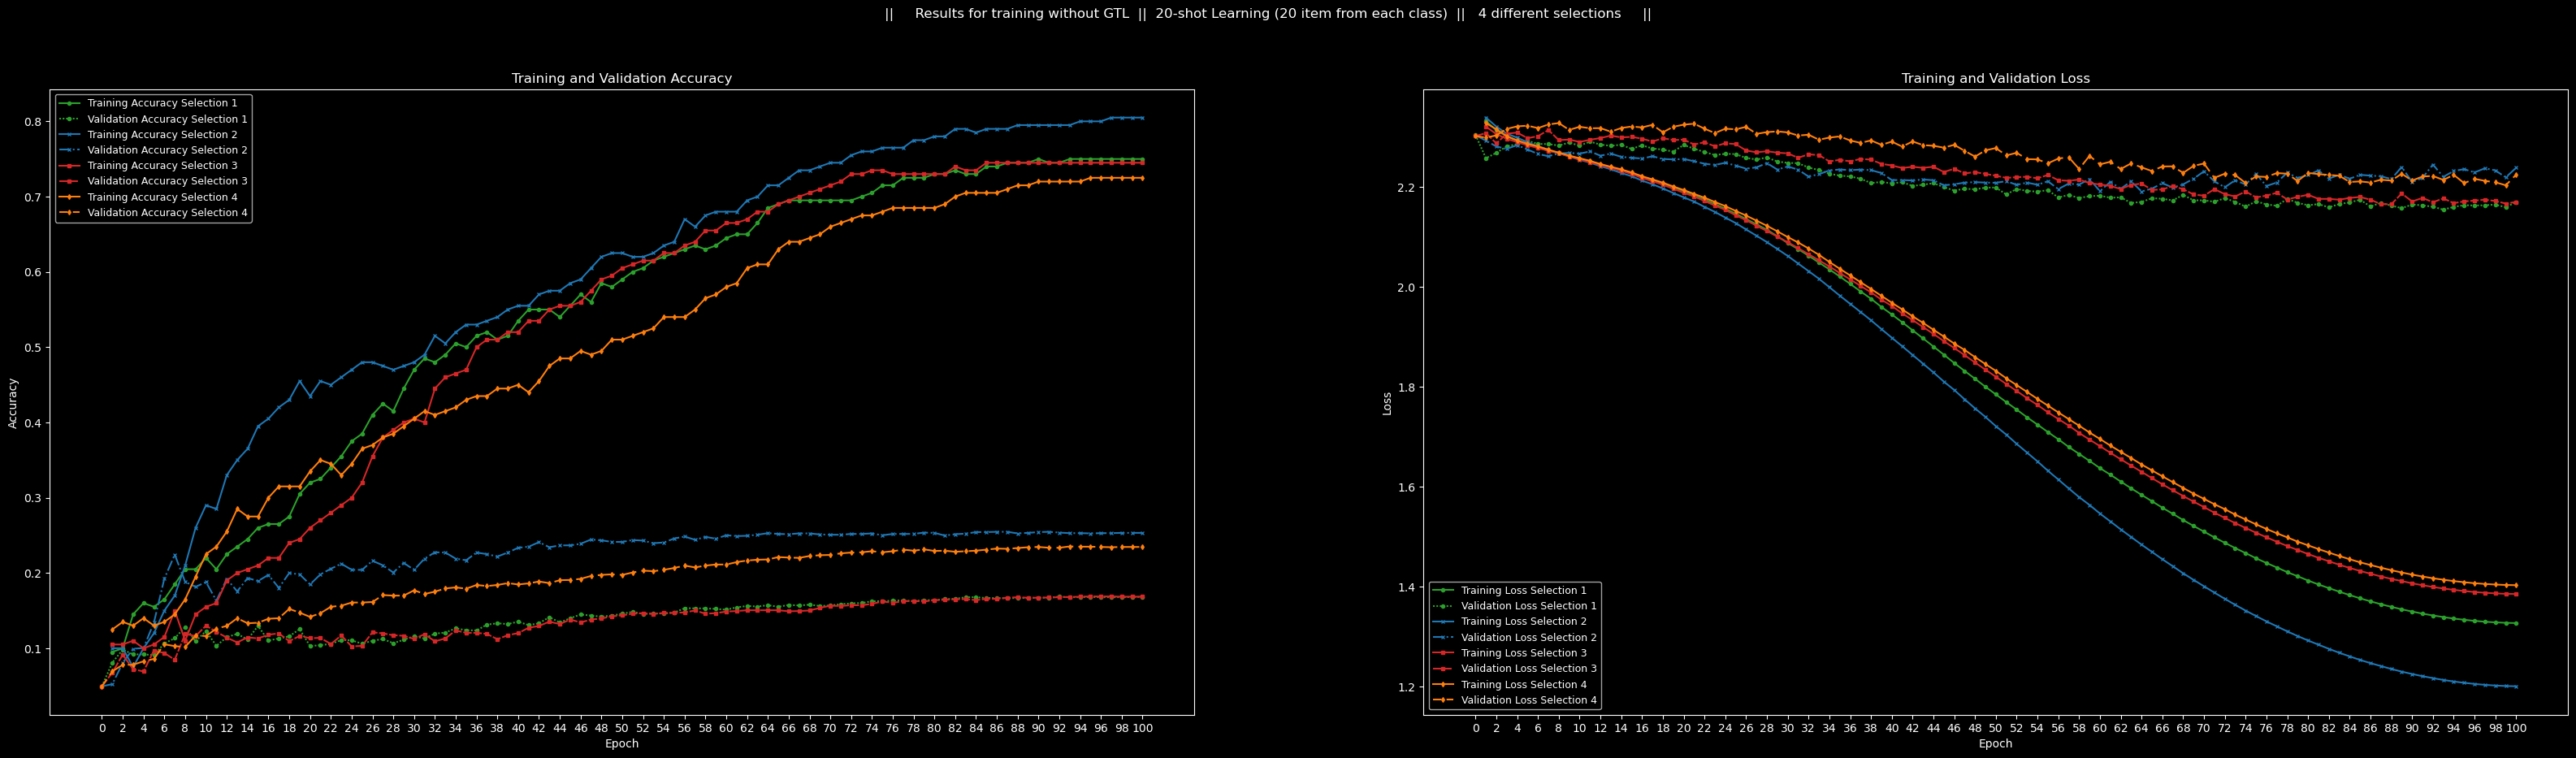

time: 422 ms (started: 2024-07-25 18:53:37 +03:00)


In [288]:
limit_per_class = 20
plot_multiple_results(all_multiple_results_withoutGTL_20shot, title= f"||     Results for training without GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||") 

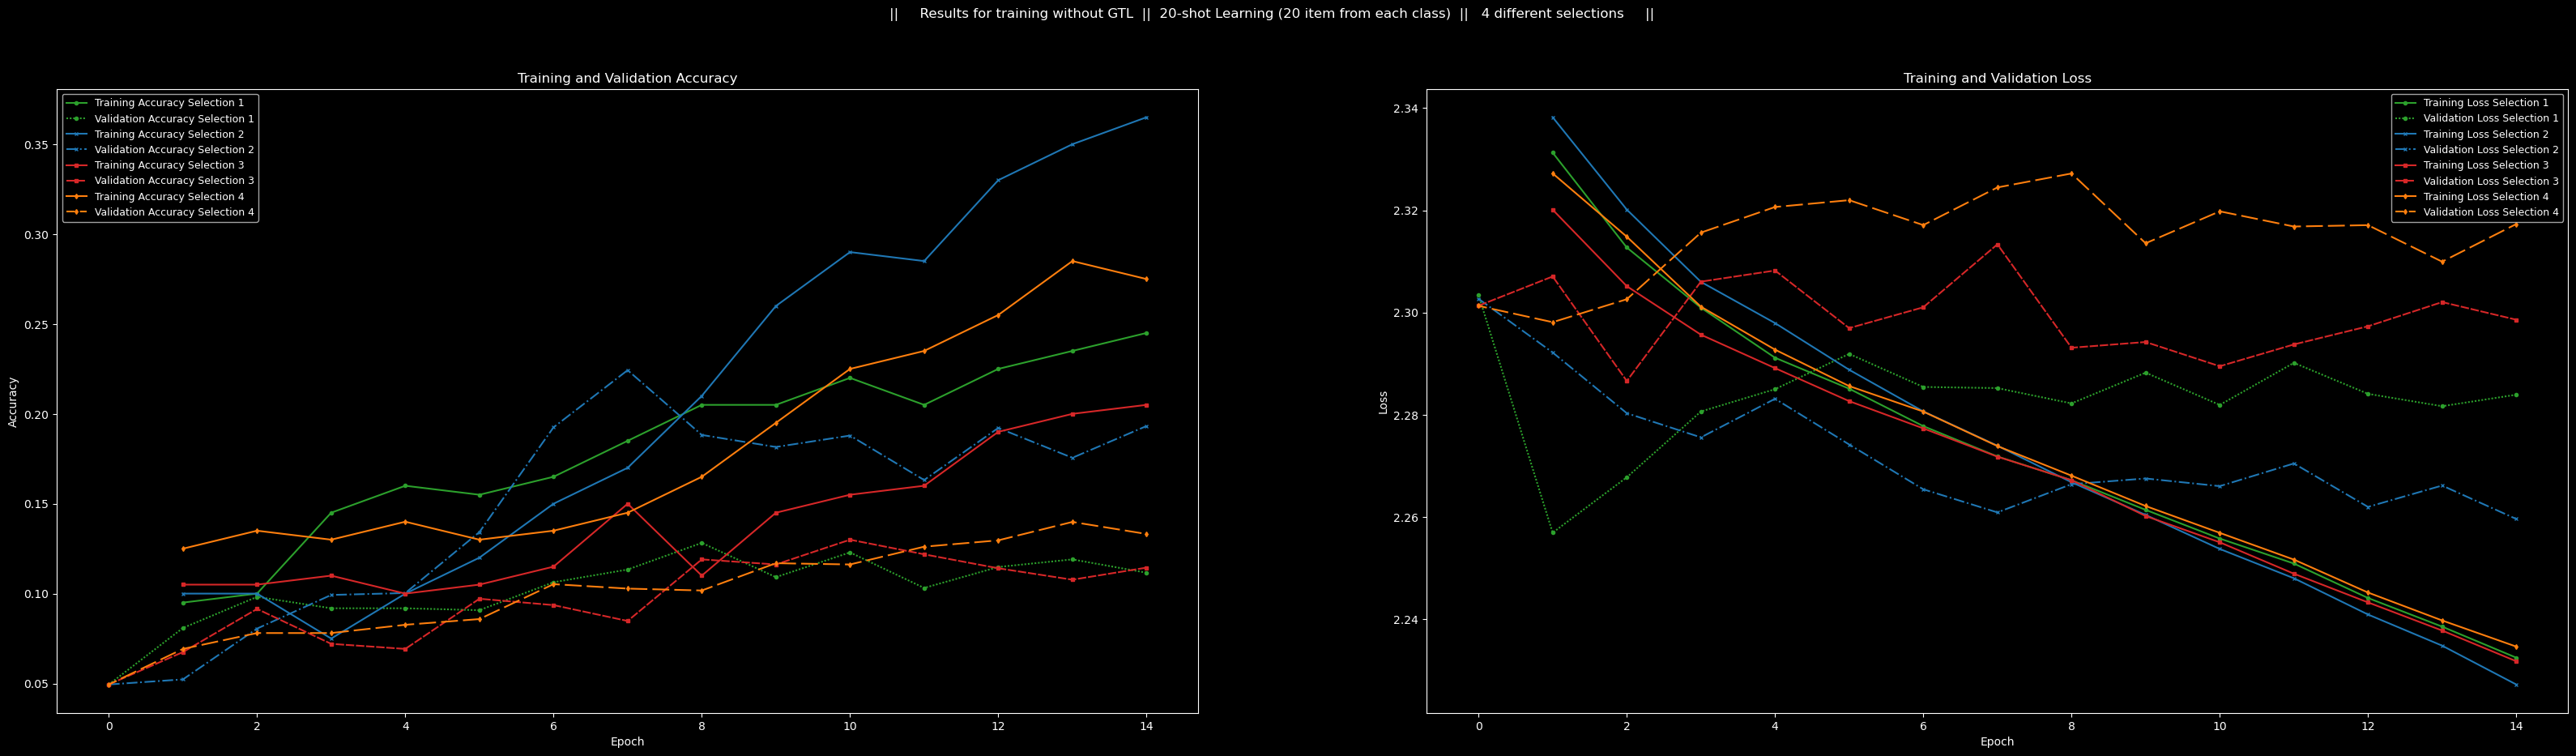

time: 312 ms (started: 2024-07-25 19:01:55 +03:00)


In [291]:
limit_per_class = 20
plot_multiple_results(all_multiple_results_withoutGTL_20shot, title= f"||     Results for training without GTL  ||  {int(limit_per_class)}-shot Learning ({int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14) 

### Training wihout Guided Transfer Learning (No BERT Unfreezed layers)

#### 1 item per class:

In [ ]:
fewshot_total_list = [10,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 1
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withoutGTL_1shot = [ ]
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True)
        
        print(f"# Start Training Few-shot ({int(fewshot_total/10)} items per class) without GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        
        ###################################
        # unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_without_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=False, 
                                                                train_verbose=True,
                                                                eval_verbose=True)
                                                                
        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withoutGTL_1shot_allFreezed.append(train_results_few_shot_without_guidance_matrix)
        time.sleep(10)
        
    print(f"# Training Few-shot without GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")

In [ ]:
# For saving the results:
print(all_multiple_results_withoutGTL_1shot_allFreezed)

In [ ]:
limit_per_class = 1
plot_multiple_results(all_multiple_results_withoutGTL_1shot_allFreezed, title= f"||     Results for training without GTL - BERT all frozen  ||  {int(limit_per_class)}-shot Learning( {int(limit_per_class)} item from each class)  ||   4 different selections     ||")  

In [ ]:
plot_multiple_results(all_multiple_results_withoutGTL_1shot_allFreezed, title= f"||     Results for training without GTL - BERT all frozen  ||  {int(limit_per_class)}-shot Learning( {int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14) 


In [ ]:
time.sleep(1200)

#### 5 items per class:

In [ ]:
fewshot_total_list = [50,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 5
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withoutGTL_5shot = []
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    # ## ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter+1} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True) 

        print(f"# Start Training Few-shot ({int(fewshot_total/10)} items per class) without GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        
        ###################################################################################
        # unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 

        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_without_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=False, 
                                                                train_verbose=True,
                                                                eval_verbose=True)

        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withoutGTL_5shot_allFreezed.append(train_results_few_shot_without_guidance_matrix)
        time.sleep(20)
        
    print(f"# Training Few-shot without GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")
    

In [ ]:
# For saving the results:
print(all_multiple_results_withoutGTL_5shot_allFreezed)

In [ ]:
limit_per_class = 5
plot_multiple_results(all_multiple_results_withoutGTL_5shot_allFreezed, title= f"||     Results for training without GTL - BERT all frozen   ||  {int(limit_per_class)}-shot Learning( {int(limit_per_class)} item from each class)  ||   4 different selections     ||") 

In [ ]:
limit_per_class = 5
plot_multiple_results(all_multiple_results_withoutGTL_5shot_allFreezed, title= f"||     Results for training without GTL - BERT all frozen  ||  {int(limit_per_class)}-shot Learning( {int(limit_per_class)} item from each class)  ||   4 different selections     ||", nb_epochs_toplot=14) 

In [ ]:
time.sleep(1200)

#### 20 items per class:

In [ ]:
fewshot_total_list = [200,]
dropout = 0.2
nb_of_layers_to_unfreeze = 1
lr_fine_tuning = 5e-5
criterion = nn.CrossEntropyLoss() 
epochs = 100 
# patience = 20
train_batch_size = 20
val_batch_size = 128
test_batch_size = 128 

all_multiple_results_withoutGTL_20shot = [ ]
for fewshot_total in fewshot_total_list:

    goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
    goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)

    # fewshot_total = 100 
    limit_per_class = fewshot_total/10 
    
    #######################################################################################################################################
    #######################################################################################################################################
    previous_selections = []
    dataset_B_indexes_selection_1 = [] ;dataset_B_indexes_selection_2 = [];dataset_B_indexes_selection_3 = []; dataset_B_indexes_selection_4 = [];
    
    # adds 10*limit_per_class items to the selection, so that limit_per_class items are from each class 
    add_selection_range(dataset_B_indexes_selection_1, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_2, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_3, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)
    add_selection_range(dataset_B_indexes_selection_4, previous_selections, goemotions_train_dataset_B, random_classes_B, limit_per_class)

    all_dataset_B_indexes_selections = [dataset_B_indexes_selection_1, dataset_B_indexes_selection_2, dataset_B_indexes_selection_3, dataset_B_indexes_selection_4 ]
    ## print('all_dataset_B_indexes_selections: ', all_dataset_B_indexes_selections)
    #######################################################################################################################################
    #######################################################################################################################################
    
    # iter = 1 
    all_results = []
    for iter,dataset_B_indexes in enumerate(all_dataset_B_indexes_selections):
        print(f"\nSelection Nb {iter+1} is running.")
        # iter += 1
        train_total_random_indexes = dataset_B_indexes  
        # print('train_total_random_indexes: ', train_total_random_indexes)   
        #    
        train_total_random_indexes.sort()

        # Take points that have only one label and the class is in the dataset B classes 
        goemotions_train_dataset_B = goemotions_dataset['train'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_val_dataset_B = goemotions_dataset['validation'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        goemotions_test_dataset_B = goemotions_dataset['test'].filter(lambda x: len(x['labels']) == 1 and x['labels'] in classes_B_np)
        
        #create a function with partial to be able to take additional argument random_classes_B and to pass to map  
        goemotions_preprocess_wnewlabeling_function_B = partial(goemotions_preprocess_wnewlabeling_function, additional_arg=random_classes_B)

        goemotions_train_dataset_B = goemotions_train_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_val_dataset_B = goemotions_val_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 
        goemotions_test_dataset_B = goemotions_test_dataset_B.map(goemotions_preprocess_wnewlabeling_function_B, batched=True) 

        goemotions_train_dataset_B = CustomDatasetClass(goemotions_train_dataset_B) 
        goemotions_val_dataset_B = CustomDatasetClass(goemotions_val_dataset_B) 
        goemotions_test_dataset_B = CustomDatasetClass(goemotions_test_dataset_B) 

        goemotions_subset_train_B = Subset(goemotions_train_dataset_B, train_total_random_indexes)
        ## Take all the validation and test datasets
        ##

        goemotions_train_B_loader = DataLoader(goemotions_subset_train_B, batch_size = train_batch_size, shuffle=True) 
        goemotions_val_B_loader = DataLoader(goemotions_val_dataset_B, batch_size = val_batch_size, shuffle=True) 
        goemotions_test_B_loader = DataLoader(goemotions_test_dataset_B, batch_size = test_batch_size, shuffle=True) 

        print(f"# Start Training Few-shot ({int(fewshot_total/10)} items per class) without GTL for a total of {fewshot_total} examples from 10 classes.")

        bert = BertModel.from_pretrained('bert-base-uncased') # BERT frozen 
        print("# BERT downloaded.")
        ClassificationBERT_few_shot = ClassificationBERT(bert, num_labels=num_labels, dropout=dropout).to(DEVICE)
        
        ##################################


        # unfreeze_BERT_layers(bert, nb_of_layers_to_unfreeze) 
        
        ClassificationBERT_few_shot.load_state_dict(torch.load('C:/Users/user/Desktop/My_Files/Anaconda  Projects/data/Models/ClassificationBERT_reference.pt'))    
    
        #train with few shot examples from dataset B 
        train_results_few_shot_without_guidance_matrix = train_model(ClassificationBERT_few_shot,
                                                                optimizer = AdamW(ClassificationBERT_few_shot.parameters(),lr=lr_fine_tuning),
                                                                criterion=criterion,
                                                                epochs= epochs,
                                                                train_loader=goemotions_train_B_loader, 
                                                                validation_loader=goemotions_val_B_loader, 
                                                                with_early_stopping=False,
                                                                with_GTL=False, 
                                                                train_verbose=True,
                                                                eval_verbose=True)
                                                                
        _ = evaluate_model(ClassificationBERT_few_shot,criterion=criterion, loader=goemotions_test_B_loader,dataset_category="Testing")
        all_multiple_results_withoutGTL_20shot_allFreezed.append(train_results_few_shot_without_guidance_matrix)
        time.sleep(10)
        
    print(f"# Training Few-shot without GTL for a total of {fewshot_total} examples from 10 classes Done.\n") #change to before plot_resutls. 
    print("================================================================================================")
    

In [ ]:
# For saving the results:
print(all_multiple_results_withoutGTL_20shot_allFreezed)

In [ ]:
limit_per_class = 20
plot_multiple_results(all_multiple_results_withoutGTL_20shot_allFreezed, title= f"Results for training without GTL - BERT all frozen  (4 different selections: {int(limit_per_class)} from each class)")  

In [ ]:
limit_per_class = 20 
plot_multiple_results(all_multiple_results_withoutGTL_20shot_allFreezed, title= f"Results for training without GTL - BERT all frozen  (4 different selections: {int(limit_per_class)} from each class)",nb_epochs_toplot=16)   

In [ ]:
time.sleep(1200)